# Subclustering - Endothelial

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
# Libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
import numpy as np
import re
import os
import scanpy as sc
import harmony
from harmony import harmonize
import pybiomart
import sccoda
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import normalize

import rpy2
import rpy2.situation as rsetup
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter

import warnings

/home/unix/chaffin/.local/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:15: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [3]:
# R packages required
base = importr('base')
edgeR = importr('edgeR')
DESeq2 = importr('DESeq2')
limma = importr('limma')
stats = importr('stats')
topgo = importr('topGO')
GO_db = importr('GO.db')
biomaRt = importr('biomaRt')
org_Hs_eg_db = importr('org.Hs.eg.db')
data_table = importr('data.table')
grdevices = importr('grDevices')
ReactomePA = importr("ReactomePA")
AnnotationDbi = importr('AnnotationDbi')
reactome_db = importr('reactome.db')

R[write to console]: 
groupGOTerms: 	GOBPTerm, GOMFTerm, GOCCTerm environments built.



In [4]:
# Python package versions
print('scanpy: ' + sc.__version__)
print('pandas: ' + pd.__version__)
print('numpy: ' + np.__version__)
print('harmony: ' + harmony.__version__)
print('scCODA: ' + sccoda.__version__)
print('rpy2: ' + rpy2.__version__)

scanpy: 1.8.1
pandas: 1.2.4
numpy: 1.18.1
harmony: 0.1.4
scCODA: 0.1.2.post1
rpy2: 3.0.5


In [5]:
# R package version
print('R version: ' + base.__version__)
print('edgeR: ' + edgeR.__version__)
print('DESeq2: ' + DESeq2.__version__)
print('limma: ' + limma.__version__)
print('stats: ' + stats.__version__)
print('topgo: ' + topgo.__version__)
print('biomaRt: ' + biomaRt.__version__)
print('GO.db: ' + GO_db.__version__)
print('org.Hs.eg.db: ' + org_Hs_eg_db.__version__)
print('data.table: ' + data_table.__version__)
print('grdevices: ' + grdevices.__version__)
print('ReactomePA: ' + ReactomePA.__version__)
print('AnnotationDbi: ' + AnnotationDbi.__version__)
print('reactome.db: ' + reactome_db.__version__)

R version: 3.6.0
edgeR: 3.30.3
DESeq2: 1.20.0
limma: 3.44.3
stats: 3.6.0
topgo: 2.32.0
biomaRt: 2.36.1
GO.db: 3.12.1
org.Hs.eg.db: 3.12.0
data.table: 1.13.4
grdevices: 3.6.0
ReactomePA: 1.24.0
AnnotationDbi: 1.52.0
reactome.db: 1.64.0


In [6]:
# Turn off some annoying FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# File Paths

In [7]:
path_aggregation = '../../data/aggregation'
gtf_path = '../../data/misc/GRCh38-2020-A_premrna.gtf'
results_path = '../../results/subclustering_v2'
scoring_data_path = '../../data/misc/'

In [8]:
if not os.path.isdir(results_path):
    os.system('mkdir ' + results_path)

# Sub-clustering procedure

In [9]:
# Set cell type label and included leiden clusters
celltype = 'endothelial'
clusters = ['2','5','8','11']

In [11]:
# Create a directory for output
if not os.path.isdir(os.path.join(results_path, celltype)):
    os.mkdir(os.path.join(results_path, celltype))

In [10]:
# Read the snRNAseq map and subset to just the relevant cell type
adata = sc.read(os.path.join(path_aggregation, 'humanICM.PostQC.Map/PostQC.Neighbor.UMAP.Freeze1.h5ad'))
bdata = adata[adata.obs['leiden0.5'].isin(clusters)].copy()
print('Total number of ' + celltype + ' = ' + str(bdata.shape[0]))

Only considering the two last: ['.Freeze1', '.h5ad'].
Only considering the two last: ['.Freeze1', '.h5ad'].


Total number of endothelial = 20462


In [12]:
'''
Function to perform subclustering
bdata: the input anndata with only the nuclei to subcluster
auc_stop: the threshold for stopping clustering. when a subcluster emerges
          with no genes that have an AUC > auc_stop, stop procedure and
          go back to the previous resolution.
n_neighbor: the number of neighbors for clustering
incr: the increment at which to increase the cluster resolution
min_res: the minimum resolution to begin clustering at
max_res: the maximum resolution allowed (stop point)
'''
def subcluster(bdata, auc_stop, n_neighbor, incr, min_res, max_res, regress_umi_mt):
    incr = round(incr, 2)
    min_res = round(min_res,2)
    max_res = round(max_res,2)
    
    print('Calculating highly variable genes')
    sc.pp.highly_variable_genes(bdata, n_top_genes = 2000, flavor = 'seurat_v3')
    
    # Now normalize prior to PCA (and take log)
    print('Log-normalizing')
    sc.pp.normalize_total(bdata, target_sum=1e4)
    sc.pp.log1p(bdata)
    # subset to highly variable genes
    bdata.raw = bdata
    bdata = bdata[:, bdata.var.highly_variable]
    
    # Scaling, regressing out percent MT and and total counts as technical features of the data
    if regress_umi_mt:    
        print('Regressing out UMI and MT')
        sc.pp.regress_out(bdata, ['cellbender_ncount', 'cellranger_percent_mito'])
    else:
        print('Not regressing out technical features')
    sc.pp.scale(bdata, max_value=10)
    
    # Next we need to run PCA so we can feed that into harmony
    print('Calculating PCA')
    sc.tl.pca(bdata, svd_solver='arpack', n_comps = 50)
    
    # Make a batch variable -- aligning based on sample
    print('Harmonizing PCs')
    bdata.obs['batch'] = bdata.obs['individual'].astype('category')
    Z = harmonize(bdata.obsm['X_pca'], bdata.obs, batch_key = 'batch', max_iter_harmony = 20)
    bdata.obsm['X_pca'] = Z

    print('Calculating new neighborhood graph...')
    sc.pp.neighbors(bdata, n_neighbors=n_neighbor, n_pcs=50, metric = 'cosine')
    
    print('Builing UMAP...')
    sc.tl.umap(bdata, min_dist = 0.2)

    print('Iterating through different resolutions...')
    marker_res = {}
    prev = min_res
    for i in range(int(min_res*100),int(max_res*100),int(incr*100)):
        res = i/100.
        print('\t'+str(res))
        sc.tl.leiden(bdata, resolution = res, key_added = 'leiden'+str(res))
        print(len(bdata.obs['leiden'+str(res)].unique()))
        if len(bdata.obs['leiden'+str(res)].unique()) <= 1:
            prev = res
            continue
        # find markers
        sc.tl.rank_genes_groups(bdata, 'leiden' + str(res), method='wilcoxon', n_genes = bdata.raw.shape[1])
        # Convert markers to datatable
        allmerge = []
        for q in range(len(bdata.obs['leiden' + str(res)].unique())):
            forframe = {}
            for i in bdata.uns['rank_genes_groups'].keys():
                if i =='params':
                    continue
                newcol = []
                sub = bdata.uns['rank_genes_groups'][i].tolist()
                for s in sub:
                    newcol.append(s[q])
                forframe[i] = newcol
            wilcox = pd.DataFrame(forframe)
            wilcox['cluster'] = bdata.uns['rank_genes_groups']['names'].dtype.names[q]
            allmerge.append(wilcox)
        fullresults = pd.concat(allmerge)
        nlookup = pd.DataFrame(bdata.obs['leiden' + str(res)].value_counts()).reset_index()
        nlookup.columns = ['cluster', 'n1']
        n2_v = []
        for i in nlookup['cluster']:
            n2_v.append(nlookup[nlookup['cluster']!=i]['n1'].sum())
        nlookup['n2'] = n2_v
        nlookup['cluster'] = [x for x in nlookup['cluster']]
        fullresults = fullresults.merge(nlookup, on = 'cluster', how='left')
        fullresults['U'] = (fullresults['scores'] * np.sqrt((fullresults['n1']*fullresults['n2']*(fullresults['n1'] + fullresults['n2'] + 1)) / 12)) + ((fullresults['n1'] * fullresults['n2']) / 2)
        fullresults['AUC'] = fullresults['U']/(fullresults['n1'] * fullresults['n2'])
        marker_res[res] = fullresults
        if len(fullresults[fullresults['AUC'] > auc_stop]['cluster'].value_counts().index) < len(bdata.obs['leiden'+str(res)].unique()):
            break
        prev = res
    
    if not prev in marker_res.keys():
        return(bdata, bdata.obs[['leiden'+str(prev)]], None)
    else:
        return(bdata, bdata.obs[['leiden'+str(prev)]], marker_res)

In [13]:
# Subcluster all nuclei
sdata, subclust, markers = subcluster(bdata = bdata,
                                      auc_stop = 0.6,
                                      n_neighbor = 10,
                                      incr = 0.1,
                                      min_res = 0.1,
                                      max_res = 2.0,
                                      regress_umi_mt = False)

Calculating highly variable genes
Log-normalizing
Not regressing out technical features


/home/unix/chaffin/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Calculating PCA
Harmonizing PCs
	Initialization is completed.
	Completed 1 / 20 iteration(s).
	Completed 2 / 20 iteration(s).
	Completed 3 / 20 iteration(s).
Reach convergence after 3 iteration(s).
Calculating new neighborhood graph...
Builing UMAP...
Iterating through different resolutions...
	0.1
4
	0.2
6
	0.3
7
	0.4
8
	0.5
9
	0.6
10
	0.7
12
	0.8
14
	0.9
14
	1.0
18
	1.1
18
	1.2
21
	1.3
21
	1.4
25
	1.5
27
	1.6
28


In [14]:
# Save the markers for each resolution
for i in markers.keys():
    markers[i].to_csv(os.path.join(results_path, celltype + '/auc_markers_' + str(i) + '.txt.gz'),
                      sep='\t', index=None, na_rep='NA', compression='gzip')

In [15]:
# Save the selected subcluster groupings
subclust.reset_index().to_csv(os.path.join(results_path, celltype + '/selected_subclusters_' + subclust.columns[0] + '.txt.gz'),
                              sep='\t', index=None, na_rep='NA', compression='gzip')

In [16]:
# Save the full anndata with the new labels, as this has all the neighborhood and UMAP info
sdata.write(os.path.join(results_path, celltype + '/subcluster_map.h5ad'))

# Preliminary Investigation of sub-clusters

In [17]:
# The chosen resolution (can manually select a different if desired)
i = 1.6

In [18]:
# Re-read expression
adata = sc.read(os.path.join(results_path, celltype + '/subcluster_map.h5ad'))

In [19]:
mymarkers = pd.read_csv(os.path.join(results_path, celltype + '/auc_markers_' + str(round(i,1)) + '.txt.gz'),
                    sep='\t')
print(mymarkers[mymarkers['AUC'] > 0.6]['cluster'].value_counts())

27    757
0     177
2      99
11     67
6      42
21     34
3      26
7      24
16     21
15     21
13     21
18     19
8      16
22     16
1      15
23     15
26     14
4      12
25     12
24      9
19      7
10      6
9       5
5       4
20      3
14      3
12      1
Name: cluster, dtype: int64


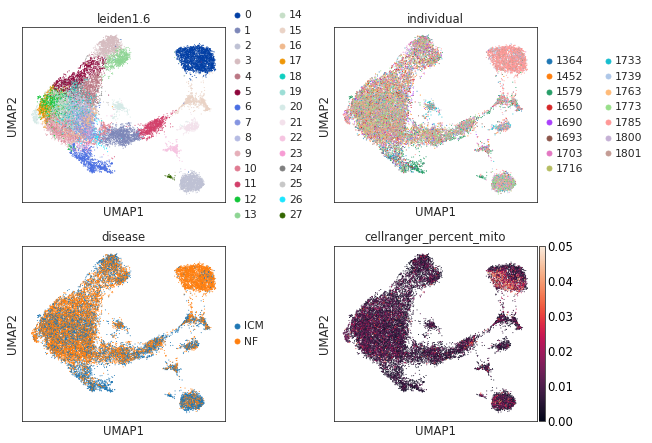

In [20]:
sc.set_figure_params(dpi=60)
sc.pl.umap(adata, color = ['leiden' + str(i), 'individual', 'disease','cellranger_percent_mito'], ncols=2, wspace = .4)

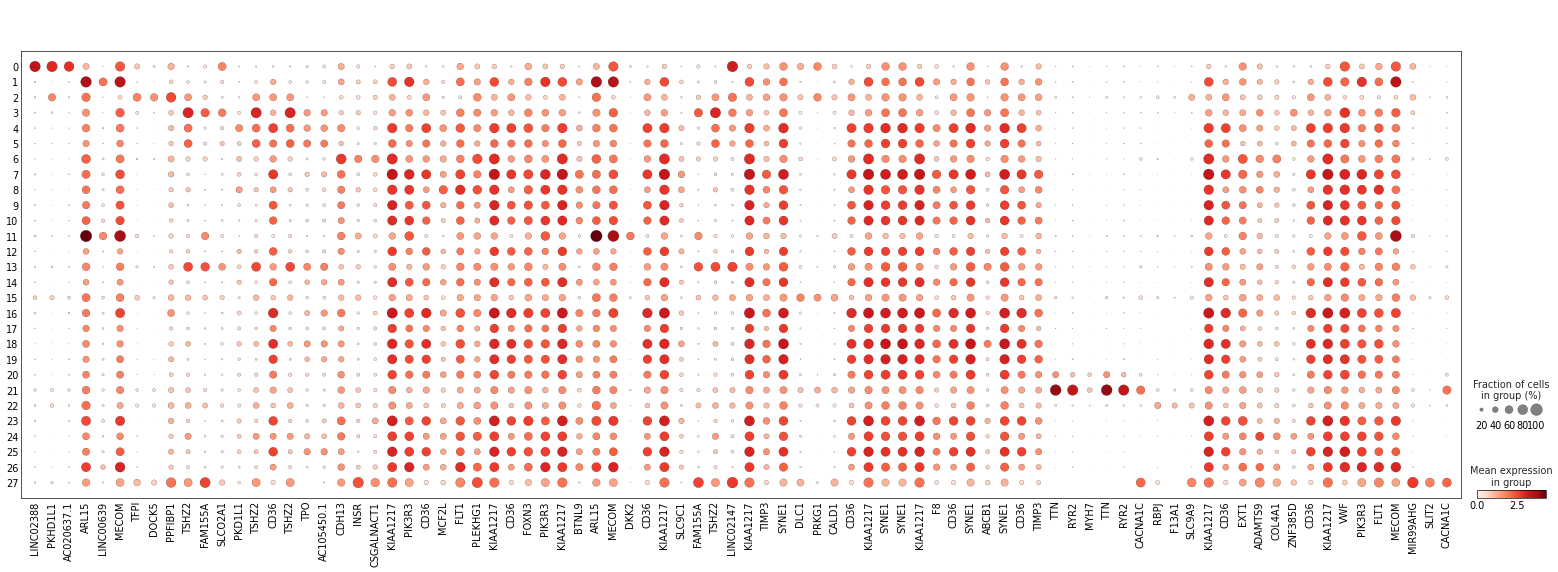

In [21]:
tplot = [k for j in [mymarkers[mymarkers['cluster']== i].sort_values('AUC',ascending=False).head(3)['names'].tolist() for i in mymarkers['cluster'].unique()] for k in j]
sc.pl.dotplot(adata, tplot, groupby='leiden' + str(i))

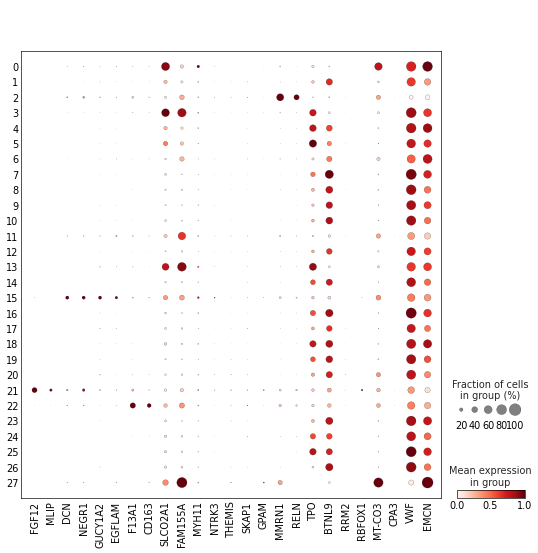

In [22]:
sc.pl.dotplot(adata, ['FGF12','MLIP','DCN','NEGR1','GUCY1A2','EGFLAM','F13A1','CD163','SLCO2A1','FAM155A',
                      'MYH11','NTRK3','THEMIS','SKAP1','GPAM','MMRN1','RELN','TPO','BTNL9',
                      'RRM2','RBFOX1','MT-CO3','CPA3','VWF','EMCN'], groupby='leiden'+str(i), standard_scale='var')

... storing 'outlier_color' as categorical


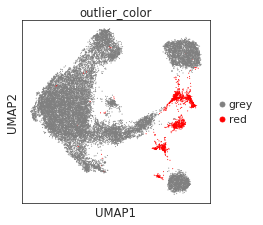

In [24]:
lowqual = ['15','21','22','27']
adata.obs['outlier'] = adata.obs['leiden' + str(i)].isin(lowqual)
adata.obs['outlier_color'] = ['red' if x else 'grey' for x in adata.obs['outlier']]
sc.pl.umap(adata, color = 'outlier_color', palette = ['grey','red'])

# Remove the low-quality sub-clusters

In [25]:
# The chosen resolution (can manually select a different if desired)
i = 1.6
cdata = sc.read(os.path.join(results_path, celltype + '/subcluster_map.h5ad'))

In [26]:
# Set cell type label and included leiden clusters
celltype = 'endothelial'
clusters = ['2','5','8','11']

In [27]:
# Read the snRNAseq map and subset to just the relevant cell type
adata = sc.read(os.path.join(path_aggregation, 'humanICM.PostQC.Map/PostQC.Neighbor.UMAP.Freeze1.h5ad'))
bdata = adata[adata.obs['leiden0.5'].isin(clusters)].copy()
print('Total number of ' + celltype + ' = ' + str(bdata.shape[0]))

Only considering the two last: ['.Freeze1', '.h5ad'].
Only considering the two last: ['.Freeze1', '.h5ad'].


Total number of endothelial = 20462


In [28]:
bdata = bdata[bdata.obs.index.isin(cdata.obs[~cdata.obs['leiden'+str(i)].isin(lowqual)].index)].copy()
print('Total number of ' + celltype + ' = ' + str(bdata.shape[0]))

Total number of endothelial = 19083


In [29]:
# Subcluster all nuclei
sdata, subclust, markers = subcluster(bdata = bdata,
                                      auc_stop = 0.6,
                                      n_neighbor = 10,
                                      incr = 0.1,
                                      min_res = 0.1,
                                      max_res = 2.0,
                                      regress_umi_mt = False)

Calculating highly variable genes
Log-normalizing
Not regressing out technical features


/home/unix/chaffin/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Calculating PCA
Harmonizing PCs
	Initialization is completed.
	Completed 1 / 20 iteration(s).
	Completed 2 / 20 iteration(s).
	Completed 3 / 20 iteration(s).
Reach convergence after 3 iteration(s).
Calculating new neighborhood graph...
Builing UMAP...
Iterating through different resolutions...
	0.1
5
	0.2
6
	0.3
7
	0.4
7
	0.5
9
	0.6
9
	0.7
11
	0.8
12
	0.9
13
	1.0
15
	1.1
18


In [30]:
# Save the markers for each resolution
for i in markers.keys():
    markers[i].to_csv(os.path.join(results_path, celltype + '/auc_markers_' + str(i) + '_v2.txt.gz'),
                      sep='\t', index=None, na_rep='NA', compression='gzip')

In [31]:
# Save the selected subcluster groupings
subclust.reset_index().to_csv(os.path.join(results_path, celltype + '/selected_subclusters_' + subclust.columns[0] + '_v2.txt.gz'),
                              sep='\t', index=None, na_rep='NA', compression='gzip')

In [32]:
# Save the full anndata with the new labels, as this has all the neighborhood and UMAP info
sdata.write(os.path.join(results_path, celltype + '/subcluster_map_v2.h5ad'))

In [33]:
# The chosen resolution (can manually select a different if desired)
i = 1.1

In [34]:
# Re-read expression
adata = sc.read(os.path.join(results_path, celltype + '/subcluster_map_v2.h5ad'))

In [35]:
mymarkers = pd.read_csv(os.path.join(results_path, celltype + '/auc_markers_' + str(round(i,1)) + '_v2.txt.gz'),
                    sep='\t')
print(mymarkers[mymarkers['AUC'] > 0.6]['cluster'].value_counts())

0     184
5     100
17     88
11     69
9      33
2      24
7      21
4      14
6      14
10     13
3      10
13      8
8       7
15      7
12      6
14      4
16      4
Name: cluster, dtype: int64


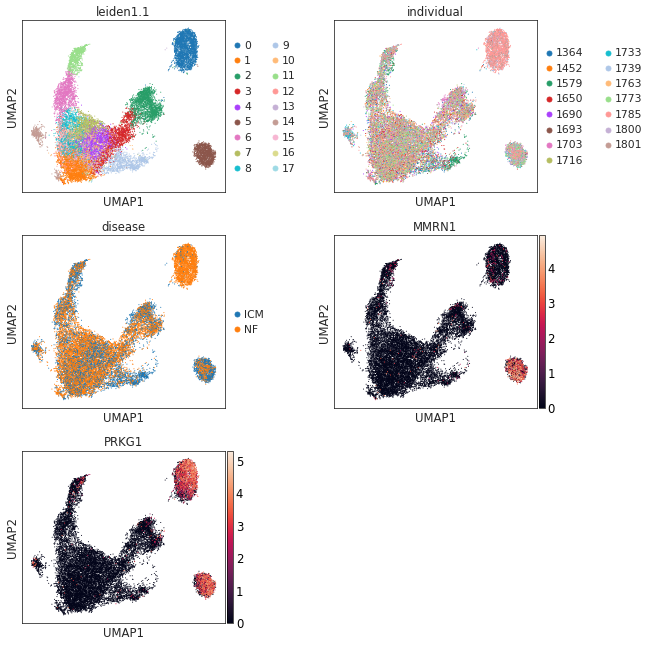

In [36]:
sc.set_figure_params(dpi=60)
sc.pl.umap(adata, color = ['leiden' + str(i), 'individual', 'disease','MMRN1','PRKG1'], ncols=2, wspace = .4)

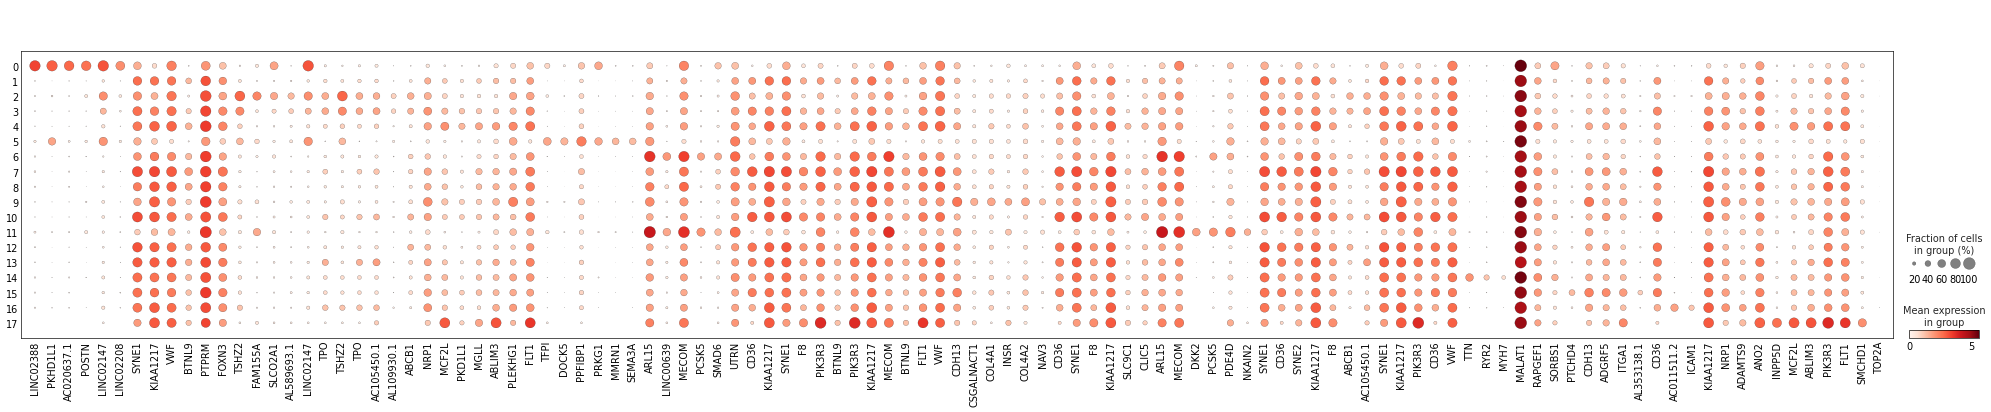

In [37]:
tplot = [k for j in [mymarkers[mymarkers['cluster']== i].sort_values('AUC',ascending=False).head(6)['names'].tolist() for i in mymarkers['cluster'].unique()] for k in j]
sc.pl.dotplot(adata, tplot + ['TOP2A'], groupby='leiden' + str(i))

In [38]:
lowqual2 = ['14']

# Second cleaning and re-iteration to remove further misclassified cells

In [39]:
# The chosen resolution (can manually select a different if desired)
i1= 1.6
i2 = 1.1
cdata1 = sc.read(os.path.join(results_path, celltype + '/subcluster_map.h5ad'))
cdata2 = sc.read(os.path.join(results_path, celltype + '/subcluster_map_v2.h5ad'))

In [40]:
# Set cell type label and included leiden clusters
celltype = 'endothelial'
clusters = ['2','5','8','11']

In [41]:
# Read the snRNAseq map and subset to just the relevant cell type
adata = sc.read(os.path.join(path_aggregation, 'humanICM.PostQC.Map/PostQC.Neighbor.UMAP.Freeze1.h5ad'))
bdata = adata[adata.obs['leiden0.5'].isin(clusters)].copy()
print('Total number of ' + celltype + ' = ' + str(bdata.shape[0]))

Only considering the two last: ['.Freeze1', '.h5ad'].
Only considering the two last: ['.Freeze1', '.h5ad'].


Total number of endothelial = 20462


In [42]:
bdata = bdata[bdata.obs.index.isin(cdata1.obs[~cdata1.obs['leiden'+str(i1)].isin(lowqual)].index)].copy()
bdata = bdata[bdata.obs.index.isin(cdata2.obs[~cdata2.obs['leiden'+str(i2)].isin(lowqual2)].index)].copy()
print('Total number of ' + celltype + ' = ' + str(bdata.shape[0]))

Total number of endothelial = 18636


In [43]:
# Subcluster all nuclei
sdata, subclust, markers = subcluster(bdata = bdata,
                                      auc_stop = 0.6,
                                      n_neighbor = 10,
                                      incr = 0.1,
                                      min_res = 0.1,
                                      max_res = 2.0,
                                      regress_umi_mt = False)

Calculating highly variable genes
Log-normalizing
Not regressing out technical features


/home/unix/chaffin/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Calculating PCA
Harmonizing PCs
	Initialization is completed.
	Completed 1 / 20 iteration(s).
	Completed 2 / 20 iteration(s).
	Completed 3 / 20 iteration(s).
Reach convergence after 3 iteration(s).
Calculating new neighborhood graph...
Builing UMAP...
Iterating through different resolutions...
	0.1
5
	0.2
6
	0.3
6
	0.4
6
	0.5
8
	0.6
8
	0.7
9
	0.8
12
	0.9
13
	1.0
15
	1.1
14
	1.2
15
	1.3
18
	1.4
21
	1.5
24
	1.6
25
	1.7
28


In [44]:
# Save the markers for each resolution
for i in markers.keys():
    markers[i].to_csv(os.path.join(results_path, celltype + '/auc_markers_' + str(i) + '_v3.txt.gz'),
                      sep='\t', index=None, na_rep='NA', compression='gzip')

In [45]:
# Save the selected subcluster groupings
subclust.reset_index().to_csv(os.path.join(results_path, celltype + '/selected_subclusters_' + subclust.columns[0] + '_v3.txt.gz'),
                              sep='\t', index=None, na_rep='NA', compression='gzip')

In [46]:
# Save the full anndata with the new labels, as this has all the neighborhood and UMAP info
sdata.write(os.path.join(results_path, celltype + '/subcluster_map_v3.h5ad'))

In [47]:
# The chosen resolution (can manually select a different if desired)
i = 1.7

In [48]:
# Re-read expression
adata = sc.read(os.path.join(results_path, celltype + '/subcluster_map_v3.h5ad'))

In [49]:
mymarkers = pd.read_csv(os.path.join(results_path, celltype + '/auc_markers_' + str(round(i,1)) + '_v3.txt.gz'),
                    sep='\t')
print(mymarkers[mymarkers['AUC'] > 0.6]['cluster'].value_counts())

0     187
23    158
2     101
6      67
4      42
5      29
16     25
8      23
24     19
11     19
19     18
26     17
12     15
1      14
22     11
3      10
25      9
27      8
10      8
9       8
17      7
18      6
20      6
15      5
13      4
21      3
7       1
Name: cluster, dtype: int64


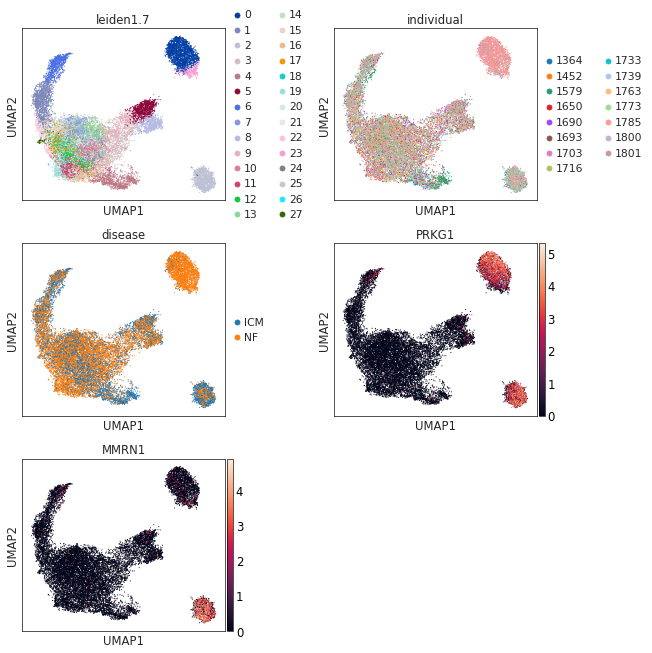

In [51]:
sc.set_figure_params(dpi=60)
sc.pl.umap(adata, color = ['leiden' + str(i), 'individual', 'disease','PRKG1','MMRN1'], ncols=2, wspace = .4)

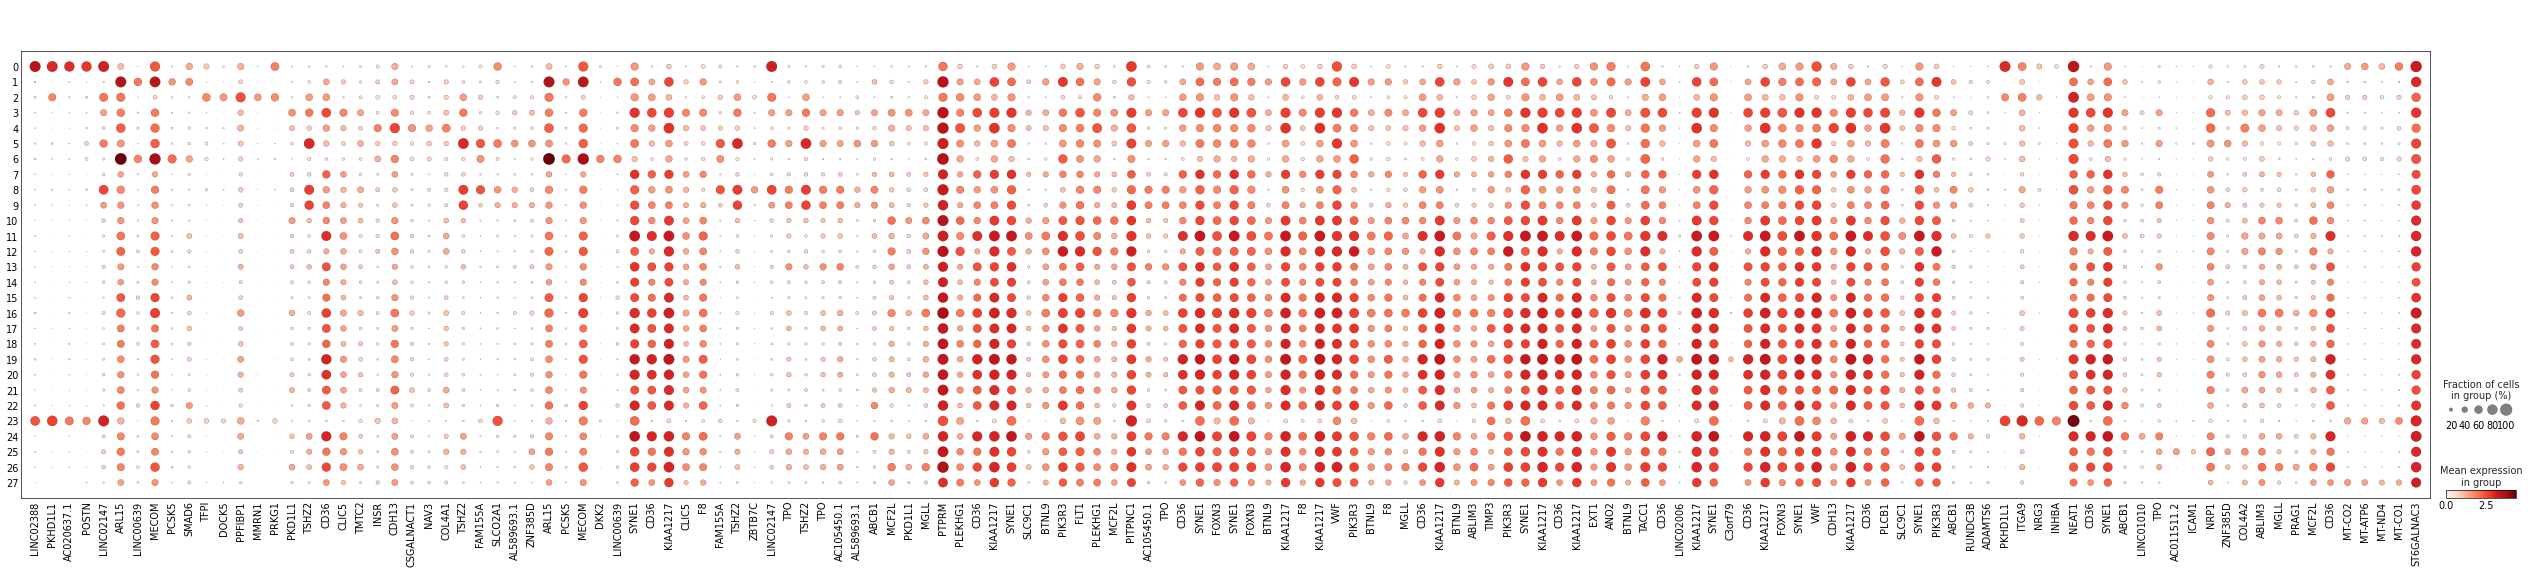

In [52]:
tplot = [k for j in [mymarkers[mymarkers['cluster']== i].sort_values('AUC',ascending=False).head(5)['names'].tolist() for i in mymarkers['cluster'].unique()] for k in j]
sc.pl.dotplot(adata, tplot, groupby='leiden' + str(i))

# Merge similar clusters

In [53]:
# The chosen resolution (can manually select a different if desired)
i = 1.7

In [54]:
# Re-read expression
adata = sc.read(os.path.join(results_path, celltype + '/subcluster_map_v3.h5ad'))
print(adata.shape)

(18636, 2000)


In [55]:
# Data is already scaled from the clustering procedure so we can use this as input
expr = pd.DataFrame(pd.DataFrame(adata.X))
expr['cluster'] = [int(x) for x in adata.obs['leiden'+str(i)].tolist()]
expr = expr.sort_values('cluster')
expr['cluster'] = ['C' + str(x) for x in expr['cluster']]
centroid = expr.groupby('cluster').mean()

... storing 'cluster_merge' as categorical


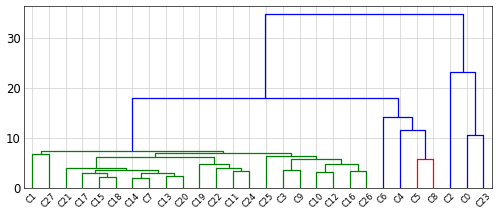

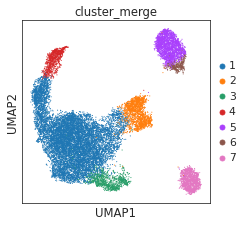

In [56]:
# Generate a dendrogram
Z = shc.linkage(centroid, method='ward')
grps = shc.fcluster(shc.linkage(centroid, method='ward'),0.25*max(Z[:,2]),'distance')
clust_merge = {x.split('C')[1]:y for x,y in zip(centroid.index,grps)}
adata.obs['cluster_merge'] = [str(clust_merge[x]) for x in adata.obs['leiden'+str(i)]]
plt.figure(figsize=(10, 4)) 
dend = shc.dendrogram(Z, labels = centroid.index, color_threshold=0.25*max(Z[:,2]))
sc.pl.umap(adata, color = 'cluster_merge')

**markers of the merged clusters**

In [57]:
adata.raw.shape

(18636, 36601)

In [58]:
# find markers
sc.tl.rank_genes_groups(adata, 'cluster_merge', method='wilcoxon', n_genes = adata.raw.shape[1], use_raw = True)
# Convert markers to datatable
allmerge = []
for q in range(len(adata.obs['cluster_merge'].unique())):
    forframe = {}
    for i in adata.uns['rank_genes_groups'].keys():
        if i =='params':
            continue
        newcol = []
        sub = adata.uns['rank_genes_groups'][i].tolist()
        for s in sub:
            newcol.append(s[q])
        forframe[i] = newcol
    wilcox = pd.DataFrame(forframe)
    wilcox['cluster'] = adata.uns['rank_genes_groups']['names'].dtype.names[q]
    allmerge.append(wilcox)
fullresults = pd.concat(allmerge)
nlookup = pd.DataFrame(adata.obs['cluster_merge'].value_counts()).reset_index()
nlookup.columns = ['cluster', 'n1']
n2_v = []
for i in nlookup['cluster']:
    n2_v.append(nlookup[nlookup['cluster']!=i]['n1'].sum())
nlookup['n2'] = n2_v
nlookup['cluster'] = [x for x in nlookup['cluster']]
fullresults = fullresults.merge(nlookup, on = 'cluster', how='left')
fullresults['U'] = (fullresults['scores'] * np.sqrt((fullresults['n1']*fullresults['n2']*(fullresults['n1'] + fullresults['n2'] + 1)) / 12)) + ((fullresults['n1'] * fullresults['n2']) / 2)
fullresults['AUC'] = fullresults['U']/(fullresults['n1'] * fullresults['n2'])

In [59]:
# Save the markers for each resolution
fullresults.to_csv(os.path.join(results_path, celltype + '/auc_markers_merged_clusters.txt.gz'),
                      sep='\t', index=None, na_rep='NA', compression='gzip')

# Save the selected subcluster groupings
adata.obs.reset_index()[['index','cluster_merge']].reset_index().to_csv(os.path.join(results_path, celltype + '/selected_subclusters_merged_clusters.txt.gz'),
                              sep='\t', index=None, na_rep='NA', compression='gzip')

# Save the full anndata with the new labels, as this has all the neighborhood and UMAP info
adata.write(os.path.join(results_path, celltype + '/subcluster_map_merged_clusters.h5ad'))

# Limma-voom markers -- we already have AUC derived markers, but a formal limma-voom test will allow us to account for heterogeneity between samples

In [60]:
# Re-read full expression and append the desired groups
bdata = sc.read(os.path.join(path_aggregation, 'humanICM.PostQC.Map/PostQC.Neighbor.UMAP.Freeze1.h5ad'))
subclusters = pd.read_csv(os.path.join(results_path, celltype + '/selected_subclusters_merged_clusters.txt.gz'),
                          sep='\t')
submap = {x:str(y) for x,y in zip(subclusters['index'], subclusters['cluster_merge'])}
bdata = bdata[bdata.obs.index.isin(subclusters['index'])].copy()
bdata.obs['subcluster'] = [submap[x] for x in bdata.obs.index]
bdata.obs['subcluster'].value_counts()

Only considering the two last: ['.Freeze1', '.h5ad'].
Only considering the two last: ['.Freeze1', '.h5ad'].


1    11241
5     2160
2     1704
7     1324
3      990
4      879
6      338
Name: subcluster, dtype: int64

In [61]:
# Get a tabulation of number of cells from each sample in each cluster
# Determine which samples to aggregate within each cluster
# For exceptionally rare clusters, this aggregation will be problematic
# We will insist that a cluster have a minimum of 20 nuclei to be summed
ct = pd.crosstab(bdata.obs['subcluster'], bdata.obs['individual'])
ind_dict = {}
for cell_type in ct.columns:
    sub = ct[ct[cell_type] > 20]
    ind_dict[cell_type] = sub.index.tolist()

In [62]:
# The clusters included for each sample
ind_dict

{'1364': ['1', '2', '3', '4', '7'],
 '1452': ['1', '2', '4', '5'],
 '1579': ['1', '2', '3', '4', '5', '7'],
 '1650': ['1', '2', '3', '4', '5', '7'],
 '1690': ['1', '2', '3', '4', '7'],
 '1693': ['1', '2', '3', '4', '7'],
 '1703': ['1', '2', '3', '4', '5', '7'],
 '1716': ['1', '2', '4', '7'],
 '1733': ['1', '2', '3', '4', '7'],
 '1739': ['1', '2', '4', '5', '6', '7'],
 '1763': ['1', '2', '3', '4', '7'],
 '1773': ['1', '2', '3', '4', '5', '7'],
 '1785': ['1', '2', '3', '4', '5', '6', '7'],
 '1800': ['1', '2', '3', '4', '5', '7'],
 '1801': ['1', '2', '4', '5', '6']}

In [63]:
# Sum across all nuclei of each cluster above, for each sample
tocat = []
for ind in bdata.obs['individual'].unique():
    sdata = bdata[bdata.obs['individual'] == ind].copy()
    for ct in ind_dict[ind]:
        out = pd.DataFrame(sdata[sdata.obs['subcluster']==ct].X.sum(0)).transpose()
        out.columns = [ind + '_' + ct]
        tocat.append(out)
finalout = pd.concat(tocat, axis = 1)
finalout.index = bdata.var.index.tolist()
for x in finalout.columns:
    finalout[x] = [int(y) for y in finalout[x]]

In [64]:
# Convert pandas dataframe into R
with localconverter(ro.default_converter + pandas2ri.converter):
    all_counts = ro.conversion.py2rpy(finalout)

In [65]:
# Get a vector with the cluster group and a vector with the individual label
ind_group = base.strsplit(all_counts.colnames, split='_')
individual = ro.FactorVector([base.unlist(ind_group)[x] for x in range(0,finalout.shape[1]*2,2)])
cluster = ro.StrVector([base.unlist(ind_group)[x] for x in range(1,finalout.shape[1]*2,2)])

In [66]:
# Use edgeR filterByExpr to filter out genes too lowly expressed to test
keep_exprs = edgeR.filterByExpr(all_counts, group=cluster)
all_counts = all_counts.rx(keep_exprs, True )
print(ro.r.dim(all_counts))

[1] 5339   81



In [67]:
# Look at the number of samples included for each cluster
print(ro.r.table(cluster))


 1  2  3  4  5  6  7 
15 15 11 15  9  3 13 



In [68]:
# Set up the design
ro.r.assign('individual', individual)
ro.r.assign('cluster', cluster)
ro.r('individual <- as.factor(individual)')
ro.r('cluster <- as.factor(cluster)')
ro.r('design <- model.matrix(~ 0 + cluster + individual)')

# set up contrasts
tocat = []
cluster_ids = set([x.split('_')[-1] for x in finalout.columns])
for i in sorted(cluster_ids):
    ref_comp = []
    for j in sorted(cluster_ids):
        if j == i:
            continue
        ref_comp.append('cluster' + str(j))
    contr = 'C' + str(i) + 'vsALL=cluster' + str(i) + '-(' + '+'.join(ref_comp) + ')/' + str(len(cluster_ids)-1)
    tocat.append(contr)
contr_string = 'contr.matrix <- makeContrasts(' + ', '.join(tocat) + ', levels=colnames(design))'
ro.r(contr_string)

R object with classes: ('matrix',) mapped to:
[1.000000, -0.166667, -0.166667, -0.166667, ..., 0.000000, 0.000000, 0.000000, 0.000000]

In [69]:
# Normalize data
ro.r.assign('all_counts', all_counts)
sf = DESeq2.estimateSizeFactorsForMatrix(all_counts) # DESeq2 normalization
ro.r.assign('sf', sf)
ro.r('eff.lib <- sf*mean(colSums(all_counts))')

R object with classes: ('numeric',) mapped to:
[759616.810857, 199166.703388, 214565.418147, 63709.145308, ..., 157411.559209, 49224.431122, 277806.856658, 67046.603058]

In [70]:
# Run Voom
ro.r('y <- DGEList(all_counts, lib.size=eff.lib)')
grdevices.pdf(file=os.path.join(results_path, celltype + '/subcluster_merged_clusters.voom.pdf'))
ro.r('v.all <- voomWithQualityWeights(y, design, plot=T)')
grdevices.dev_off()

R object with classes: ('RTYPES.INTSXP',) mapped to:
[1]

In [71]:
# Fit the model
ro.r('vfit <- lmFit(v.all, design)')
ro.r('vfit <- contrasts.fit(vfit, contrasts=contr.matrix)')
ro.r('vfit <- eBayes(vfit, robust=TRUE)')
print('model fit...')

model fit...


In [72]:
# Compile the results from each contrast into a dataframe
# Save this output
tocat = []
for contr in np.array(ro.r('colnames(contr.matrix)')):
    ro.r('vres <- topTable(vfit, coef="' + contr + '", n=Inf, sort.by="P")')
    with localconverter(ro.default_converter + pandas2ri.converter):
        pd_from_r_df = ro.conversion.rpy2py(ro.r('vres'))
    pd_from_r_df['contrast'] = contr
    tocat.append(pd_from_r_df)
limma_voom_results = pd.concat(tocat)
limma_voom_results.reset_index().to_csv(os.path.join(results_path, celltype + '/subcluster_merged_clusters.limmavoom.markers.txt'),
                          sep='\t',index=None,na_rep='NA')

In [73]:
# Extra Voom diagnostic (SAplot)
grdevices.pdf(file=os.path.join(results_path, celltype + '/subcluster_merged_clusters.plotSA.pdf'))
ro.r('plotSA(vfit)')
grdevices.dev_off()

R object with classes: ('RTYPES.INTSXP',) mapped to:
[1]

# Pct Expression

In [74]:
# Re-read full expression and append the desired groups
bdata = sc.read(os.path.join(path_aggregation, 'humanICM.PostQC.Map/PostQC.Neighbor.UMAP.Freeze1.h5ad'))
subclusters = pd.read_csv(os.path.join(results_path, celltype + '/selected_subclusters_merged_clusters.txt.gz'),
                          sep='\t')
submap = {x:str(y) for x,y in zip(subclusters['index'], subclusters['cluster_merge'])}
bdata = bdata[bdata.obs.index.isin(subclusters['index'])].copy()
bdata.obs['subcluster'] = [submap[x] for x in bdata.obs.index]
bdata.obs['subcluster'].value_counts()

Only considering the two last: ['.Freeze1', '.h5ad'].
Only considering the two last: ['.Freeze1', '.h5ad'].


1    11241
5     2160
2     1704
7     1324
3      990
4      879
6      338
Name: subcluster, dtype: int64

In [75]:
bdata.obs['subcluster'] =  pd.Categorical(bdata.obs['subcluster'])

In [76]:
# Log-Normalize Data
sc.pp.normalize_total(bdata, target_sum = 1e4)
sc.pp.log1p(bdata)

In [77]:
def calculate_pct_expr(adata, cluster_key, subgroup_key):
    '''
    adata: adata object
    cluster_key: the .obs key representing the cluster
    '''
    # Base data to derive the desired metrics
    tocat = []
    for clst in adata.obs[cluster_key].cat.categories:
        print(clst)
        # PCT > 0
        base = pd.DataFrame((adata[adata.obs[cluster_key]==clst].X > 0).sum(0)).transpose()
        base.columns = ['all.n.gt0.'+clst]
        base.index = adata.var.index
        for grp in adata.obs[subgroup_key].cat.categories:
            toappend = pd.DataFrame((adata[(adata.obs[cluster_key]==clst)&(adata.obs[subgroup_key]==grp)].X > 0).sum(0)).transpose()
            toappend.columns = [grp+'.n.gt0.'+clst]
            toappend.index = adata.var.index
            base = pd.concat([base, toappend], axis = 1)
        # AVG EXPR
        base2 = pd.DataFrame((adata[adata.obs[cluster_key]==clst].X).sum(0)).transpose()
        base2.columns = ['all.sumexp.'+clst]
        base2.index = adata.var.index
        base = pd.concat([base, base2], axis = 1)
        for grp in adata.obs[subgroup_key].cat.categories:
            toappend = pd.DataFrame((adata[(adata.obs[cluster_key]==clst)&(adata.obs[subgroup_key]==grp)].X).sum(0)).transpose()
            toappend.columns = [grp+'.sumexp.'+clst]
            toappend.index = adata.var.index
            base = pd.concat([base, toappend], axis = 1)        
        tocat.append(base)
    ref_data = pd.concat(tocat, axis = 1)
    tocat = []
    for clst in adata.obs[cluster_key].cat.categories:
        # compile the PCT > 0 for each cluster
        tomerge = []
        for grp in ['all'] + adata.obs[subgroup_key].cat.categories.tolist():
            base = ref_data[[grp+'.n.gt0.'+clst]].copy()
            if grp == 'all':
                base[grp+'.pct.gt0.target'] = ref_data[[grp+'.n.gt0.'+clst]]/adata[(adata.obs[cluster_key]==clst)].shape[0]
                base[grp+'.pct.gt0.nontarget'] = ref_data[[x for x in ref_data.columns 
                                                      if re.search(grp+'\.n\.gt0',x) and x != grp+'.n.gt0.'+clst]].sum(1) / \
                                                 adata.obs[(adata.obs[cluster_key]!=clst)].shape[0]
            else:
                base[grp+'.pct.gt0.target'] = ref_data[[grp+'.n.gt0.'+clst]]/adata[(adata.obs[cluster_key]==clst)&
                                                                                   (adata.obs[subgroup_key]==grp)].shape[0]
                base[grp+'.pct.gt0.nontarget'] = ref_data[[x for x in ref_data.columns 
                                                      if re.search(grp+'\.n\.gt0',x) and x != grp+'.n.gt0.'+clst]].sum(1) / \
                                                 adata.obs[(adata.obs[cluster_key]!=clst)&
                                                           (adata.obs[subgroup_key]==grp)].shape[0]
            base = base[[grp+'.pct.gt0.target',grp+'.pct.gt0.nontarget']]
            base.columns = [grp+'.pct.gt0.target',grp+'.pct.gt0.nontarget']
            tomerge.append(base)
        # compile the avg expr for each cluster
        for grp in ['all'] + adata.obs[subgroup_key].cat.categories.tolist():
            base = ref_data[[grp + '.sumexp.' + clst]].copy()
            if grp == 'all':
                base[grp+'.avg.expr.target'] = ref_data[[grp + '.sumexp.' + clst]]/adata[(adata.obs[cluster_key]==clst)].shape[0]
                base[grp+'.avg.expr.nontarget'] = ref_data[[x for x in ref_data.columns 
                                                      if re.search(grp+'\.sumexp',x) and x != grp+'.sumexp.'+clst]].sum(1) / \
                                                 adata.obs[(adata.obs[cluster_key]!=clst)].shape[0]        
            else:
                base[grp+'.avg.expr.target'] = ref_data[[grp + '.sumexp.' + clst]]/adata[(adata.obs[cluster_key]==clst)&
                                                                                         (adata.obs[subgroup_key]==grp)].shape[0]
                base[grp+'.avg.expr.nontarget'] = ref_data[[x for x in ref_data.columns 
                                                      if re.search(grp+'\.sumexp',x) and x != grp+'.sumexp.'+clst]].sum(1) / \
                                                 adata.obs[(adata.obs[cluster_key]!=clst)&
                                                           (adata.obs[subgroup_key]==grp)].shape[0]   
            base = base[[grp+'.avg.expr.target',grp+'.avg.expr.nontarget']]
            base.columns = [grp+'.avg.expr.target',grp+'.avg.expr.nontarget']
            tomerge.append(base)
        # just some reorganizing
        aggregated = pd.concat(tomerge, axis = 1)
        aggregated['cluster'] = clst
        aggregated = aggregated[['cluster'] + [x for x in aggregated.columns if not x == 'cluster']]
        tocat.append(aggregated)
    all_results = pd.concat(tocat)
    return(all_results)

In [78]:
# Caclulate the percent of nuclei with non-zero expression and the average log-normalized expression
# for each gene across all nuclei, disease nuclei, and healthy nuclei
pct_avgexp = calculate_pct_expr(bdata, 'subcluster', 'disease')

1
2
3
4
5
6
7


In [79]:
# Save the output file
pct_avgexp.reset_index().to_csv(os.path.join(results_path, celltype + '/subcluster_merged_clusters_pctavg_expr.txt.gz'),
                                sep='\t', index=None, na_rep='NA', compression='gzip')

# Compile markers

In [80]:
# Re-read full expression and append the desired groups
bdata = sc.read(os.path.join(path_aggregation, 'humanICM.PostQC.Map/PostQC.Neighbor.UMAP.Freeze1.h5ad'))
subclusters = pd.read_csv(os.path.join(results_path, celltype + '/selected_subclusters_merged_clusters.txt.gz'),
                          sep='\t')
submap = {x:str(y) for x,y in zip(subclusters['index'], subclusters['cluster_merge'])}
bdata = bdata[bdata.obs.index.isin(subclusters['index'])].copy()
bdata.obs['subcluster'] = [submap[x] for x in bdata.obs.index]
bdata.obs['subcluster'].value_counts()

Only considering the two last: ['.Freeze1', '.h5ad'].
Only considering the two last: ['.Freeze1', '.h5ad'].


1    11241
5     2160
2     1704
7     1324
3      990
4      879
6      338
Name: subcluster, dtype: int64

In [81]:
sc.pp.normalize_total(bdata, 1e4)
sc.pp.log1p(bdata)

In [82]:
# cell-level markers
auc_markers = pd.read_csv(os.path.join(results_path, celltype + '/auc_markers_merged_clusters.txt.gz'), sep='\t')

In [83]:
# voom-level markers
limmares = pd.read_csv(os.path.join(results_path, celltype + '/subcluster_merged_clusters.limmavoom.markers.txt'),
                    sep='\t')
limmares['cluster'] = [int(x.split('vs')[0].split('C')[1]) for x in limmares['contrast']]
voom_markers = limmares.copy()

In [84]:
# gtf
gtf = pd.read_csv(gtf_path, sep='\t', header=None)
gtf['gene_id'] = [[y for y in x.split(';') if re.search('gene_id',y)][0].split(' ')[1].split('\"')[1] for x in gtf[8]]
gtf['gene_type'] = [[y for y in x.split(';') if re.search('gene_type',y)][0].split(' ')[-1].split('\"')[1] for x in gtf[8]]
gtf = gtf.merge(bdata.var.reset_index()[['index','gene_ids']], left_on='gene_id', right_on='gene_ids', how='left')

In [85]:
# PCTs
pct = pd.read_csv(os.path.join(results_path, celltype + '/subcluster_merged_clusters_pctavg_expr.txt.gz'), sep='\t')

In [86]:
# Avg Expression
avg_expr = pd.read_csv(os.path.join(results_path, celltype + '/subcluster_merged_clusters_pctavg_expr.txt.gz'), sep='\t')

In [87]:
# All markers
tocat = []
for cluster in auc_markers['cluster'].unique():
    base = auc_markers[(auc_markers['cluster']==cluster)]
    base = base.merge(voom_markers[voom_markers['cluster']==cluster], left_on='names', right_on='index', how='left')
    base = base.merge(pct[pct['cluster']==cluster], left_on='names', right_on='index', how='left')
    base = base.merge(gtf[['index','gene_type','gene_id']].drop_duplicates(), left_on='names', right_on='index', how='left')
    base['n_nuclei'] = bdata.obs[bdata.obs['subcluster']==str(cluster)].shape[0]
    base['mycluster'] = cluster
    base = base[['names','gene_id','gene_type','mycluster','n_nuclei','all.pct.gt0.target','all.pct.gt0.nontarget',
                 'all.avg.expr.target','all.avg.expr.nontarget','AUC','logFC','t','P.Value','adj.P.Val']]
    base.columns = ['gene', 'ensembl', 'gene_type', 'cluster', 'n_nuclei', 'pct.gt0.target', 'pct.gt0.nontarget',
                    'avg.expr.target', 'avg.expr.nontarget', 'AUC', 'limma_voom.logFC', 'limma_voom.P.Value',
                    'limma_voom.t','limma_voom.adj.P.Val']
    base = base.sort_values('limma_voom.logFC',ascending=False)
    tocat.append(base)
allmarkers = pd.concat(tocat)
allmarkers['cluster'].value_counts()

1    36601
2    36601
3    36601
4    36601
5    36601
6    36601
7    36601
Name: cluster, dtype: int64

In [88]:
allmarkers.to_csv(os.path.join(results_path, celltype + '/subcluster_merged_clusters_allmarkers.txt'),
                            sep='\t', index=None, na_rep='NA')

In [89]:
rare_pop = []

In [90]:
# Significant markers
markers = allmarkers[((~allmarkers['cluster'].isin(rare_pop))&
                      (allmarkers['gene_type'] == 'protein_coding') &
                      (allmarkers['pct.gt0.target'] > 0.15) &
                      (allmarkers['AUC'] > 0.5) &
                      (allmarkers['limma_voom.logFC'] > 0) &
                      (allmarkers['limma_voom.adj.P.Val'] < 0.01))|
                     ((allmarkers['cluster'].isin(rare_pop))&
                      (allmarkers['gene_type'] == 'protein_coding') &
                      (allmarkers['pct.gt0.target'] > 0.15) &
                      (allmarkers['AUC'] > 0.6))]

In [91]:
markers['cluster'].value_counts()

7    341
4    274
3    249
5    239
1    207
6    153
2    152
Name: cluster, dtype: int64

In [92]:
markers.to_csv(os.path.join(results_path, celltype + '/subcluster_merged_clusters_markers.txt'),
                            sep='\t', index=None, na_rep='NA')

... storing 'subcluster' as categorical


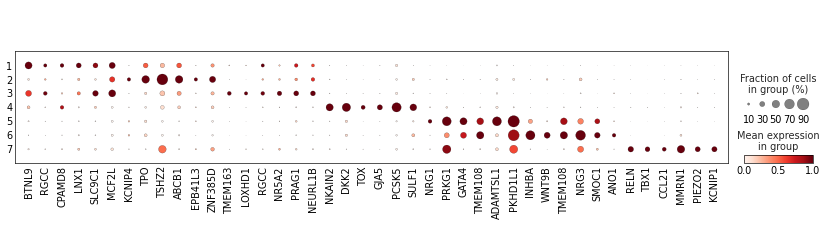

In [93]:
# Plot the top 5 genes for each cluster just to make sure they look good!
gplot = [x for y in [markers[markers['cluster']==i].head(6)['gene'].tolist() for i in range(markers['cluster'].value_counts().shape[0]+1)] for x in y]
sc.pl.dotplot(bdata, gplot, groupby='subcluster', standard_scale='var')

# Gene Ontology

In [12]:
markers = pd.read_csv(os.path.join(results_path, celltype + '/subcluster_merged_clusters_allmarkers.txt'),
                      sep='\t')

In [13]:
# Function to run the ontology enrichment for each cell type
def run_topgo(summary_stats, gene_key, rank_key, group_key, algorithm, nodesize, max_size):
    '''
    summary_stats: the summary stats with gene_key, rank_key, and group_key
    gene_key: the column in summary_stats with the "gene_name" (e.g., RYR2, TTN)
    rank_key: the column in summary_stats with the metric to rank the genes on.
              This should be coded such that higher values indicate more relevant
    group_key: the column in summary_stats to select the genes to go into the fisher
               test. Should be a True/False boolean
    algorithm: The algoirthm for topGO. Should be compatible with both the fisher and ks
               methods (i.e., classic, elim, weight01, lea)
    nodesize: the minimum nodeSize to cosider for an ontology in topGO
    max_size: A post-hoc filter for removal of ontologies/pathways > max_size
    '''
    # Set up for the over-representation test
    print('\tPrepping for over-representation and GSEA tests:')

    # Get the target genelist and gene universe into R
    target = ro.StrVector(summary_stats[summary_stats[group_key]][gene_key].tolist())
    ro.r.assign('target', target)
    uni = ro.StrVector(summary_stats[~pd.isnull(summary_stats[rank_key])][gene_key].tolist())
    ro.r.assign('universe', uni)
    
    # Get the ranking statistic
    ranking = ro.FloatVector(summary_stats[~pd.isnull(summary_stats[rank_key])][rank_key].tolist())
    ro.r.assign('ranks', ranking)
    ro.r('names(ranks) <- universe') # assigning the appropriate names to the ranking
    
    print('\t\tNumber of genes in target = ' + str(ro.r('length(target)')))
    print('\t\tNumber of genes in universe = ' + str(ro.r('length(universe)')))
    
    '''
    set up topGO object
    This include both the ranking, and the "significant" gene group
    Because by default topGO only allows us to select genes for the "over-representation"
    style test using the one ranking metric, we've created a hacky solution to work around this.
    In the "sigGenes" and "numSigGenes" methods, we've hardcoded it to take the "ranks" object which retains
    the names() of the genes such that the selFun() can select the appropriate genes for the
    enrichment test
    '''
    ro.r('selFun <- function(allScore){x <- names(allScore) %in% target\n ' + \
                                       'names(x) <- names(allScore)\n' + \
                                       'return(x)}')
    ro.r('setMethod("sigGenes", "topGOdata",\n' + \
              'function(object) {\n' + \
              '  sGenesIndex <- object@geneSelectionFun(ranks) & object@feasible\n' + \
              '  return(object@allGenes[sGenesIndex])\n' + \
              '})')
    ro.r('setMethod("numSigGenes", "topGOdata",\n' + \
                   'function(object) {return(sum(object@geneSelectionFun(ranks) & object@feasible))})')
    ro.r('GOdata=new("topGOdata", ontology="BP", allGenes = ranks, geneSel = selFun, annot = annFUN.org, ' + \
        'mapping = "org.Hs.eg.db", ID = "symbol", nodeSize = ' + str(nodesize) + ')')
    
    # Running the tests
    print('\t\tRunning enrichment tests')
    ro.r('resultFisher=runTest(GOdata, algorithm="' + algorithm + '", statistic="fisher")')
    ro.r('resultKS=runTest(GOdata, algorithm="' + algorithm + '", statistic="ks", scoreOrder = "decreasing")')

    # Make final output results
    ro.r('allGO=usedGO(GOdata)')
    ro.r('all_res=GenTable(GOdata, weightFisher=resultFisher, weightKS=resultKS, orderBy="weightFisher", ' + \
         'topNodes=length(allGO), numChar=1000)')
    # convert back to pandas
    with localconverter(ro.default_converter + pandas2ri.converter):
        all_res = ro.conversion.rpy2py(ro.r('all_res'))
    # Remove ontologies/pathways greater than maximum size
    all_res = all_res[all_res['Annotated'] < max_size]
    
    # derive the odds ratio for enrichment for the fisher test
    with localconverter(ro.default_converter + pandas2ri.converter):
        sig_genes = ro.conversion.rpy2py(ro.r('numSigGenes(GOdata)'))[0]
    with localconverter(ro.default_converter + pandas2ri.converter):
        total_genes = ro.conversion.rpy2py(ro.r('sum(feasible(GOdata))'))[0]
    all_res['fisher.OR'] = (all_res['Significant'] * ((total_genes - sig_genes) - (all_res['Annotated'] - all_res['Significant'])) )/ \
                           ((all_res['Annotated'] - all_res['Significant']) * (sig_genes - all_res['Significant']))
    
    # Clean up labels
    all_res = all_res[['GO.ID', 'Term', 'Annotated', 'Significant', 'Expected', 'fisher.OR', 'weightFisher',
                     'weightKS']]
    all_res.columns = ['go_id', 'term', 'genes_in_ontology', 'fisher_significant_in_ontology',
                       'fisher_expected_in_ontology', 'fisher_or', 'fisher_p', 'ks_p']
    return(all_res)

In [14]:
rare_pop = []

In [16]:
markers['cluster'].value_counts()

1    36601
2    36601
3    36601
4    36601
5    36601
6    36601
7    36601
Name: cluster, dtype: int64

In [17]:
tocat = []
for cluster in markers['cluster'].unique():
    print('Cluster = ' + str(cluster))
    submarkers = markers[(markers['cluster']==cluster)&
                         (markers['gene_type'] == 'protein_coding')].copy()
    # Criteria for "marker genes"
    if cluster in rare_pop:
        submarkers['sig_marker'] = (submarkers['gene_type'] == 'protein_coding') &\
                                   (submarkers['pct.gt0.target'] > 0.15) &\
                                   (submarkers['AUC'] > 0.6)        
        print('\tSignificant markers for over-representation test = ' + str(submarkers['sig_marker'].sum()))

        res = run_topgo(summary_stats = submarkers,
                        gene_key = 'gene',
                        rank_key = 'AUC',
                        group_key = 'sig_marker',
                        algorithm = 'weight01',
                        nodesize = 15,
                        max_size = 500)
    else:
        submarkers['sig_marker'] = (submarkers['gene_type'] == 'protein_coding') &\
                                   (submarkers['pct.gt0.target'] > 0.15) &\
                                   (submarkers['AUC'] > 0.5) &\
                                   (submarkers['limma_voom.logFC'] > 0) & \
                                   (submarkers['limma_voom.adj.P.Val'] < 0.01)
        print('\tSignificant markers for over-representation test = ' + str(submarkers['sig_marker'].sum()))

        res = run_topgo(summary_stats = submarkers,
                        gene_key = 'gene',
                        rank_key = 'limma_voom.t',
                        group_key = 'sig_marker',
                        algorithm = 'weight01',
                        nodesize = 15,
                        max_size = 500)
    res['cluster'] = cluster
    tocat.append(res)
    
complete_enrichment = pd.concat(tocat)

R[write to console]: 
Building most specific GOs .....



Cluster = 1
	Significant markers for over-representation test = 207
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 207

		Number of genes in universe = [1] 4845



R[write to console]: 	( 7977 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 11967 GO terms and 27526 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 4474 genes annotated to the GO terms. )



		Running enrichment tests


R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 2616 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 16:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 15:	11 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 14:	25 nodes to be scored	(65 eliminated genes)

R[write to console]: 
	 Level 13:	41 nodes to be scored	(177 eliminated genes)

R[write to console]: 
	 Level 12:	80 nodes to be scored	(545 eliminated genes)

R[write to console]: 
	 Level 11:	131 nodes to be scored	(1285 eliminated genes)

R[write to console]: 
	 Level 10:	231 nodes to be scored	(1877 eliminated genes)

R[write to console]: 
	 Level 9:	319 nodes to be scored	(2391 eliminated genes)

R[write to console]: 
	 Level 8:	372 nodes to be scored	(3006 eliminated genes)

R[write to console]: 
	 Level 7:	435 nodes to be scored	(3583 eliminated genes)

R[write to console]: 
	 Level 6:	405 nodes to be sco

Cluster = 2
	Significant markers for over-representation test = 152
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 152

		Number of genes in universe = [1] 4845



R[write to console]: 	( 7977 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 11967 GO terms and 27526 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 4474 genes annotated to the GO terms. )



		Running enrichment tests


R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 2177 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 16:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 15:	13 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 14:	22 nodes to be scored	(22 eliminated genes)

R[write to console]: 
	 Level 13:	38 nodes to be scored	(187 eliminated genes)

R[write to console]: 
	 Level 12:	62 nodes to be scored	(460 eliminated genes)

R[write to console]: 
	 Level 11:	92 nodes to be scored	(1207 eliminated genes)

R[write to console]: 
	 Level 10:	180 nodes to be scored	(1716 eliminated genes)

R[write to console]: 
	 Level 9:	257 nodes to be scored	(2203 eliminated genes)

R[write to console]: 
	 Level 8:	301 nodes to be scored	(2882 eliminated genes)

R[write to console]: 
	 Level 7:	373 nodes to be scored	(3408 eliminated genes)

R[write to console]: 
	 Level 6:	347 nodes to be scor

Cluster = 3
	Significant markers for over-representation test = 249
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 249

		Number of genes in universe = [1] 4845



R[write to console]: 	( 7977 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 11967 GO terms and 27526 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 4474 genes annotated to the GO terms. )



		Running enrichment tests


R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 2723 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 16:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 15:	12 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 14:	28 nodes to be scored	(47 eliminated genes)

R[write to console]: 
	 Level 13:	49 nodes to be scored	(180 eliminated genes)

R[write to console]: 
	 Level 12:	90 nodes to be scored	(600 eliminated genes)

R[write to console]: 
	 Level 11:	144 nodes to be scored	(1350 eliminated genes)

R[write to console]: 
	 Level 10:	251 nodes to be scored	(1988 eliminated genes)

R[write to console]: 
	 Level 9:	337 nodes to be scored	(2512 eliminated genes)

R[write to console]: 
	 Level 8:	384 nodes to be scored	(3118 eliminated genes)

R[write to console]: 
	 Level 7:	451 nodes to be scored	(3641 eliminated genes)

R[write to console]: 
	 Level 6:	414 nodes to be sco

Cluster = 4
	Significant markers for over-representation test = 274
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 274

		Number of genes in universe = [1] 4845



R[write to console]: 	( 7977 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 11967 GO terms and 27526 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 4474 genes annotated to the GO terms. )



		Running enrichment tests


R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 2710 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 16:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 15:	10 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 14:	26 nodes to be scored	(47 eliminated genes)

R[write to console]: 
	 Level 13:	48 nodes to be scored	(178 eliminated genes)

R[write to console]: 
	 Level 12:	84 nodes to be scored	(594 eliminated genes)

R[write to console]: 
	 Level 11:	141 nodes to be scored	(1362 eliminated genes)

R[write to console]: 
	 Level 10:	239 nodes to be scored	(1967 eliminated genes)

R[write to console]: 
	 Level 9:	346 nodes to be scored	(2524 eliminated genes)

R[write to console]: 
	 Level 8:	388 nodes to be scored	(3114 eliminated genes)

R[write to console]: 
	 Level 7:	462 nodes to be scored	(3628 eliminated genes)

R[write to console]: 
	 Level 6:	405 nodes to be sco

Cluster = 5
	Significant markers for over-representation test = 239
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 239

		Number of genes in universe = [1] 4845



R[write to console]: 	( 7977 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 11967 GO terms and 27526 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 4474 genes annotated to the GO terms. )



		Running enrichment tests


R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 2651 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 16:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 15:	11 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 14:	26 nodes to be scored	(47 eliminated genes)

R[write to console]: 
	 Level 13:	46 nodes to be scored	(172 eliminated genes)

R[write to console]: 
	 Level 12:	78 nodes to be scored	(581 eliminated genes)

R[write to console]: 
	 Level 11:	128 nodes to be scored	(1345 eliminated genes)

R[write to console]: 
	 Level 10:	226 nodes to be scored	(1949 eliminated genes)

R[write to console]: 
	 Level 9:	331 nodes to be scored	(2481 eliminated genes)

R[write to console]: 
	 Level 8:	383 nodes to be scored	(3130 eliminated genes)

R[write to console]: 
	 Level 7:	448 nodes to be scored	(3663 eliminated genes)

R[write to console]: 
	 Level 6:	416 nodes to be sco

Cluster = 6
	Significant markers for over-representation test = 153
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 153

		Number of genes in universe = [1] 4845



R[write to console]: 	( 7977 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 11967 GO terms and 27526 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 4474 genes annotated to the GO terms. )



		Running enrichment tests


R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 2482 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 16:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 15:	7 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 14:	21 nodes to be scored	(47 eliminated genes)

R[write to console]: 
	 Level 13:	40 nodes to be scored	(151 eliminated genes)

R[write to console]: 
	 Level 12:	70 nodes to be scored	(533 eliminated genes)

R[write to console]: 
	 Level 11:	118 nodes to be scored	(1282 eliminated genes)

R[write to console]: 
	 Level 10:	208 nodes to be scored	(1911 eliminated genes)

R[write to console]: 
	 Level 9:	299 nodes to be scored	(2411 eliminated genes)

R[write to console]: 
	 Level 8:	352 nodes to be scored	(3049 eliminated genes)

R[write to console]: 
	 Level 7:	425 nodes to be scored	(3570 eliminated genes)

R[write to console]: 
	 Level 6:	402 nodes to be scor

Cluster = 7
	Significant markers for over-representation test = 341
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 341

		Number of genes in universe = [1] 4845



R[write to console]: 	( 7977 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 11967 GO terms and 27526 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 4474 genes annotated to the GO terms. )



		Running enrichment tests


R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 2810 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 16:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 15:	13 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 14:	30 nodes to be scored	(65 eliminated genes)

R[write to console]: 
	 Level 13:	55 nodes to be scored	(206 eliminated genes)

R[write to console]: 
	 Level 12:	92 nodes to be scored	(631 eliminated genes)

R[write to console]: 
	 Level 11:	147 nodes to be scored	(1392 eliminated genes)

R[write to console]: 
	 Level 10:	255 nodes to be scored	(2018 eliminated genes)

R[write to console]: 
	 Level 9:	364 nodes to be scored	(2559 eliminated genes)

R[write to console]: 
	 Level 8:	409 nodes to be scored	(3179 eliminated genes)

R[write to console]: 
	 Level 7:	466 nodes to be scored	(3676 eliminated genes)

R[write to console]: 
	 Level 6:	416 nodes to be sco

In [18]:
complete_enrichment.to_csv(os.path.join(results_path, celltype + '/subcluster_merged_clusters_markers_ontology.txt'),
                     sep='\t', index=None, na_rep='NA')

In [24]:
# Look at the top enrichments by sub-clusters
complete_enrichment['fisher_p'] = [1e-30 if x == '< 1e-30' else float(x) for x in complete_enrichment['fisher_p']]
complete_enrichment['ks_p'] = [1e-30 if x == '< 1e-30' else float(x) for x in complete_enrichment['ks_p']]
for i in complete_enrichment['cluster'].unique():
    print('Cluster ' + str(i) + ': ')
    for g in complete_enrichment[(complete_enrichment['cluster'] == i) &
                                 (complete_enrichment['fisher_p'] < 0.001)].sort_values('fisher_p').head(10)['term']:
        print('\t'+g)

Cluster 1: 
	positive regulation of GTPase activity
	neuromuscular junction development
	positive regulation of cell migration
	establishment of endothelial barrier
	negative regulation of endothelial cell proliferation
	positive regulation of angiogenesis
	positive regulation of cell-matrix adhesion
	regulation of sodium ion transmembrane transporter activity
	integrin-mediated signaling pathway
	positive regulation of apoptotic process
Cluster 2: 
	negative regulation of cellular component movement
	enzyme linked receptor protein signaling pathway
	adenylate cyclase-activating G protein-coupled receptor signaling pathway
Cluster 3: 
	positive regulation of GTPase activity
	G protein-coupled receptor signaling pathway
	cell-cell adhesion mediated by cadherin
	regulation of small GTPase mediated signal transduction
	positive regulation of chemotaxis
	axon guidance
	branching involved in blood vessel morphogenesis
	peptidyl-tyrosine autophosphorylation
	positive regulation of Ras protei

**Some potentially meaningful enrichments**

# Composition Analysis

In [94]:
sub_key = 'EC'

In [95]:
# Function to select the reference group
# From: https://arxiv.org/pdf/1904.08937.pdf
def ref_group_sd(adata):
    '''
    adata = the anndata object generated as input for scCODA
            adata.X has the counts for each cell type (row) 
            for each sample (column).
            adata.var has the cell types
            adata.obs has the samples
    '''
    tocat = []
    # for each cell type in your adata object
    for j in adata.var.index:
        SD = []
        # for each cell type that is not your target cell type
        for k in [x for x in adata.var.index if x!=j]:
            # Take the sample standard deviation of this log10(ratio of j/k) across samples
            SD_jk = np.std(np.array(np.log10(((adata[:,adata.var.index == j].X) + 1)/
                                             ((adata[:,adata.var.index == k].X) + 1))), ddof=1)
            SD.append(SD_jk)
        # take the median of these SDs across every pair of cell types (j, k)
        S_j = np.median(SD)
        out = pd.DataFrame([j, S_j]).transpose()
        out.columns = ['celltype', 'S_j']
        tocat.append(out)
    S_all = pd.concat(tocat)
    return(S_all)

In [96]:
# Re-read full expression and append the desired groups
adata = sc.read(os.path.join(path_aggregation, 'humanICM.PostQC.Map/PostQC.Neighbor.UMAP.Freeze1.h5ad'))
subclusters = pd.read_csv(os.path.join(results_path, celltype + '/selected_subclusters_merged_clusters.txt.gz'),
                          sep='\t')
submap = {x:sub_key+'-'+str(y) for x,y in zip(subclusters['index'], subclusters['cluster_merge'])}
adata = adata[adata.obs.index.isin(subclusters['index'])].copy()
adata.obs['SubCluster'] = [submap[x] for x in adata.obs.index]
adata.obs['SubCluster'].value_counts()

Only considering the two last: ['.Freeze1', '.h5ad'].
Only considering the two last: ['.Freeze1', '.h5ad'].


EC-1    11241
EC-5     2160
EC-2     1704
EC-7     1324
EC-3      990
EC-4      879
EC-6      338
Name: SubCluster, dtype: int64

In [97]:
# Make an array of the cell counts per type, per sample
# We can use this to construct the adata object required by scCODA
cell_counts = pd.crosstab(adata.obs['individual'].astype('str'), adata.obs['SubCluster'].astype('str'))
cell_counts.reset_index(inplace=True)

# Re-order samples so it's sorted as NF followed by ICM
cell_counts = pd.concat([cell_counts[cell_counts['individual'].isin(adata.obs[adata.obs['disease']=='NF']['individual'])],
                         cell_counts[cell_counts['individual'].isin(adata.obs[adata.obs['disease']=='ICM']['individual'])]])

# Re-order the columns so cell types are sorted by prevalence
cell_counts = cell_counts[['individual'] + [sub_key + '-' + str(x) for x in range(1,len(adata.obs['SubCluster'].unique())+1)]]

In [98]:
# Convert the counts into the scCODA adata required
data_sccoda = dat.from_pandas(cell_counts, covariate_columns=["individual"])

/home/unix/chaffin/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [99]:
# Add in disease state and sex to data_sccoda
data_sccoda.obs["Disease"] = pd.Categorical([adata.obs[adata.obs['individual']==x]['disease'].iloc[0] 
                                             for x in data_sccoda.obs['individual']],
                                             categories=['NF','ICM'])
data_sccoda.obs["Sex"] = pd.Categorical([adata.obs[adata.obs['individual']==x]['sex'].iloc[0] 
                                             for x in data_sccoda.obs['individual']],
                                             categories=['M','F'])

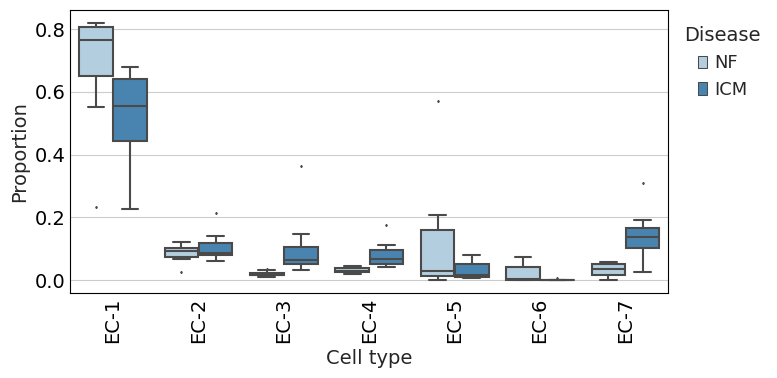

In [100]:
# Basic visualization of the proportions by disease
viz.boxplots(data_sccoda, feature_name="Disease", figsize = (8,4))

In [101]:
# Select the reference group to be used in scCODA
refgroup = ref_group_sd(data_sccoda).sort_values('S_j')
refgroup = refgroup.merge(pd.DataFrame(adata.obs['SubCluster'].value_counts()).reset_index(),
                          left_on='celltype', right_on='index', how = 'left')
refgroup['SubCluster_perc'] = refgroup['SubCluster']/refgroup['SubCluster'].sum()
refgroup

celltype       S_j index  SubCluster  SubCluster_perc
0     EC-4  0.401835  EC-4         879         0.047167
1     EC-2  0.468368  EC-2        1704         0.091436
2     EC-3  0.520557  EC-3         990         0.053123
3     EC-1  0.551713  EC-1       11241         0.603187
4     EC-7  0.580395  EC-7        1324         0.071045
5     EC-6   0.72464  EC-6         338         0.018137
6     EC-5   0.80996  EC-5        2160         0.115905

In [102]:
# Setting the scCODA model, adjusting for sex
# Require the reference cell-type to have at least 5% of the total cells
model = mod.CompositionalAnalysis(data_sccoda, formula="Disease + Sex", reference_cell_type="EC-2")

Zero counts encountered in data! Added a pseudocount of 0.5.


In [103]:
# Run MCMC
sim_results = model.sample_hmc()

MCMC sampling finished. (77.185 sec)
Acceptance rate: 59.9%


/home/unix/chaffin/.local/lib/python3.7/site-packages/sccoda/util/result_classes.py:216: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/unix/chaffin/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [104]:
# Print out the full model results for scCODA
sim_results.summary_extended()

Compositional Analysis summary (extended):

Data: 15 samples, 7 cell types
Reference index: 1
Formula: Disease + Sex
Spike-and-slab threshold: 0.562

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 77.185 sec. Acceptance rate: 59.9%

Intercepts:
           Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                          
EC-1                 2.279   1.807    2.797  0.259       797.037107
EC-2                 0.568   0.154    0.987  0.224       144.012663
EC-3                -0.338  -0.987    0.337  0.361        58.200924
EC-4                -0.087  -0.734    0.491  0.334        74.806235
EC-5                -0.237  -0.839    0.312  0.312        64.386323
EC-6                -1.052  -1.728   -0.442  0.338        28.499919
EC-7                -0.033  -0.645    0.555  0.320        78.956829


Effects:
                          Final Parameter  HDI 3%  HDI 97%     SD  \
Covariate      Cell Type                   

In [105]:
# Print out the scCODA results for the disease
effects = sim_results.effect_df.reset_index()
effects[effects['Covariate']=='Disease[T.ICM]']

Covariate Cell Type  Final Parameter  HDI 3%  HDI 97%     SD  \
0  Disease[T.ICM]      EC-1         0.000000  -0.649    0.196  0.227   
1  Disease[T.ICM]      EC-2         0.000000   0.000    0.000  0.000   
2  Disease[T.ICM]      EC-3         0.721889  -0.038    1.451  0.473   
3  Disease[T.ICM]      EC-4         0.509132  -0.062    1.183  0.392   
4  Disease[T.ICM]      EC-5         0.000000  -0.563    0.524  0.239   
5  Disease[T.ICM]      EC-6         0.000000  -0.766    0.460  0.286   
6  Disease[T.ICM]      EC-7         0.844853  -0.007    1.561  0.492   

   Inclusion probability  Expected Sample  log2-fold change  
0               0.384800       679.235054         -0.230736  
1               0.000000       122.727598         -0.230736  
2               0.796867       102.090133          0.810729  
3               0.631667       106.069978          0.503786  
4               0.397600        54.870027         -0.230736  
5               0.451400        24.287632         -0.230736  
6               0.863933       156.619579          0.988129

# Plotting sub-cluster results

In [25]:
sub_key = 'EC'

**UMAP Prep**

In [26]:
adata = sc.read(os.path.join(results_path, celltype + '/subcluster_map_merged_clusters.h5ad'))

In [27]:
adata.obs['SubCluster'] = [sub_key + '-' + x  for x in adata.obs['cluster_merge']]

... storing 'SubCluster' as categorical


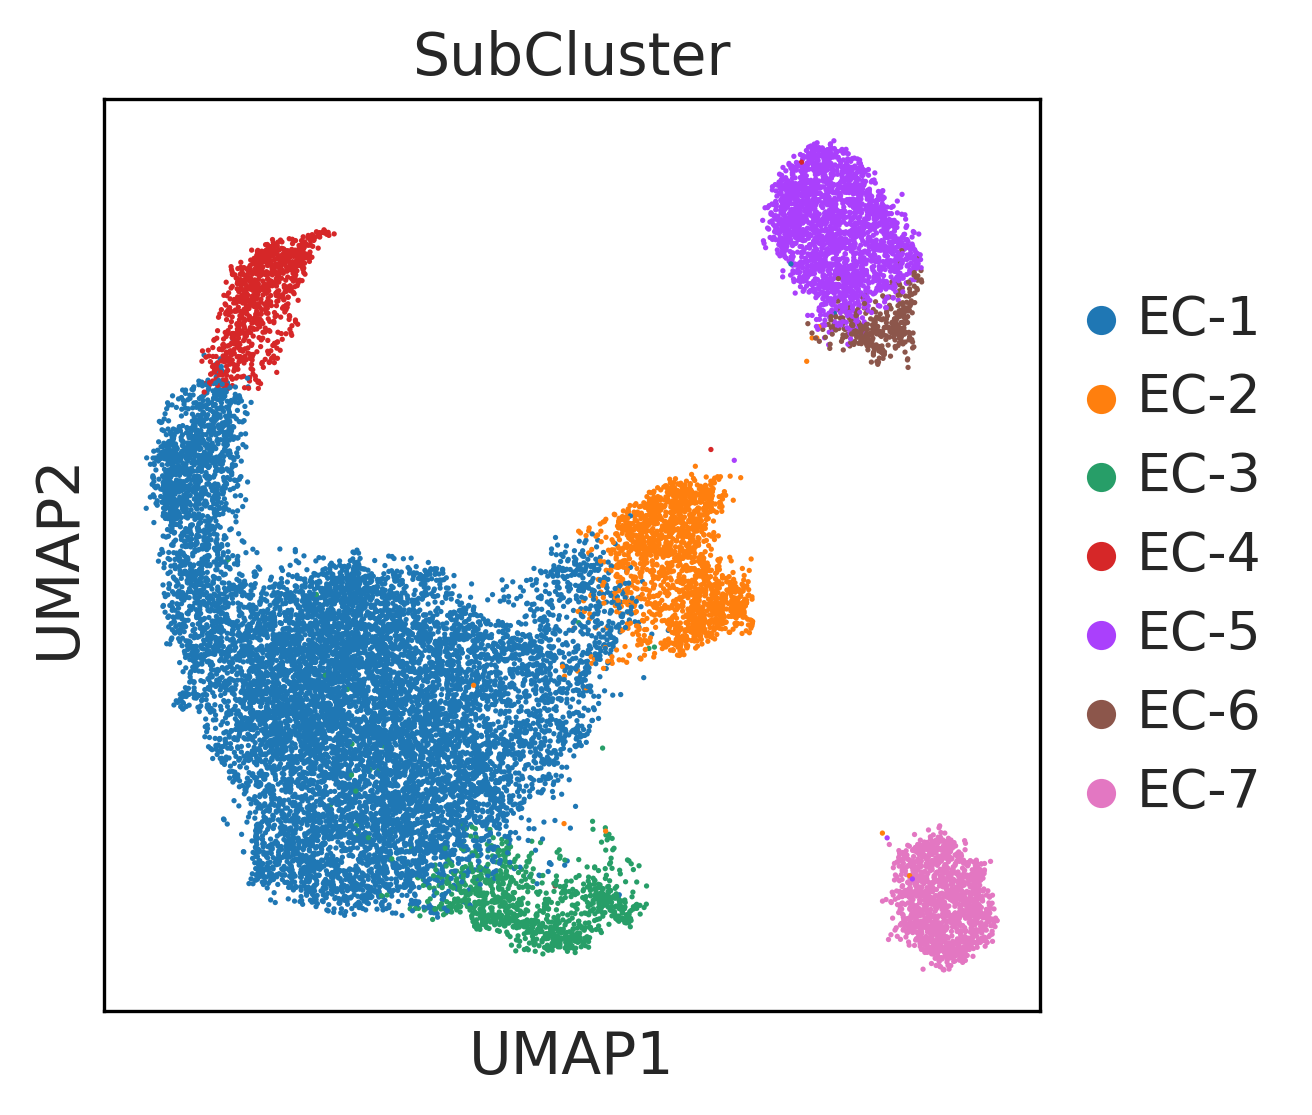

In [28]:
sc.set_figure_params(dpi=150)
sc.pl.umap(adata, color='SubCluster')

In [29]:
umap_coord = pd.DataFrame(adata.obsm['X_umap'])
umap_coord.columns = ['UMAP1', 'UMAP2']
umap_coord['cluster'] = adata.obs['SubCluster'].tolist()
umap_coord['color'] = [adata.uns['SubCluster_colors'][int(x.split('-')[1])-1] for x in umap_coord['cluster']]
umap_coord['color_disease'] = ['#d95f02' if x == 'NF' else '#1b9e77' if x == 'ICM' else np.nan for x in adata.obs['disease']]
sample_colmap = {i:sc.pl.palettes.vega_20[en] for en,i in enumerate(adata.obs['sample'].unique())}
umap_coord['color_sample'] = [sample_colmap[x] for x in adata.obs['sample']]

In [30]:
# Obtain the cluster centroids
centroids = umap_coord.groupby('cluster').median().reset_index()
# some adjustments to make it look nice
x_offset = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0,'10':0,'11':0,'12':0}
y_offset = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0,'10':0,'11':0,'12':0}
centroids['x'] = [x + x_offset[y.split('-')[1]] for x,y in zip(centroids['UMAP1'], centroids['cluster'])]
centroids['y'] = [x + y_offset[y.split('-')[1]] for x,y in zip(centroids['UMAP2'], centroids['cluster'])]

**Comp Prep**

In [31]:
# Make an array of the cell counts per type, per sample
# We can use this to construct the adata object required by scCODA
cell_counts = pd.crosstab(adata.obs['individual'].astype('str'), adata.obs['SubCluster'].astype('str'))
cell_counts.reset_index(inplace=True)

# Re-order samples so it's sorted as NF followed by ICM
cell_counts = pd.concat([cell_counts[cell_counts['individual'].isin(adata.obs[adata.obs['disease']=='NF']['individual'])],
                         cell_counts[cell_counts['individual'].isin(adata.obs[adata.obs['disease']=='ICM']['individual'])]])

# Re-order the columns so cell types are sorted by prevalence
cell_counts = cell_counts[['individual'] + [sub_key + '-' + str(x) for x in range(1,len(adata.obs['SubCluster'].unique())+1)]]

# Convert the counts into the scCODA adata required
data_sccoda = dat.from_pandas(cell_counts, covariate_columns=["individual"])

# Add in disease state and sex to data_sccoda
data_sccoda.obs["Disease"] = pd.Categorical([adata.obs[adata.obs['individual']==x]['disease'].iloc[0] 
                                             for x in data_sccoda.obs['individual']],
                                             categories=['NF','ICM'])
data_sccoda.obs["Sex"] = pd.Categorical([adata.obs[adata.obs['individual']==x]['sex'].iloc[0] 
                                             for x in data_sccoda.obs['individual']],
                                             categories=['M','F'])

/home/unix/chaffin/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [32]:
# For plotting
forplot = pd.DataFrame(data_sccoda.X)
forplot.columns = data_sccoda.var.index
forplot.index = data_sccoda.obs['individual'].tolist()
forplot = (forplot.transpose()/forplot.sum(1)).transpose()
forplot['disease'] = data_sccoda.obs['Disease'].tolist()

# Organize data for boxplot
forbox = []
for celltype in forplot.columns[:-1]:
    sub = forplot[[celltype, 'disease']].reset_index()
    sub.columns = ['Sample', 'Proportion', 'Disease']
    sub['Cell type'] = celltype
    forbox.append(sub)
forbox = pd.concat(forbox)

**Marker prep**

In [33]:
celltype = 'endothelial'
rare_pop = []

In [34]:
markers = pd.read_csv(os.path.join(results_path, celltype + '/subcluster_merged_clusters_markers.txt'),
                      sep='\t')

In [35]:
mforplot = []
for cl in sorted(markers['cluster'].unique()):
    if cl in rare_pop:
        mforplot+=markers[markers['cluster']==cl].sort_values('AUC',ascending=False).head(10)['gene'].tolist()
    else:
        mforplot+=markers[markers['cluster']==cl].sort_values('limma_voom.logFC',ascending=False).head(6)['gene'].tolist()

In [36]:
# Gene expression of the target genes
plt_mat = pd.DataFrame(adata.raw[:,mforplot].X.todense())
plt_mat.columns = mforplot
plt_mat['SubCluster'] = adata.obs['SubCluster'].tolist()
plt_mat_avg = plt_mat.groupby('SubCluster').mean()
plt_mat2 = (plt_mat[mforplot] > 0)
plt_mat2['SubCluster'] = adata.obs['SubCluster'].tolist()
plt_mat_avg = plt_mat.groupby('SubCluster').mean()
plt_mat_pct = plt_mat2.groupby('SubCluster').mean()

In [37]:
plt_mat_avg = plt_mat_avg.loc[:,~plt_mat_avg.columns.duplicated()]
plt_mat_pct = plt_mat_pct.loc[:,~plt_mat_pct.columns.duplicated()]

In [38]:
tocat = []
x = 0
for gene in mforplot:
    x += 1
    y = len(adata.obs['SubCluster'].unique())
    for celltype in range(1,len(adata.obs['SubCluster'].unique())+1):
        y -= 1
        celltype = str(celltype)
        celltype2 = sub_key + '-' + celltype
        df = pd.DataFrame([gene, celltype2, x, y,
                           plt_mat_pct[plt_mat_pct.index == celltype2][gene].iloc[0],
                           plt_mat_avg[plt_mat_avg.index == celltype2][gene].iloc[0]]).transpose()
        df.columns = ['gene','celltype','x','y','size','color']
        tocat.append(df)
dotplot = pd.concat(tocat)
dotplot['size'] = [float(x) for x in dotplot['size']]
dotplot['color'] = [float(x) for x in dotplot['color']]

In [39]:
# Normalize to the max expression for each gene
maxval = dotplot[['gene','color']].groupby('gene').max().reset_index()
maxval.columns = ['gene', 'maxval']
dotplot = dotplot.merge(maxval, on = 'gene', how='left')
dotplot['color'] = dotplot['color']/dotplot['maxval']

**Ontology Enrichment Prep**

In [40]:
len(adata.obs['cluster_merge'].unique())

7

In [41]:
celltype = 'immune'

tocat = []
for cluster in range(1,len(adata.obs['cluster_merge'].unique())+1):
    print(cluster)
    df = pd.read_csv(os.path.join(results_path, celltype + '/subcluster_merged_clusters_markers_ontology.txt'),
                      sep='\t')
    df = df[df['cluster']==cluster]
    df['SubCluster'] = sub_key + '-' + str(cluster)
    tocat.append(df)
ont = pd.concat(tocat)
cutpoint = 0.1/ont.shape[0] # loose cutoff

ont['sig'] = ont['fisher_p'] < cutpoint
tocat = []
for i in ont['SubCluster'].unique():
    df = ont[ont['SubCluster'] == i].copy()
    tocat.append(df.head(3))
ont = pd.concat(tocat)
ont['x'] = range(ont.shape[0])
ont['color'] = [adata.uns['SubCluster_colors'][int(x.split('-')[1])-1] for x in ont['SubCluster']]
ont = ont[~pd.isnull(ont['fisher_or'])]

1
2
3
4
5
6
7


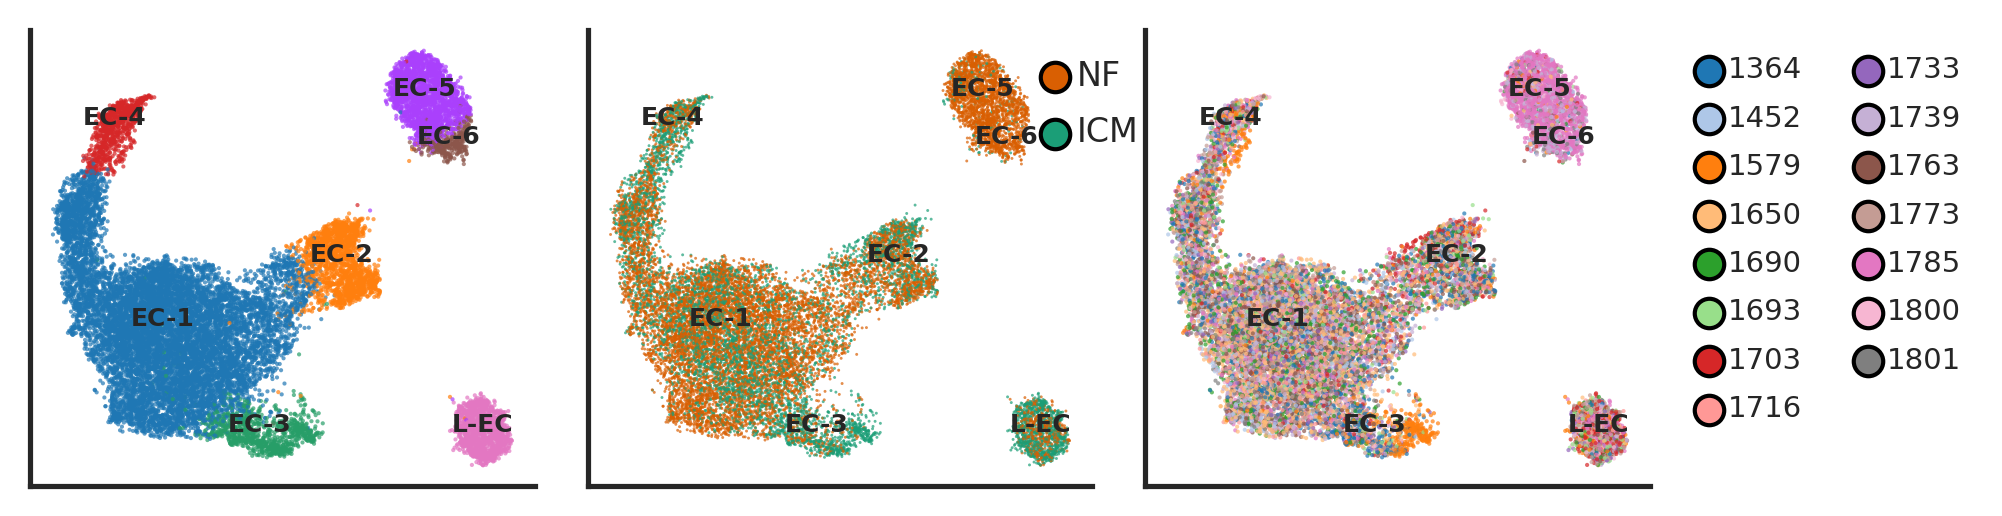

In [42]:
f = plt.figure(num=None, figsize=(6, 2), dpi=150, facecolor='w', edgecolor='k')
plt.style.use('seaborn-white')
gs = gridspec.GridSpec(5,15)
gs.update(left=0.1, right=1, wspace=.9, hspace=4.8)

# UMAP SUBCLUSTERING
ax1 = plt.subplot(gs[0:5,0:5])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax1.scatter(umap_coord['UMAP1'], umap_coord['UMAP2'], color = umap_coord['color'], s = 1, alpha = 0.7, rasterized=True,
            edgecolor='none')

for i in centroids.iterrows():
    if i[1]['cluster'] == 'EC-7':
        name = 'L-EC'
    else:
        name = i[1]['cluster']
    ax1.text(i[1]['x'], i[1]['y'], name, ha ='center', fontsize=6, weight = 'bold')
    
ax1 = plt.subplot(gs[0:5,5:10])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax1.scatter(umap_coord['UMAP1'], umap_coord['UMAP2'], color = umap_coord['color_disease'], s = .5, alpha = 0.7, rasterized=True,
            edgecolor='none')

for i in centroids.iterrows():
    if i[1]['cluster'] == 'EC-7':
        name = 'L-EC'
    else:
        name = i[1]['cluster']
    ax1.text(i[1]['x'], i[1]['y'], name, ha ='center', fontsize=6, weight = 'bold')
plt.draw()
ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1])
ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1])
for i in ['NF','ICM']:
    if i == 'NF':
        ax1.scatter(-10000,0,s = 50, edgecolor='black', linewidth = 1, label = 'NF',
                   color = '#d95f02')
    else:
        ax1.scatter(-10000,0,s = 50, edgecolor='black', linewidth = 1, label = 'ICM',
                   color = '#1b9e77')
ax1.legend(fontsize = 8, loc = 'upper left', bbox_to_anchor = (.85, 1), labelspacing=.7).set_zorder(0)    


    
ax1 = plt.subplot(gs[0:5,10:15])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
mix = umap_coord.sample(umap_coord.shape[0])
ax1.scatter(mix['UMAP1'], mix['UMAP2'], color = mix['color_sample'], s = 1, alpha = 0.7, rasterized=True,
            edgecolor='none')

for i in centroids.iterrows():
    if i[1]['cluster'] == 'EC-7':
        name = 'L-EC'
    else:
        name = i[1]['cluster']
    ax1.text(i[1]['x'], i[1]['y'], name, ha ='center', fontsize=6, weight = 'bold')
plt.draw()
ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1])
ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1])
for i in adata.obs['sample'].unique():
    ax1.scatter(-10000,0,s = 50, edgecolor='black', linewidth = 1, label = i,
                color = sample_colmap[i])

ax1.legend(fontsize = 7, loc = 'upper left', bbox_to_anchor = (1.05, 1), labelspacing=.7, ncol=2).set_zorder(0)    

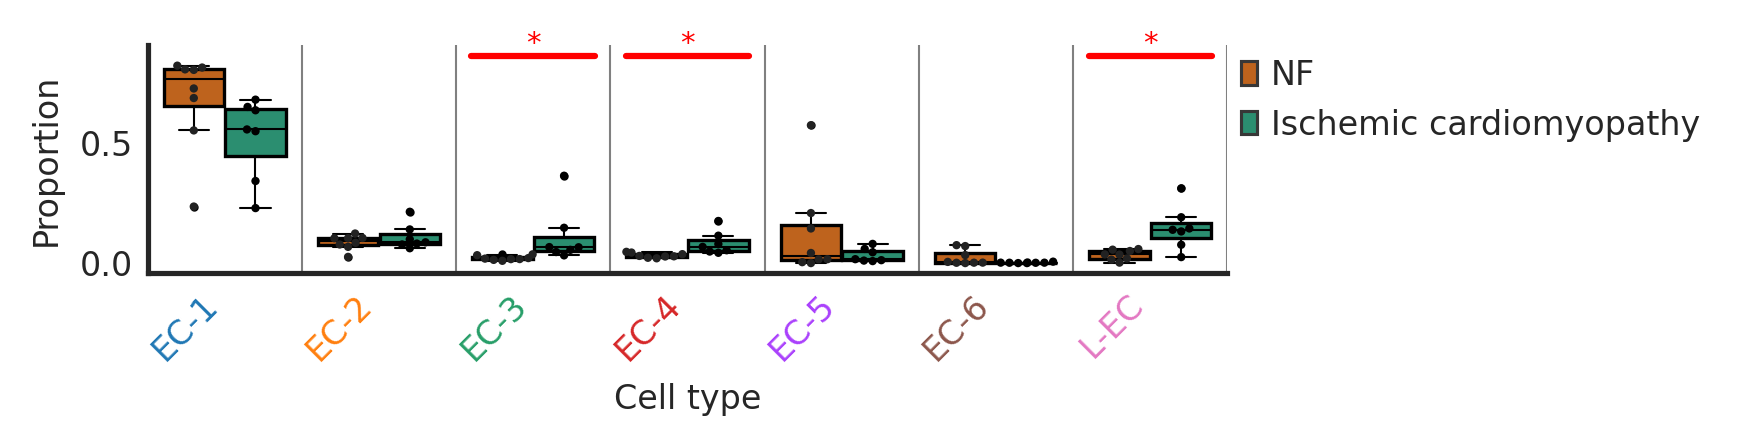

In [43]:
f = plt.figure(num=None, figsize=(4, 1), dpi=150, facecolor='w', edgecolor='k')
plt.style.use('seaborn-white')
gs = gridspec.GridSpec(5,5)
gs.update(left=0.1, right=1, wspace=.9, hspace=4.8)


# COMPOSITION SUBCLUSTERING
ax2 = plt.subplot(gs[0:5,0:5])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xticks([])
ax2.set_xticklabels([])

flierprops = dict(marker='o', markerfacecolor='black', markersize=1,
                  markeredgecolor='none')

sns.boxplot(x = 'Cell type', y = 'Proportion', hue = 'Disease', data = forbox, ax = ax2,
            fliersize = 1, flierprops=flierprops, palette=['#d95f02','#1b9e77'])
sns.swarmplot(x = 'Cell type', y = 'Proportion', hue = 'Disease', color='black', data = forbox, ax = ax2,
              s = 2, dodge=True)
plt.draw()
ax2.set_xticklabels([x for x in ax2.get_xticklabels()], fontsize = 8, rotation = 45, ha = 'right')
ax2.set_yticklabels([x for x in ax2.get_yticklabels()], fontsize = 8)
ax2.set_ylabel('Proportion', fontsize = 8)
ax2.set_xlabel('Cell type', fontsize = 8)
handles, labels = ax2.get_legend_handles_labels()
l = plt.legend(handles[0:3], ['NF','Ischemic cardiomyopathy'], bbox_to_anchor=(1.0, 1.0), loc=2, borderaxespad=0.,
               fontsize=8)

for i,artist in enumerate(ax2.artists):
    artist.set_edgecolor('black')
    artist.set_linewidth(.8)
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax2.lines[j]
        line.set_color('black')
        line.set_mfc('black')
        line.set_mec('black')
        line.set_linewidth(.5)

plt.draw()
for i in ax2.get_xticklabels():
    ax2.get_xticklabels()[int(i.get_text().split('-')[1])-1].set_color(adata.uns['SubCluster_colors'][int(i.get_text().split('-')[1])-1])
ax2.set_xticklabels(['L-EC' if x.get_text() == 'EC-7' else x for x in ax2.get_xticklabels()], fontsize = 8, rotation = 45, ha = 'right')


for i in range(len(adata.uns['SubCluster_colors'])):
    ax2.axvline(i + .5, color ='grey', linewidth = 0.5)
sig_change = [2,3,6]
top = ax2.get_ylim()[1]
for i in sig_change:
    ax2.plot([i - .4, i + .4], [top, top], color = 'red' )
    ax2.text(i, top+.02*top, '*', ha='center', fontsize=7, color = 'red')

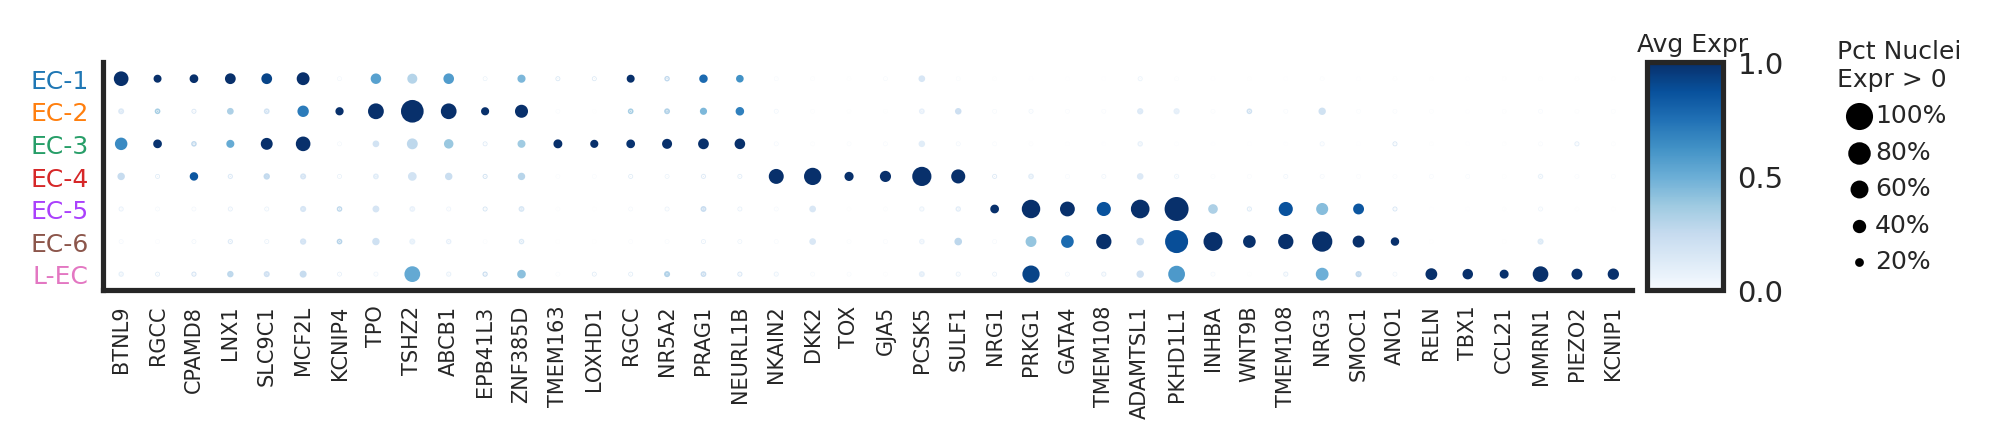

In [44]:
f = plt.figure(num=None, figsize=(6, 1), dpi=150, facecolor='w', edgecolor='k')
plt.style.use('seaborn-white')
gs = gridspec.GridSpec(5,5)
gs.update(left=0.1, right=1, wspace=.9, hspace=4.8)

# Marker genes
ax3 = plt.subplot(gs[0:5,0:5])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

im = ax3.scatter(dotplot['x'], dotplot['y'], s = (dotplot['size'] * 5.5) ** 2, c = dotplot['color'], cmap = 'Blues',
                 label=None)
ax3.set_ylim(dotplot['y'].min() - .5, dotplot['y'].max() + .5)
ax3.set_yticks([x for x in dotplot['y'].unique()])
ax3.set_yticklabels([dotplot[dotplot['y']==x]['celltype'].tolist()[0] for x in dotplot['y'].unique()],fontsize=6)
plt.draw()
for i in ax3.get_yticklabels():
    ax3.get_yticklabels()[int(i.get_text().split('-')[1])-1].set_color(adata.uns['SubCluster_colors'][int(i.get_text().split('-')[1])-1])
ax3.set_yticklabels(['L-EC' if dotplot[dotplot['y']==x]['celltype'].tolist()[0] == 'EC-7' else
                     dotplot[dotplot['y']==x]['celltype'].tolist()[0] for x in dotplot['y'].unique()],fontsize=6)

ax3.set_xlim(dotplot['x'].min() - .5, dotplot['x'].max() + .5)
ax3.set_xticks([x for x in dotplot['x'].unique()])
ax3.set_xticklabels([dotplot[dotplot['x']==x]['gene'].tolist()[0] for x in dotplot['x'].unique()],fontsize=5,
                    rotation = 90)
ax3.scatter(-5, ax3.get_ylim()[1]/2, s = (1 * 5.5) ** 2, label = '100%', color = 'Black')
ax3.scatter(-5, ax3.get_ylim()[1]/2, s = (0.8 * 5.5) ** 2, label = '80%', color = 'Black')
ax3.scatter(-5, ax3.get_ylim()[1]/2, s = (0.6 * 5.5) ** 2, label = '60%', color = 'Black')
ax3.scatter(-5, ax3.get_ylim()[1]/2, s = (0.4 * 5.5) ** 2, label = '40%', color = 'Black')
ax3.scatter(-5, ax3.get_ylim()[1]/2, s = (0.2 * 5.5) ** 2, label = '20%', color = 'Black')
leg = ax3.legend( bbox_to_anchor=(1.12, 1.2), loc='upper left', fontsize = 6)
leg.set_title('Pct Nuclei\nExpr > 0',prop={'size':6})
leg.get_frame().set_linewidth(0.0)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = f.colorbar(im, orientation='vertical',fraction=0.093, pad=0.05, aspect = 6, cax = cax)
cbar.ax.tick_params(labelsize=7) 
cbar.set_label('Avg Expr', labelpad=-22, y=1.13, rotation=0, fontsize = 6, ha ='center')

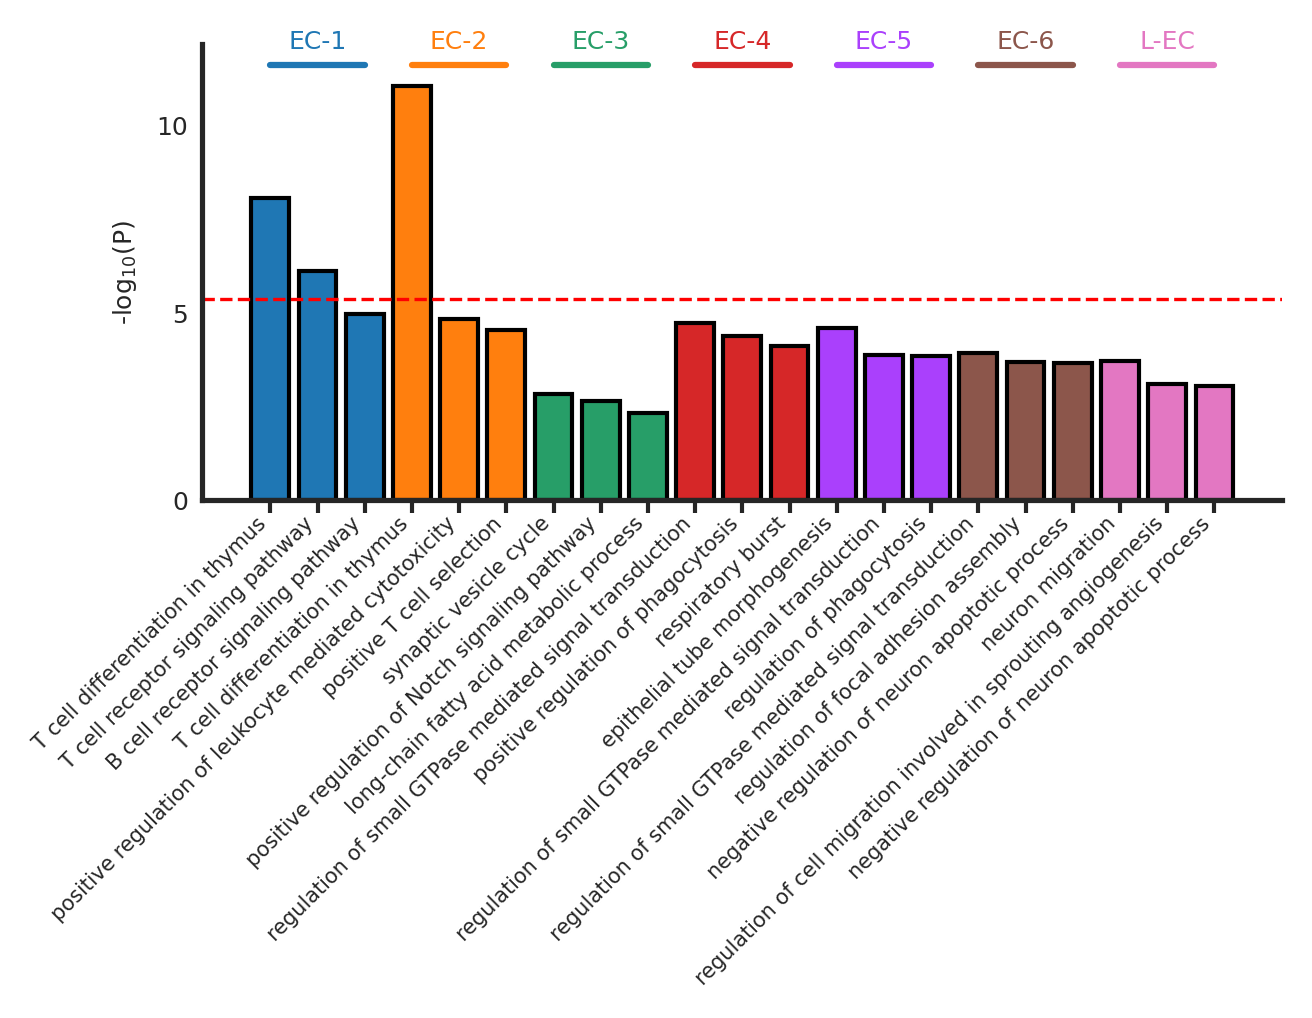

In [45]:
f = plt.figure(num=None, figsize=(4, 2), dpi=150, facecolor='w', edgecolor='k')
plt.style.use('seaborn-white')
gs = gridspec.GridSpec(5,5)
gs.update(left=0.1, right=1, wspace=.9, hspace=4.8)

# Ontology
ax4 = plt.subplot(gs[0:5,0:5])
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

ax4.bar(ont['x'], -np.log10(ont['fisher_p']), edgecolor='black', color = ont['color'])

ax4.set_xticks(ont['x'])
for tick in ax4.get_xaxis().get_major_ticks():
    tick.set_pad(.05)
    tick.label1 = tick._get_text1()
ax4.tick_params('x', length=3, width=1, which='major')

ax4.set_xticklabels(ont['term'].tolist(), fontsize = 5, rotation = 45, ha = 'right')
plt.draw()
ax4.set_yticklabels([x.get_text() for x in ax4.get_yticklabels()],
                    fontsize = 6)

ax4.axhline(-np.log10(cutpoint), linestyle = '--', color = 'red', linewidth = .8)
ax4.set_ylabel('-log$_{10}$(P)', fontsize = 6)
plt.draw()
top = ax4.get_ylim()[1]
for i in ont['SubCluster'].unique():
    xpos = ont[ont['SubCluster']==i]['x'].mean()
    xmin = ont[ont['SubCluster']==i]['x'].min()
    xmax = ont[ont['SubCluster']==i]['x'].max()
    color = ont[ont['SubCluster']==i]['color'].unique()[0]
    if i == 'EC-7':
        name = 'L-EC'
    else:
        name = i
    ax4.text(xpos, top + top*.04, name, ha='center', fontsize = 6, color = color)
    ax4.plot([xmin,xmax],[top,top],color=color)

plt.show()

# Differential Expression by SubCluster

In [13]:
# Re-read full expression and append the desired groups
celltype = 'endothelial'
sub_key = 'EC'
bdata = sc.read(os.path.join(path_aggregation, 'humanICM.PostQC.Map/PostQC.Neighbor.UMAP.Freeze1.h5ad'))
subclusters = pd.read_csv(os.path.join(results_path, celltype + '/selected_subclusters_merged_clusters.txt.gz'),
                          sep='\t')
submap = {x:str(y) for x,y in zip(subclusters['index'], subclusters['cluster_merge'])}
bdata = bdata[bdata.obs.index.isin(subclusters['index'])].copy()
bdata.obs['subcluster'] = [sub_key + '-' + submap[x] for x in bdata.obs.index]
bdata.obs['subcluster'].value_counts()
bdata.obs['subcluster'] = ['L-EC' if x == 'EC-7' else x for x in bdata.obs['subcluster']]
bdata.shape

Only considering the two last: ['.Freeze1', '.h5ad'].
Only considering the two last: ['.Freeze1', '.h5ad'].


(18636, 36601)

In [26]:
# Inspect the number of samples that will be included in a DE test for each cell type
base = (bdata.obs[['individual','disease',
                   'subcluster','sample']].groupby(['individual','disease','subcluster']).count()).reset_index()
base['good'] = base['sample'] > 25
selection = base[['subcluster','disease','good']].groupby(['subcluster','disease']).sum().reset_index().pivot(index='subcluster',
                                                                                                columns='disease',
                                                                                                values='good')
selection

disease     ICM  NF
subcluster         
EC-1          7   8
EC-2          7   8
EC-3          7   3
EC-4          7   7
EC-5          3   5
EC-6          0   3
L-EC          7   6

In [28]:
'''
Function to perform differential expression test
'''
def run_differential_expression(bdata, aggr_var, min_cell, group_var, target_group, ref_group,
                                covar, covar_dtype, cellranger, out):
    '''
    bdata: the subset of nuclei to include in the test
    aggr_var: the .obs key to sum counts across (e.g., individual)
    min_cell: the minimum cells to consider in a sample for aggregating
    group_var: the .obs key for the grouping variable
    target_group: the target group of the group_var to compare to ref_group
    ref_group: the reference group of the DE test
    covar: covariates to include in the DE test
    covar_dtype: the datatype for the covariates
    cellranger: True/False indicating whether to use .layers['cellranger_raw'] or not
    out: output file prefix
    '''
    # Aggregate the counts by the aggr_var
    tobind = [] # fill in each aggregation group, column-wise
    if cellranger:
        cellranger_key = 'cellranger'
        for ind in bdata.obs[aggr_var].unique():
            bdata_subset = bdata[bdata.obs[aggr_var]==ind].copy()
            if bdata_subset.shape[0] > min_cell:
                append_vect = pd.DataFrame(bdata_subset.layers['cellranger_raw'].sum(0)).transpose()
                append_vect.columns = [ind]
                tobind.append(append_vect) 
    else:
        cellranger_key = 'cellbender'
        for ind in bdata.obs[aggr_var].unique():
            bdata_subset = bdata[bdata.obs[aggr_var]==ind].copy()
            if bdata_subset.shape[0] > min_cell:
                append_vect = pd.DataFrame(bdata_subset.X.sum(0)).transpose()
                append_vect.columns = [ind]
                tobind.append(append_vect)
    summed_exp = pd.concat(tobind, axis = 1)
    summed_exp.index = bdata.var.index
    keep_samp = bdata.obs[bdata.obs[group_var].isin([target_group, ref_group])][aggr_var].unique()
    summed_exp = summed_exp[[x for x in keep_samp.tolist() if x in summed_exp.columns]]
    
    # Filter out lowly expressed genes -- this is always done on CellBender counts
    # so that a similar set of genes goes into the DE test
    keep_gene = bdata.var[(np.array((bdata[bdata.obs[group_var] == target_group].X > 0).mean(0) > 0.01).squeeze())|
                          (np.array((bdata[bdata.obs[group_var] == ref_group].X > 0).mean(0) > 0.01).squeeze())].index.tolist()
    summed_exp = summed_exp[summed_exp.index.isin(keep_gene)]
    print('\tGenes with > 1% in either group = ' + str(summed_exp.shape[0]))

    # Set up data in R
    meta_data = bdata.obs[[aggr_var, group_var] + covar].drop_duplicates().reset_index().drop('index',1)
    meta_data[aggr_var] = ['X' + str(x) if x[0].isdigit() else str(x) for x in meta_data[aggr_var]]
    #meta_data.index = meta_data[aggr_var].tolist()
    #meta_data.drop(aggr_var, 1, inplace=True)
    with localconverter(ro.default_converter + pandas2ri.converter):
        all_counts = ro.conversion.py2rpy(summed_exp) # count data
    with localconverter(ro.default_converter + pandas2ri.converter): 
        meta_data_r = ro.conversion.py2rpy(meta_data) # meta data
    ro.r.assign('all_counts', all_counts)
    ro.r.assign('meta_data_r', meta_data_r)
    
    # Remove MT and RB genes
    ro.r('mt_genes <- rownames(all_counts)[regexpr("MT-",rownames(all_counts)) != -1]')
    ro.r('rb_genes <- rownames(all_counts)[regexpr("^RP[SL]",rownames(all_counts)) != -1]')
    ro.r('all_counts <- all_counts[which(!rownames(all_counts) %in% mt_genes & !rownames(all_counts) %in% rb_genes),]')
    
    # Set up grouping variable and covariates
    ro.r('group <- with(meta_data_r, ' + group_var + '[match(colnames(all_counts), ' + aggr_var + ')])')
    for cov, covt in zip(covar, covar_dtype):
        if covt == 'factor':
            ro.r('as.factor(' + cov + ' <- with(meta_data_r, ' + cov + '[match(colnames(all_counts), ' + aggr_var + ')]))')
        elif covt == 'numeric':
            ro.r('as.numeric(' + cov + ' <- with(meta_data_r, ' + cov + '[match(colnames(all_counts), ' + aggr_var + ')]))')    

    # filter out genes with low expression -- we'll use the EdgeR function to determine what "low" is
    ro.r('keep.exprs <- filterByExpr(all_counts, group = group)')
    ro.r('all_counts <- all_counts[keep.exprs, ]')
    print(ro.r('paste0("      Genes retained after filterByExpr = ",dim(all_counts)[1])'))
    print(ro.r('table(group)'))
    
    # Set up for limma-voom
    ro.r('sample.formula <- ~ 1+group+' + '+'.join(covar))
    ro.r('sample.data <- data.frame(group=factor(group, levels=c("' + ref_group + '","' + target_group + '")),' + ','.join(covar) + ')')
    ro.r('design <- model.matrix(sample.formula, sample.data)')
    # Normalize data
    sf = DESeq2.estimateSizeFactorsForMatrix(ro.r('all_counts')) # DESeq2 normalization
    ro.r.assign('sf', sf)
    ro.r('eff.lib <- sf*mean(colSums(all_counts))')
    print('\tdata normalized...')
    
    # Run Voom
    ro.r('y <- DGEList(all_counts, lib.size=eff.lib)')
    grdevices.pdf(file=out + '_' + cellranger_key + '_voom.pdf')
    ro.r('v.all <- voomWithQualityWeights(y, design, plot=T)')
    grdevices.dev_off()
    
    ro.r('vfit <- lmFit(v.all, design)')
    ro.r('vfit <- eBayes(vfit, robust=TRUE)')
    ro.r('vres <- topTable(vfit, n=Inf, sort.by="P", coef="group' + target_group +'")')
    ro.r('write.table(vres,"' + out + '_' + cellranger_key + '_results.txt", , sep="\t", quote=F)')

    # Extra Voom diagnostic (SAplot)
    grdevices.pdf(file=out + '_' + cellranger_key + '_plotSA.pdf')
    ro.r('plotSA(vfit)')
    grdevices.dev_off()
    print('Done!')

In [18]:
# Make the folder to store these DE results
if not os.path.exists(os.path.join(results_path, celltype + '/diffexpress')):
    os.mkdir(os.path.join(results_path, celltype + '/diffexpress'))

In [30]:
# loop through each cell type and run the DE test
# Once on cellbender counts and once on cellranger counts
for ct in selection[(selection >=3).sum(1) == 2].index:
    print('Testing celltype (CellBender) ' + ct)
    run_differential_expression(bdata = bdata[bdata.obs['subcluster'] == ct].copy(),
                                aggr_var = 'individual',
                                min_cell = 25,
                                group_var = 'disease',
                                target_group = 'ICM',
                                ref_group = 'NF',
                                covar = ['sex', 'age'],
                                covar_dtype = ['factor', 'numeric'],
                                cellranger = False,
                                out = os.path.join(results_path, celltype + '/diffexpress/' + ct))
    print('Testing celltype (CellRanger) ' + ct)
    run_differential_expression(bdata = bdata[bdata.obs['subcluster'] == ct].copy(),
                                aggr_var = 'individual',
                                min_cell = 25,
                                group_var = 'disease',
                                target_group = 'ICM',
                                ref_group = 'NF',
                                covar = ['sex', 'age'],
                                covar_dtype = ['factor', 'numeric'],
                                cellranger = True,
                                out = os.path.join(results_path, celltype + '/diffexpress/' + ct))    

Testing celltype (CellBender) EC-1
	Genes with > 1% in either group = 7317
[1] "      Genes retained after filterByExpr = 5484"

group
ICM  NF 
  7   8 

	data normalized...
Done!
Testing celltype (CellRanger) EC-1
	Genes with > 1% in either group = 7317
[1] "      Genes retained after filterByExpr = 6837"

group
ICM  NF 
  7   8 

	data normalized...
Done!
Testing celltype (CellBender) EC-2
	Genes with > 1% in either group = 9293
[1] "      Genes retained after filterByExpr = 2303"

group
ICM  NF 
  7   8 

	data normalized...
Done!
Testing celltype (CellRanger) EC-2
	Genes with > 1% in either group = 9293
[1] "      Genes retained after filterByExpr = 2747"

group
ICM  NF 
  7   8 

	data normalized...
Done!
Testing celltype (CellBender) EC-3
	Genes with > 1% in either group = 9774
[1] "      Genes retained after filterByExpr = 1083"

group
ICM  NF 
  7   3 

	data normalized...
Done!
Testing celltype (CellRanger) EC-3
	Genes with > 1% in either group = 9774
[1] "      Genes retained

In [32]:
'''
function to calculate the background probability heuristic
'''
def calculate_bkg(adata, cluster_key, cluster):
    # Approximate background profile across full dataset
    approx_background_profile = np.array(adata.X.sum(axis=0)).squeeze() / adata.X.sum()  # normalized
    gene_order = np.argsort(approx_background_profile)
    gene_to_cdf_x = np.argsort(gene_order)
    cdf = np.cumsum(approx_background_profile[gene_order])
    adata.var['gene_bkg_prob'] = cdf[[gene_to_cdf_x[i] for i in range(len(adata.var))]]
    
    # counts for inside and outside the target cluster
    adata_subset = adata[adata.obs[cluster_key].isin(cluster)]
    bc_out_group = list(set(adata.obs.index) - set(adata_subset.obs.index))
    adata_out_group = adata[bc_out_group]
    X_in = adata_subset.X
    X_out = adata_out_group.X

    # calculate fraction of cells in and out of group expressing > 0 counts
    tp_0 = np.array((X_in > 0).sum(axis=0)).squeeze()
    fp_0 = np.array((X_out > 0).sum(axis=0)).squeeze()
    frac_exp_gr_0_target = tp_0 / adata_subset.shape[0]
    frac_exp_gr_0_other = fp_0 / X_out.shape[0]

    # calculate fraction of cells in and out of group expressing > 1 counts
    tp_1 = np.array((X_in > 1).sum(axis=0)).squeeze()
    fp_1 = np.array((X_out > 1).sum(axis=0)).squeeze()
    frac_exp_gr_1_target = tp_1 / adata_subset.shape[0]
    frac_exp_gr_1_other = fp_1 / X_out.shape[0]

    # calculate standardized PPVs based on > 0 expression and > 1 expression
    # this standardized PPV is equivalent to what would be calculated from
    # specificity and sensivity with a set prevalence of 0.5 (e.g. assuming equal cluster size)
    ppv_0 = frac_exp_gr_0_target / (frac_exp_gr_0_target + frac_exp_gr_0_other + 1e-5)
    ppv_1 = frac_exp_gr_1_target / (frac_exp_gr_1_target + frac_exp_gr_1_other + 1e-5)
    
    # take the average ppv0 and ppv1
    mean_ppv = (ppv_0 + ppv_1) / 2.
    prob_from_another_cluster = 1. - mean_ppv  # if very low mean_ppv, unlikely from this given cluster
    bkg_prob = prob_from_another_cluster * adata.var['gene_bkg_prob'] # normalize this for the overall expression of the gene
    return(bkg_prob)

In [33]:
# Re-read full expression and append the desired groups
# Set cell type label and included leiden clusters
celltype = 'endothelial'
clusters = ['2','5','8','11']
sub_key = 'EC'
adata = sc.read(os.path.join(path_aggregation, 'humanICM.PostQC.Map/PostQC.Neighbor.UMAP.Freeze1.h5ad'))

Only considering the two last: ['.Freeze1', '.h5ad'].
Only considering the two last: ['.Freeze1', '.h5ad'].


In [83]:
# loop through each cell type and compile the information required
target_group = 'ICM'
ref_group = 'NF'
group_var = 'disease'
min_cell = 25 # matches above minimum cells required to aggregate
tocat = []
for gr in selection[(selection >=3).sum(1) == 2].index:
    print(gr)
    # get the DE results
    de_cb = pd.read_csv(os.path.join(results_path, celltype + '/diffexpress/' + gr + '_cellbender_results.txt'),
                        sep='\t').reset_index() # cellbender DE
    de_cb.columns = ['index'] + [x + '_CB' for x in de_cb.columns[1:]] # rename columns
    de_cr = pd.read_csv(os.path.join(results_path, celltype + '/diffexpress/' + gr + '_cellranger_results.txt'),
                        sep='\t').reset_index() # cellranger DE
    de_cr.columns = ['index'] + [x + '_CR' for x in de_cr.columns[1:]] # rename columns
    de = de_cb.merge(de_cr, on = 'index', how = 'left')
    de = de.merge(adata.var.reset_index()[['index', 'gene_ids']], on = 'index', how = 'left')
    de['celltype'] = gr
    de['grp1'] = target_group
    de['grp2'] = ref_group
    de['ncell_grp1'] = bdata.obs[(bdata.obs[group_var] == target_group)&(bdata.obs['subcluster'] == gr)].shape[0]
    de['ncell_grp2'] = bdata.obs[(bdata.obs[group_var] == ref_group)&(bdata.obs['subcluster'] == gr)].shape[0]
    de['nsamp_grp1'] = (bdata.obs[(bdata.obs[group_var] == target_group)&
                                  (bdata.obs['subcluster'] == gr)]['individual'].value_counts() > min_cell).sum()
    de['nsamp_grp2'] = (bdata.obs[(bdata.obs[group_var] == ref_group)&
                                  (bdata.obs['subcluster'] == gr)]['individual'].value_counts() > min_cell).sum()
        
    # add the background prob, unless pseudo-bulk where not relevant
    if gr == 'pseudo_bulk':
        de['gene_bkg_prob'] = np.nan
    else:
        # This selects all cells that are either in our sub-cluster of interest, or in NON-endothelial cells
        # Then we set the "Reference group" as the endothelial cells remaining (e.g. in our subcluster)
        # So the other endothelial cells are excluded from "background"
        bkg_prob = pd.DataFrame(calculate_bkg(adata[(~adata.obs['leiden0.5'].isin(clusters)) | (adata.obs.index.isin(bdata[bdata.obs['subcluster']==gr].obs.index))].copy(),
                                              'leiden0.5',
                                              clusters)).reset_index()
        bkg_prob.columns = ['gene','gene_bkg_prob']
        de = de.merge(bkg_prob, left_on='index', right_on='gene', how='left')
        
    # pct and avg express for each gene
    adata_clst = bdata[bdata.obs['subcluster'] == gr].copy()
    sc.pp.normalize_total(adata_clst, target_sum=1e4)
    sc.pp.log1p(adata_clst)
    target_avg_expr = np.array(adata_clst[adata_clst.obs[group_var] == target_group].X.mean(0)).squeeze()
    ref_avg_expr = np.array(adata_clst[adata_clst.obs[group_var] == ref_group].X.mean(0)).squeeze()
    target_pct_gt0 = np.array((adata_clst[adata_clst.obs[group_var] == target_group].X > 0).mean(0)).squeeze()
    ref_pct_gt0 = np.array((adata_clst[adata_clst.obs[group_var] == ref_group].X > 0).mean(0)).squeeze()    
    expr_level = pd.DataFrame({'pctgt0_grp1':target_pct_gt0,
                               'pctgt0_grp2':ref_pct_gt0,
                               'avgexpr_grp1':target_avg_expr,
                               'avgexpr_grp2':ref_avg_expr})
    expr_level['index'] = adata.var.index.tolist()
    de = de.merge(expr_level, left_on='index', right_on='index', how='left')
    
    # reorganize the data
    de = de[['index', 'gene_ids', 'celltype', 'grp1', 'grp2', 'nsamp_grp1', 'nsamp_grp2',
             'ncell_grp1', 'ncell_grp2', 'pctgt0_grp1', 'pctgt0_grp2', 'avgexpr_grp1', 'avgexpr_grp2',
             'gene_bkg_prob',
             'logFC_CB', 'AveExpr_CB', 't_CB', 'P.Value_CB', 'adj.P.Val_CB',
             'logFC_CR', 'AveExpr_CR', 't_CR', 'P.Value_CR', 'adj.P.Val_CR']]
    de.columns = ['gene', 'ensembl_id', 'celltype', 'grp1', 'grp2', 'nsamp_grp1', 'nsamp_grp2',
                      'ncell_grp1', 'ncell_grp2', 'pctgt0_grp1', 'pctgt0_grp2', 'avgexpr_grp1', 'avgexpr_grp2',
                      'gene_bkg_prob', 'logFC_CB', 'AveExpr_CB', 't_CB', 'P.Value_CB', 'adj.P.Val_CB',
                     'logFC_CR', 'AveExpr_CR', 't_CR', 'P.Value_CR', 'adj.P.Val_CR']
    tocat.append(de)

# combine all the DE results across cell types together
allres = pd.concat(tocat)

EC-1
EC-2
EC-3
EC-4
EC-5
L-EC


In [84]:
allres.to_csv(os.path.join(results_path, celltype + '/diffexpress/human_ICM_vs_NF_differential_expression_v2.0.txt.gz'),
              sep='\t',index=None,compression='gzip',na_rep='NA')

# Differential Expression Ontology ICMvsNF by subcluster

**topGO**

In [14]:
# path to the differential expression results
celltype = 'endothelial'
degenes = pd.read_csv(os.path.join(results_path, celltype + '/diffexpress/human_ICM_vs_NF_differential_expression_v2.0.txt.gz'),
                      sep='\t')

In [15]:
# Function to run the ontology enrichment for each cell type
def run_topgo(summary_stats, gene_key, rank_key, group_key, algorithm, nodesize, max_size, direction):
    '''
    summary_stats: the summary stats with gene_key, rank_key, and group_key
    gene_key: the column in summary_stats with the "gene_name" (e.g., RYR2, TTN)
    rank_key: the column in summary_stats with the metric to rank the genes on.
              This should be coded such that higher values indicate more relevant
    group_key: the column in summary_stats to select the genes to go into the fisher
               test. Should be a True/False boolean
    algorithm: The algoirthm for topGO. Should be compatible with both the fisher and ks
               methods (i.e., classic, elim, weight01, lea)
    nodesize: the minimum nodeSize to cosider for an ontology in topGO
    max_size: A post-hoc filter for removal of ontologies/pathways > max_size
    direction: either "increasing" or "decreasing" for up-regulated, and down-regulated genes
    '''
    # Set up for the over-representation test
    print('\tPrepping for over-representation and GSEA tests:')

    # Get the target genelist and gene universe into R
    target = ro.StrVector(summary_stats[summary_stats[group_key]][gene_key].tolist())
    ro.r.assign('target', target)
    uni = ro.StrVector(summary_stats[~pd.isnull(summary_stats[rank_key])][gene_key].tolist())
    ro.r.assign('universe', uni)
    
    # Get the ranking statistic
    ranking = ro.FloatVector(summary_stats[~pd.isnull(summary_stats[rank_key])][rank_key].tolist())
    ro.r.assign('ranks', ranking)
    ro.r('names(ranks) <- universe') # assigning the appropriate names to the ranking
    
    print('\t\tNumber of genes in target = ' + str(ro.r('length(target)')))
    print('\t\tNumber of genes in universe = ' + str(ro.r('length(universe)')))
    
    '''
    set up topGO object
    This include both the ranking, and the "significant" gene group
    Because by default topGO only allows us to select genes for the "over-representation"
    style test using the one ranking metric, we've created a hacky solution to work around this.
    In the "sigGenes" and "numSigGenes" methods, we've hardcoded it to take the "ranks" object which retains
    the names() of the genes such that the selFun() can select the appropriate genes for the
    enrichment test
    '''
    ro.r('selFun <- function(allScore){x <- names(allScore) %in% target\n ' + \
                                       'names(x) <- names(allScore)\n' + \
                                       'return(x)}')
    ro.r('setMethod("sigGenes", "topGOdata",\n' + \
              'function(object) {\n' + \
              '  sGenesIndex <- object@geneSelectionFun(ranks) & object@feasible\n' + \
              '  return(object@allGenes[sGenesIndex])\n' + \
              '})')
    ro.r('setMethod("numSigGenes", "topGOdata",\n' + \
                   'function(object) {return(sum(object@geneSelectionFun(ranks) & object@feasible))})')
    ro.r('GOdata=new("topGOdata", ontology="BP", allGenes = ranks, geneSel = selFun, annot = annFUN.org, ' + \
        'mapping = "org.Hs.eg.db", ID = "symbol", nodeSize = ' + str(nodesize) + ')')
    
    # Running the tests
    print('\t\tRunning enrichment tests')
    ro.r('resultFisher=runTest(GOdata, algorithm="' + algorithm + '", statistic="fisher")')
    ro.r('resultKS=runTest(GOdata, algorithm="' + algorithm + '", statistic="ks", scoreOrder = "' + direction + '")')

    # Make final output results
    ro.r('allGO=usedGO(GOdata)')
    ro.r('all_res=GenTable(GOdata, weightFisher=resultFisher, weightKS=resultKS, orderBy="weightFisher", ' + \
         'topNodes=length(allGO), numChar=1000)')
    # convert back to pandas
    with localconverter(ro.default_converter + pandas2ri.converter):
        all_res = ro.conversion.rpy2py(ro.r('all_res'))
    # Remove ontologies/pathways greater than maximum size
    all_res = all_res[all_res['Annotated'] < max_size]
    
    # derive the odds ratio for enrichment for the fisher test
    with localconverter(ro.default_converter + pandas2ri.converter):
        sig_genes = ro.conversion.rpy2py(ro.r('numSigGenes(GOdata)'))[0]
    with localconverter(ro.default_converter + pandas2ri.converter):
        total_genes = ro.conversion.rpy2py(ro.r('sum(feasible(GOdata))'))[0]
    all_res['fisher.OR'] = (all_res['Significant'] * ((total_genes - sig_genes) - (all_res['Annotated'] - all_res['Significant'])) )/ \
                           ((all_res['Annotated'] - all_res['Significant']) * (sig_genes - all_res['Significant']))
    
    # Clean up labels
    all_res = all_res[['GO.ID', 'Term', 'Annotated', 'Significant', 'Expected', 'fisher.OR', 'weightFisher',
                     'weightKS']]
    all_res.columns = ['go_id', 'term', 'genes_in_ontology', 'fisher_significant_in_ontology',
                       'fisher_expected_in_ontology', 'fisher_or', 'fisher_p', 'ks_p']
    return(all_res)

In [17]:
# loop through each cell type and run the pathway enrichment
# Ranking genes based on the t-statistic using CellBender
# Do both the up-regulated genes and down-regulated genes separately
tocat = []
for cluster in degenes['celltype'].unique():
    print(cluster)
    # create the DE gene list to include
    degenes_subset = degenes[degenes['celltype']==cluster]
    # remove background contamination genes
    degenes_subset = degenes_subset[(degenes_subset['gene_bkg_prob'] < 0.4)|
                                    (pd.isnull(degenes_subset['gene_bkg_prob']))]
    
    # Up-regulated genes in disease
    # Criteria for "robust genes"
    degenes_subset['sig_gene'] = (degenes_subset['logFC_CB'] > 0) & \
                                 (degenes_subset['logFC_CR'] > 0) & \
                                 (degenes_subset['adj.P.Val_CB'] < 0.05) & \
                                 (degenes_subset['adj.P.Val_CR'] < 0.05)

    print('\tSignificant markers for up-regulation over-representation test = ' + str(degenes_subset['sig_gene'].sum()))
    res = run_topgo(summary_stats = degenes_subset,
                    gene_key = 'gene',
                    rank_key = 't_CB',
                    group_key = 'sig_gene',
                    algorithm = 'weight01',
                    nodesize = 15,
                    max_size = 500,
                    direction = 'increasing')
    res['cluster'] = cluster
    res['direction'] = 'upregulated'
    tocat.append(res)

    # Down-regulated genes in disease
    # Criteria for "robust genes"
    degenes_subset['sig_gene'] = (degenes_subset['logFC_CB'] < 0) & \
                                 (degenes_subset['logFC_CR'] < 0) & \
                                 (degenes_subset['adj.P.Val_CB'] < 0.05) & \
                                 (degenes_subset['adj.P.Val_CR'] < 0.05)

    print('\tSignificant markers for down-regulation over-representation test = ' + str(degenes_subset['sig_gene'].sum()))
    res = run_topgo(summary_stats = degenes_subset,
                    gene_key = 'gene',
                    rank_key = 't_CB',
                    group_key = 'sig_gene',
                    algorithm = 'weight01',
                    nodesize = 15,
                    max_size = 500,
                    direction = 'decreasing')
    res['cluster'] = cluster
    res['direction'] = 'downregulated'
    tocat.append(res)

complete_enrichment = pd.concat(tocat)

R[write to console]: 
Building most specific GOs .....



EC-1
	Significant markers for up-regulation over-representation test = 149
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 149

		Number of genes in universe = [1] 5064



R[write to console]: 	( 7407 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 11395 GO terms and 26179 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 4156 genes annotated to the GO terms. )



		Running enrichment tests


R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 2145 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 16:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 15:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 14:	17 nodes to be scored	(40 eliminated genes)

R[write to console]: 
	 Level 13:	35 nodes to be scored	(103 eliminated genes)

R[write to console]: 
	 Level 12:	62 nodes to be scored	(387 eliminated genes)

R[write to console]: 
	 Level 11:	108 nodes to be scored	(1126 eliminated genes)

R[write to console]: 
	 Level 10:	175 nodes to be scored	(1736 eliminated genes)

R[write to console]: 
	 Level 9:	256 nodes to be scored	(2272 eliminated genes)

R[write to console]: 
	 Level 8:	293 nodes to be scored	(2843 eliminated genes)

R[write to console]: 
	 Level 7:	356 nodes to be scored	(3286 eliminated genes)

R[write to console]: 
	 Level 6:	347 nodes to be scor

	Significant markers for down-regulation over-representation test = 210
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 210

		Number of genes in universe = [1] 5064



R[write to console]: 	( 7407 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 11395 GO terms and 26179 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 4156 genes annotated to the GO terms. )



		Running enrichment tests


R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 2239 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 16:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 15:	8 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 14:	20 nodes to be scored	(22 eliminated genes)

R[write to console]: 
	 Level 13:	32 nodes to be scored	(129 eliminated genes)

R[write to console]: 
	 Level 12:	59 nodes to be scored	(390 eliminated genes)

R[write to console]: 
	 Level 11:	101 nodes to be scored	(1050 eliminated genes)

R[write to console]: 
	 Level 10:	177 nodes to be scored	(1744 eliminated genes)

R[write to console]: 
	 Level 9:	274 nodes to be scored	(2228 eliminated genes)

R[write to console]: 
	 Level 8:	316 nodes to be scored	(2895 eliminated genes)

R[write to console]: 
	 Level 7:	388 nodes to be scored	(3336 eliminated genes)

R[write to console]: 
	 Level 6:	356 nodes to be scor

EC-2
	Significant markers for up-regulation over-representation test = 16
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 16

		Number of genes in universe = [1] 2094



R[write to console]: 	( 5313 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 9015 GO terms and 20486 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 1848 genes annotated to the GO terms. )



		Running enrichment tests


R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 615 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 15:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 14:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 13:	9 nodes to be scored	(15 eliminated genes)

R[write to console]: 
	 Level 12:	9 nodes to be scored	(91 eliminated genes)

R[write to console]: 
	 Level 11:	16 nodes to be scored	(402 eliminated genes)

R[write to console]: 
	 Level 10:	32 nodes to be scored	(625 eliminated genes)

R[write to console]: 
	 Level 9:	50 nodes to be scored	(767 eliminated genes)

R[write to console]: 
	 Level 8:	62 nodes to be scored	(924 eliminated genes)

R[write to console]: 
	 Level 7:	87 nodes to be scored	(1148 eliminated genes)

R[write to console]: 
	 Level 6:	109 nodes to be scored	(1398 eliminated genes)

R[write to console]: 
	 Level 5:	111 nodes to be scored	(1607 eli

	Significant markers for down-regulation over-representation test = 50
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 50

		Number of genes in universe = [1] 2094



R[write to console]: 	( 5313 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 9015 GO terms and 20486 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 1848 genes annotated to the GO terms. )



		Running enrichment tests


R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 948 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 14:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 13:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	15 nodes to be scored	(18 eliminated genes)

R[write to console]: 
	 Level 11:	24 nodes to be scored	(110 eliminated genes)

R[write to console]: 
	 Level 10:	43 nodes to be scored	(588 eliminated genes)

R[write to console]: 
	 Level 9:	64 nodes to be scored	(851 eliminated genes)

R[write to console]: 
	 Level 8:	108 nodes to be scored	(1087 eliminated genes)

R[write to console]: 
	 Level 7:	155 nodes to be scored	(1289 eliminated genes)

R[write to console]: 
	 Level 6:	189 nodes to be scored	(1571 eliminated genes)

R[write to console]: 
	 Level 5:	170 nodes to be scored	(1719 eliminated genes)

R[write to console]: 
	 Level 4:	104 nodes to be scored	(1

EC-3
	Significant markers for up-regulation over-representation test = 4
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 4

		Number of genes in universe = [1] 994



R[write to console]: 	( 3909 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 7439 GO terms and 16835 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 900 genes annotated to the GO terms. )

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 319 nontrivial nodes
		 parameters: 
			 test statistic: fisher



		Running enrichment tests


R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(21 eliminated genes)

R[write to console]: 
	 Level 10:	11 nodes to be scored	(198 eliminated genes)

R[write to console]: 
	 Level 9:	16 nodes to be scored	(311 eliminated genes)

R[write to console]: 
	 Level 8:	20 nodes to be scored	(364 eliminated genes)

R[write to console]: 
	 Level 7:	39 nodes to be scored	(394 eliminated genes)

R[write to console]: 
	 Level 6:	62 nodes to be scored	(532 eliminated genes)

R[write to console]: 
	 Level 5:	69 nodes to be scored	(717 eliminated genes)

R[write to console]: 
	 Level 4:	50 nodes to be scored	(810 eliminated genes)

R[write to console]: 
	 Level 3:	27 nodes to be scored	(869 eliminated genes)

R[write to console]: 
	 Level 2:	13 nodes to be scored	(878 eliminated genes)

R[write to console]: 
	 Level 1:	1 nodes to be scored	(8

	Significant markers for down-regulation over-representation test = 19
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 19

		Number of genes in universe = [1] 994



R[write to console]: 	( 3909 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 7439 GO terms and 16835 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 900 genes annotated to the GO terms. )

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 806 nontrivial nodes
		 parameters: 
			 test statistic: fisher



		Running enrichment tests


R[write to console]: 
	 Level 13:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	11 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	15 nodes to be scored	(192 eliminated genes)

R[write to console]: 
	 Level 10:	32 nodes to be scored	(332 eliminated genes)

R[write to console]: 
	 Level 9:	50 nodes to be scored	(403 eliminated genes)

R[write to console]: 
	 Level 8:	79 nodes to be scored	(522 eliminated genes)

R[write to console]: 
	 Level 7:	129 nodes to be scored	(612 eliminated genes)

R[write to console]: 
	 Level 6:	164 nodes to be scored	(753 eliminated genes)

R[write to console]: 
	 Level 5:	157 nodes to be scored	(827 eliminated genes)

R[write to console]: 
	 Level 4:	96 nodes to be scored	(870 eliminated genes)

R[write to console]: 
	 Level 3:	52 nodes to be scored	(877 eliminated genes)

R[write to console]: 
	 Level 2:	16 nodes to be scored	(884 eliminated genes)

R[write to console]: 
	 Level 1:	1 nodes to be sco

EC-4
	Significant markers for up-regulation over-representation test = 2
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 2

		Number of genes in universe = [1] 597



R[write to console]: 	( 3017 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 6286 GO terms and 14114 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 554 genes annotated to the GO terms. )

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 284 nontrivial nodes
		 parameters: 
			 test statistic: fisher



		Running enrichment tests


R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(117 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(195 eliminated genes)

R[write to console]: 
	 Level 8:	16 nodes to be scored	(216 eliminated genes)

R[write to console]: 
	 Level 7:	34 nodes to be scored	(237 eliminated genes)

R[write to console]: 
	 Level 6:	51 nodes to be scored	(327 eliminated genes)

R[write to console]: 
	 Level 5:	61 nodes to be scored	(440 eliminated genes)

R[write to console]: 
	 Level 4:	48 nodes to be scored	(500 eliminated genes)

R[write to console]: 
	 Level 3:	31 nodes to be scored	(537 eliminated genes)

R[write to console]: 
	 Level 2:	14 nodes to be scored	(541 eliminated genes)

R[write to console]: 
	 Level 1:	1 nodes to be scored	(543 eliminated genes)

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 t

	Significant markers for down-regulation over-representation test = 15
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 15

		Number of genes in universe = [1] 597



R[write to console]: 	( 3017 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 6286 GO terms and 14114 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 554 genes annotated to the GO terms. )

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 580 nontrivial nodes
		 parameters: 
			 test statistic: fisher



		Running enrichment tests


R[write to console]: 
	 Level 14:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 13:	7 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	10 nodes to be scored	(17 eliminated genes)

R[write to console]: 
	 Level 11:	13 nodes to be scored	(156 eliminated genes)

R[write to console]: 
	 Level 10:	20 nodes to be scored	(214 eliminated genes)

R[write to console]: 
	 Level 9:	34 nodes to be scored	(256 eliminated genes)

R[write to console]: 
	 Level 8:	49 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 7:	80 nodes to be scored	(355 eliminated genes)

R[write to console]: 
	 Level 6:	110 nodes to be scored	(412 eliminated genes)

R[write to console]: 
	 Level 5:	126 nodes to be scored	(479 eliminated genes)

R[write to console]: 
	 Level 4:	76 nodes to be scored	(524 eliminated genes)

R[write to console]: 
	 Level 3:	40 nodes to be scored	(539 eliminated genes)

R[write to console]: 
	 Level 2:	13 nodes to be scor

EC-5
	Significant markers for up-regulation over-representation test = 24
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 24

		Number of genes in universe = [1] 1855



R[write to console]: 	( 5164 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 8887 GO terms and 20205 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 1645 genes annotated to the GO terms. )



		Running enrichment tests


R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 881 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 15:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 14:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 13:	9 nodes to be scored	(28 eliminated genes)

R[write to console]: 
	 Level 12:	17 nodes to be scored	(83 eliminated genes)

R[write to console]: 
	 Level 11:	26 nodes to be scored	(409 eliminated genes)

R[write to console]: 
	 Level 10:	48 nodes to be scored	(604 eliminated genes)

R[write to console]: 
	 Level 9:	69 nodes to be scored	(756 eliminated genes)

R[write to console]: 
	 Level 8:	100 nodes to be scored	(930 eliminated genes)

R[write to console]: 
	 Level 7:	144 nodes to be scored	(1069 eliminated genes)

R[write to console]: 
	 Level 6:	163 nodes to be scored	(1364 eliminated genes)

R[write to console]: 
	 Level 5:	149 nodes to be scored	(1513 

	Significant markers for down-regulation over-representation test = 26
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 26

		Number of genes in universe = [1] 1855



R[write to console]: 	( 5164 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 8887 GO terms and 20205 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 1645 genes annotated to the GO terms. )



		Running enrichment tests


R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 661 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	10 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	12 nodes to be scored	(91 eliminated genes)

R[write to console]: 
	 Level 10:	30 nodes to be scored	(493 eliminated genes)

R[write to console]: 
	 Level 9:	37 nodes to be scored	(657 eliminated genes)

R[write to console]: 
	 Level 8:	68 nodes to be scored	(897 eliminated genes)

R[write to console]: 
	 Level 7:	95 nodes to be scored	(989 eliminated genes)

R[write to console]: 
	 Level 6:	119 nodes to be scored	(1246 eliminated genes)

R[write to console]: 
	 Level 5:	129 nodes to be scored	(1457 eliminated genes)

R[write to console]: 
	 Level 4:	89 nodes to be scored	(1564 eliminated genes)

R[write to console]: 
	 Level 3:	50 nodes to be scored	(1604 

L-EC
	Significant markers for up-regulation over-representation test = 4
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 4

		Number of genes in universe = [1] 1713



R[write to console]: 	( 4856 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 8526 GO terms and 19311 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 1534 genes annotated to the GO terms. )



		Running enrichment tests


R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 276 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 14:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 13:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	3 nodes to be scored	(54 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(86 eliminated genes)

R[write to console]: 
	 Level 10:	10 nodes to be scored	(415 eliminated genes)

R[write to console]: 
	 Level 9:	15 nodes to be scored	(558 eliminated genes)

R[write to console]: 
	 Level 8:	20 nodes to be scored	(625 eliminated genes)

R[write to console]: 
	 Level 7:	31 nodes to be scored	(670 eliminated genes)

R[write to console]: 
	 Level 6:	46 nodes to be scored	(915 eliminated genes)

R[write to console]: 
	 Level 5:	63 nodes to be scored	(1125 eliminated genes)

R[write to console]: 
	 Level 4:	41 nodes to be scored	(1388 elimina

	Significant markers for down-regulation over-representation test = 21
	Prepping for over-representation and GSEA tests:
		Number of genes in target = [1] 21

		Number of genes in universe = [1] 1713



R[write to console]: 	( 4856 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 8526 GO terms and 19311 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 1534 genes annotated to the GO terms. )



		Running enrichment tests


R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 505 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	10 nodes to be scored	(256 eliminated genes)

R[write to console]: 
	 Level 10:	15 nodes to be scored	(461 eliminated genes)

R[write to console]: 
	 Level 9:	25 nodes to be scored	(630 eliminated genes)

R[write to console]: 
	 Level 8:	38 nodes to be scored	(782 eliminated genes)

R[write to console]: 
	 Level 7:	59 nodes to be scored	(910 eliminated genes)

R[write to console]: 
	 Level 6:	95 nodes to be scored	(1194 eliminated genes)

R[write to console]: 
	 Level 5:	119 nodes to be scored	(1346 eliminated genes)

R[write to console]: 
	 Level 4:	75 nodes to be scored	(1447 eliminated genes)

R[write to console]: 
	 Level 3:	46 nodes to be scored	(1499 e

In [20]:
complete_enrichment.to_csv(os.path.join(results_path, celltype + '/diffexpress/human_ICM_vs_NF_differential_expression_topGO_LF0_enrichment_v2.0.txt'),
                     sep='\t', index=None, na_rep='NA')

In [23]:
complete_enrichment['fisher_p'] = [1e-30 if x == '< 1e-30' else float(x) for x in complete_enrichment['fisher_p']]
complete_enrichment['ks_p'] = [1e-30 if x == '< 1e-30' else float(x) for x in complete_enrichment['ks_p']]
for celltype in complete_enrichment['cluster'].unique():
    print(celltype)
    print('\tUp-regulated')
    for term in complete_enrichment[(complete_enrichment['fisher_p'] < 0.001)&
                                    (complete_enrichment['cluster']==celltype)&
                                    (complete_enrichment['direction'] == 'upregulated')]['term']:
        print('\t\t' + term)
    print('\tDown-regulated')
    for term in complete_enrichment[(complete_enrichment['fisher_p'] < 0.001)&
                                    (complete_enrichment['cluster']==celltype)&
                                    (complete_enrichment['direction'] == 'downregulated')]['term']:
        print('\t\t' + term)

EC-1
	Up-regulated
		embryonic pattern specification
	Down-regulated
EC-2
	Up-regulated
	Down-regulated
EC-3
	Up-regulated
	Down-regulated
EC-4
	Up-regulated
	Down-regulated
EC-5
	Up-regulated
	Down-regulated
L-EC
	Up-regulated
	Down-regulated


**ReactomePA**

In [26]:
celltype = 'endothelial'
degenes = pd.read_csv(os.path.join(results_path, celltype + '/diffexpress/human_ICM_vs_NF_differential_expression_v2.0.txt.gz'),
                      sep='\t')

In [27]:
# Filter out the background contamination genes -- from both the main target genes and universe
degenes = degenes[(pd.isnull(degenes['gene_bkg_prob']))|(degenes['gene_bkg_prob'] < 0.4)].copy()

In [28]:
# Flag the significant upregulated and downregulated genes (logFC cutoff = 0)
degenes['sig_gene_up_logFC0'] = (degenes['logFC_CB'] > 0) & \
                                (degenes['logFC_CR'] > 0) & \
                                (degenes['adj.P.Val_CB'] < 0.05) & \
                                (degenes['adj.P.Val_CR'] < 0.05)
degenes['sig_gene_down_logFC0'] = (degenes['logFC_CB'] < 0) & \
                                  (degenes['logFC_CR'] < 0) & \
                                  (degenes['adj.P.Val_CB'] < 0.05) & \
                                  (degenes['adj.P.Val_CR'] < 0.05)

In [29]:
pd.crosstab(degenes['celltype'], degenes['sig_gene_up_logFC0'])

sig_gene_up_logFC0  False  True 
celltype                        
EC-1                 4915    149
EC-2                 2078     16
EC-3                  990      4
EC-4                  595      2
EC-5                 1831     24
L-EC                 1709      4

In [30]:
pd.crosstab(degenes['celltype'], degenes['sig_gene_down_logFC0'])

sig_gene_down_logFC0  False  True 
celltype                          
EC-1                   4854    210
EC-2                   2044     50
EC-3                    975     19
EC-4                    582     15
EC-5                   1829     26
L-EC                   1692     21

**Convert gene ensembl IDs to entrez IDs for ReactomePA**

In [31]:
genes = degenes['ensembl_id'].unique()
allgene = ro.StrVector(genes.tolist())
ro.r.assign('allgene', allgene)
ro.r('allgene <- as.data.frame(allgene)')
ro.r('colnames(allgene) <- c("ensembl")')
ro.r('allgene$ensembl <- as.character(allgene$ensembl)')
ro.r('allgene$entrez = mapIds(org.Hs.eg.db, keys=allgene$ensembl, column="ENTREZID", keytype="ENSEMBL", multiVals="first")')
with localconverter(ro.default_converter + pandas2ri.converter):
    ensg_to_entrez = ro.conversion.rpy2py(ro.r('allgene'))
degenes = degenes.merge(ensg_to_entrez, left_on = 'ensembl_id', right_on = 'ensembl', how = 'left')

R[write to console]: 'select()' returned 1:many mapping between keys and columns



In [32]:
# Remove genes that didn't map to Entrez
degenes = degenes[degenes['entrez']!='NA']

In [33]:
# Run Reactome Enrichment by cell type
tocat = []
for celltype in degenes['celltype'].unique():
    print(celltype)
    print('\tUp-regulated')
    target = ro.StrVector(degenes[(degenes['celltype'] == celltype)&(degenes['sig_gene_up_logFC0'])]['entrez'].tolist())
    ro.r.assign('target', target)
    uni = ro.StrVector(degenes[degenes['celltype'] == celltype]['entrez'].tolist())
    ro.r.assign('universe', uni)
    ro.r('react <- enrichPathway(gene=as.character(target),pvalueCutoff=1,qvalueCutoff=1,universe=as.character(universe), readable=T)')
    with localconverter(ro.default_converter + pandas2ri.converter):
        react = ro.conversion.rpy2py(ro.r('as.data.frame(react)'))
    react['celltype'] = celltype
    react['direction'] = 'upregulated'
    tocat.append(react)
    print('\tDown-regulated')
    target = ro.StrVector(degenes[(degenes['celltype'] == celltype)&(degenes['sig_gene_down_logFC0'])]['entrez'].tolist())
    ro.r.assign('target', target)
    uni = ro.StrVector(degenes[degenes['celltype'] == celltype]['entrez'].tolist())
    ro.r.assign('universe', uni)
    ro.r('react <- enrichPathway(gene=as.character(target),pvalueCutoff=1,qvalueCutoff=1,universe=as.character(universe), readable=T)')
    with localconverter(ro.default_converter + pandas2ri.converter):
        react = ro.conversion.rpy2py(ro.r('as.data.frame(react)'))
    react['celltype'] = celltype
    react['direction'] = 'downregulated'
    tocat.append(react)

EC-1
	Up-regulated
	Down-regulated
EC-2
	Up-regulated
	Down-regulated
EC-3
	Up-regulated
	Down-regulated
EC-4
	Up-regulated
	Down-regulated
EC-5
	Up-regulated
	Down-regulated
L-EC
	Up-regulated
	Down-regulated


In [34]:
allreact = pd.concat(tocat)

In [36]:
celltype = 'endothelial'
allreact.to_csv(os.path.join(results_path, celltype + '/diffexpress/human_ICM_vs_NF_differential_expression_pathway_enrichment_Reactome_logFC0_v2.0.txt'),
                     sep='\t', index=None, na_rep='NA')

In [37]:
allreact[allreact['pvalue'] < 0.05/allreact.shape[0]]

Empty DataFrame
Columns: [ID, Description, GeneRatio, BgRatio, pvalue, p.adjust, qvalue, geneID, Count, celltype, direction]
Index: []

# Subcluster CPM

In [10]:
# Re-read full expression and append the desired groups
celltype = 'endothelial'
sub_key = 'EC'
bdata = sc.read(os.path.join(path_aggregation, 'humanICM.PostQC.Map/PostQC.Neighbor.UMAP.Freeze1.h5ad'))
subclusters = pd.read_csv(os.path.join(results_path, celltype + '/selected_subclusters_merged_clusters.txt.gz'),
                          sep='\t')
submap = {x:str(y) for x,y in zip(subclusters['index'], subclusters['cluster_merge'])}
bdata = bdata[bdata.obs.index.isin(subclusters['index'])].copy()
bdata.obs['subcluster'] = [sub_key + '-' + submap[x] for x in bdata.obs.index]
bdata.obs['subcluster'].value_counts()
bdata.obs['subcluster'] = ['L-EC' if x == 'EC-7' else x for x in bdata.obs['subcluster']]
bdata.shape

Only considering the two last: ['.Freeze1', '.h5ad'].
Only considering the two last: ['.Freeze1', '.h5ad'].


(18636, 36601)

In [12]:
# Generate the meta_data for these samples
meta_data = bdata.obs[['individual','disease','age','sex']].drop_duplicates().reset_index().drop('index',1)
meta_data['individual'] = ['X' + str(x) if x[0].isdigit() else str(x) for x in meta_data['individual']]

In [13]:
# Convert the pandas metadata dataframe to R dataframe
with localconverter(ro.default_converter + pandas2ri.converter): 
    meta_data_r = ro.conversion.py2rpy(meta_data) # meta data
ro.r.assign('meta_data_r', meta_data_r)
print('Dataframe added to R...')

Dataframe added to R...


In [14]:
[x for x in bdata.obs['subcluster'].unique()]

['L-EC', 'EC-5', 'EC-2', 'EC-1', 'EC-3', 'EC-4', 'EC-6']

In [26]:
# Only doing the conversion for subtypes with DE test
for ct in [x for x in bdata.obs['subcluster'].unique() if not x == 'EC-6']:
    print('CellType = ' + str(ct))
    tobind = [] # fill in each aggregation group, column-wise
    adata_subset = bdata[bdata.obs['subcluster']==ct].copy()
    for ind in bdata.obs['individual'].unique():
        adata_subset2 = adata_subset[adata_subset.obs['individual']==ind].copy()
        if adata_subset2.shape[0] > 25:
            append_vect = pd.DataFrame(adata_subset2.X.sum(0)).transpose()
            append_vect.columns = [ind]
            tobind.append(append_vect)
    summed_exp = pd.concat(tobind, axis = 1)
    summed_exp.index = bdata.var.index
    print(summed_exp.shape)
    # Convert the pandas expression dataframe to R dataframe
    with localconverter(ro.default_converter + pandas2ri.converter):
        all_counts = ro.conversion.py2rpy(summed_exp) # count data
    ro.r.assign('all_counts', all_counts)
    print('Dataframe added to R...')
    # Remove MT and Ribosomal genes
    ro.r('mt_genes <- rownames(all_counts)[regexpr("MT-",rownames(all_counts)) != -1]')
    ro.r('rb_genes <- rownames(all_counts)[regexpr("^RP[SL]",rownames(all_counts)) != -1]')
    ro.r('all_counts <- all_counts[which(!rownames(all_counts) %in% mt_genes & !rownames(all_counts) %in% rb_genes),]')
    print(ro.r('dim(all_counts)'))
    # Covariates including individual, celltype, disease, age, and sex
    ro.r('individual <- colnames(all_counts)')
    ro.r('disease <- with(meta_data_r, ' + \
         'disease[match(colnames(all_counts), individual)])')
    ro.r('sex <- with(meta_data_r, ' + \
         'sex[match(colnames(all_counts), individual)])')
    ro.r('age <- with(meta_data_r, ' + \
         'as.numeric(age[match(colnames(all_counts), individual)]))')
    # Set up the design
    ro.r('sample.formula <- ~ 1+disease+age+sex')
    ro.r('sample.data <- data.frame(disease=factor(disease), age=age, ' + \
         'sex=factor(sex))')
    ro.r('design <- model.matrix(sample.formula, sample.data)')
    # Remove very lowly expressed genes using the filterByExpr function with the complicated data structure accounted for
    # Some transcripts will be removed in this process
    ro.r('keep.exprs <- filterByExpr(all_counts, group = disease)')
    ro.r('all_counts <- all_counts[keep.exprs, ]')
    print(ro.r('paste0("Genes retained after filterByExpr = ",dim(all_counts)[1])'))
    # Normalize data
    sf = DESeq2.estimateSizeFactorsForMatrix(ro.r('all_counts')) # DESeq2 normalization
    ro.r.assign('sf', sf)
    ro.r('eff.lib <- sf*mean(colSums(all_counts))')
    # Calculate logCPM from this
    # A higher prior count can reduce noise
    ro.r('y <- DGEList(all_counts, lib.size=eff.lib)')
    ro.r('CPM <- as.data.frame(cpm(y, log=TRUE, prior.count=3))')
    print('Converted to CPM')
    # Convert the CPM back to pandas, and save
    with localconverter(ro.default_converter + pandas2ri.converter):
        logCPM = ro.conversion.rpy2py(ro.r('CPM')).reset_index()
    logCPM.to_csv(os.path.join(results_path,celltype + '/diffexpress/logCPM_CellBender_cluster' + str(ct) + '.txt.gz') ,
                  sep='\t', index=None, na_rep='NA', compression='gzip')

CellType = L-EC
(36601, 13)
Dataframe added to R...
[1] 36485    13

[1] "Genes retained after filterByExpr = 1875"

Converted to CPM
CellType = EC-5
(36601, 8)
Dataframe added to R...
[1] 36485     8

[1] "Genes retained after filterByExpr = 2035"

Converted to CPM
CellType = EC-2
(36601, 15)
Dataframe added to R...
[1] 36485    15

[1] "Genes retained after filterByExpr = 2303"

Converted to CPM
CellType = EC-1
(36601, 15)
Dataframe added to R...
[1] 36485    15

[1] "Genes retained after filterByExpr = 5496"

Converted to CPM
CellType = EC-3
(36601, 10)
Dataframe added to R...
[1] 36485    10

[1] "Genes retained after filterByExpr = 1084"

Converted to CPM
CellType = EC-4
(36601, 14)
Dataframe added to R...
[1] 36485    14

[1] "Genes retained after filterByExpr = 679"

Converted to CPM


# Scoring the Published EC scores

**snRNAseq data**

In [10]:
# Re-read full expression and append the desired groups
celltype = 'endothelial'
bdata = sc.read(os.path.join(path_aggregation, 'humanICM.PostQC.Map/PostQC.Neighbor.UMAP.Freeze1.h5ad'))
subclusters = pd.read_csv(os.path.join(results_path, celltype + '/selected_subclusters_merged_clusters.txt.gz'),
                          sep='\t')
submap = {x:str(y) for x,y in zip(subclusters['index'], subclusters['cluster_merge'])}
bdata = bdata[bdata.obs.index.isin(subclusters['index'])].copy()
bdata.obs['subcluster'] = [submap[x] for x in bdata.obs.index]
bdata.obs['subcluster'].value_counts()

Only considering the two last: ['.Freeze1', '.h5ad'].
Only considering the two last: ['.Freeze1', '.h5ad'].


1    11241
5     2160
2     1704
7     1324
3      990
4      879
6      338
Name: subcluster, dtype: int64

In [11]:
# Normalize and scale
sc.pp.normalize_total(bdata, 1e4)
sc.pp.log1p(bdata)
sc.pp.scale(bdata)

**Get the markers for each subtype**

In [12]:
# Read Feng markers
feng_weights = {}
for x in ['Fabp4+', 'Cytl1+', 'Fam167b+', 'Pdpn+']:
    df = pd.read_excel(os.path.join(scoring_data_path,'feng_2019.XLSX'), sheet_name = x)
    df.columns = ['gene', 'p_val', 'avg_logFC', 'pct.1', 'pct.2', 'p_val_adj']
    feng_weights[x] = df

In [27]:
# Read Schupp markers
schupp = pd.read_excel(os.path.join(scoring_data_path,'circ_circulationaha-2020-052318_supp6.xlsx'))
schupp_weights = {}
for x in schupp['cell.type.ident'].unique():
    df = schupp[schupp['cell.type.ident']==x]
    df = df[['gene','p_val','logFC','pct.1','pct.2','p_val_adj']]
    df.columns = ['gene', 'p_val', 'avg_logFC', 'pct.1', 'pct.2', 'p_val_adj']
    schupp_weights[x] = df

In [135]:
# Read Kalucka Markers
kalucka = pd.read_excel(os.path.join(scoring_data_path,'kalucka_et_al_2020_cell.xlsx'), sheet_name = 'heart', skiprows = 6)
kalucka_weights = {}
for i, name in zip([np.nan, 1, 2, 3, 4, 5, 6, 7],
                   ['Artery', 'Capillary arterial', 'Capillary',
                    'Capillary venous', 'Interferon', 'Angiogenic',
                    'Large vein', 'Lymphatic']):
    if pd.isnull(i):
        suffix = ''
    else:
        suffix = '.'+str(i)
    df = kalucka[['Gene'+suffix, 'Pvalue'+suffix, 'Adjusted pvalue'+suffix]]
    df.columns = ['gene','p_val','p_val_adj']
    kalucka_weights[name] = df

**Link the mouse datasets to human genes, when necessary**

In [136]:
# Using biomaRt to link
ro.r('human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")')
ro.r('mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")')

R object with classes: ('Mart',) mapped to:

In [137]:
hgenes = bdata.var['gene_ids'].tolist()
hgenes = ro.StrVector(hgenes)
ro.r.assign('hgenes', hgenes)

R object with classes: ('character',) mapped to:
['ENSG0000..., 'ENSG0000..., 'ENSG0000..., 'ENSG0000..., ..., 'ENSG0000..., 'ENSG0000..., 'ENSG0000..., 'ENSG0000...]

In [138]:
ro.r('genesV2 = getLDS(attributes = c("hgnc_symbol", "ensembl_gene_id"), filters = "ensembl_gene_id", values = hgenes , mart = human, attributesL = c("mgi_symbol", "ensembl_gene_id"), martL = mouse, uniqueRows=T)')

R object with classes: ('data.frame',) mapped to:
[StrSexpVec..., StrSexpVec..., StrSexpVec..., StrSexpVec...]
  HGNC.symbol: <class 'rpy2.rinterface_lib.sexp.StrSexpVector'>
  <rpy2.rinterface_lib.sexp.StrSexpVector object at 0x2b4edb913388> [RTYPES.STRSXP]
  Gene.stable.ID: <class 'rpy2.rinterface_lib.sexp.StrSexpVector'>
  <rpy2.rinterface_lib.sexp.StrSexpVector object at 0x2b4edb9135c8> [RTYPES.STRSXP]
  MGI.symbol: <class 'rpy2.rinterface_lib.sexp.StrSexpVector'>
  <rpy2.rinterface_lib.sexp.StrSexpVector object at 0x2b4edb913d48> [RTYPES.STRSXP]
  Gene.stable.ID.1: <class 'rpy2.rinterface_lib.sexp.StrSexpVector'>
  <rpy2.rinterface_lib.sexp.StrSexpVector object at 0x2b4edb913388> [RTYPES.STRSXP]

In [139]:
print(ro.r('head(genesV2)'))

  HGNC.symbol  Gene.stable.ID MGI.symbol   Gene.stable.ID.1
1      MT-ND4 ENSG00000198886     mt-Nd4 ENSMUSG00000064363
2     PRAMEF6 ENSG00000232423            ENSMUSG00000094722
3     PRAMEF6 ENSG00000232423            ENSMUSG00000094741
4     PRAMEF6 ENSG00000232423            ENSMUSG00000095666
5     PRAMEF6 ENSG00000232423            ENSMUSG00000094836
6     PRAMEF6 ENSG00000232423            ENSMUSG00000094303



In [140]:
ro.r('write.table(genesV2, "' + os.path.join(scoring_data_path, 'human_to_mouse.txt') + '", sep="\t", quote=F, row.names=F)')

<rpy2.rinterface.NULLType object at 0x2b4d24dc0348> [RTYPES.NILSXP]

In [141]:
mtoh_linker = pd.read_csv(os.path.join(scoring_data_path, 'human_to_mouse.txt'), sep='\t')
mtoh_linker.head()

HGNC.symbol   Gene.stable.ID MGI.symbol    Gene.stable.ID.1
0      MT-ND4  ENSG00000198886     mt-Nd4  ENSMUSG00000064363
1     PRAMEF6  ENSG00000232423        NaN  ENSMUSG00000094722
2     PRAMEF6  ENSG00000232423        NaN  ENSMUSG00000094741
3     PRAMEF6  ENSG00000232423        NaN  ENSMUSG00000095666
4     PRAMEF6  ENSG00000232423        NaN  ENSMUSG00000094836

**Get score weights by dataset**

In [142]:
# Feng et al 2019
for k in feng_weights.keys():
    df = feng_weights[k]
    df = df.merge(mtoh_linker, left_on='gene', right_on='MGI.symbol', how='left')
    df = df[~pd.isnull(df['HGNC.symbol'])]
    df = df[~df['HGNC.symbol'].isin(['C1QTNF9B','HSPA1B','RASA4B'])] # some manual updating of multi-mapping genes
    df = df.head(50)
    print(k)
    print(df.shape[0])
    df['ENSEMBL'] = df['Gene.stable.ID']
    df = df.merge(bdata.var.reset_index()[['gene_ids','index']], left_on='ENSEMBL', right_on='gene_ids', how='left')
    df = df[~pd.isnull(df['index'])]
    print(df.shape[0])
    feng_weights[k] = df

Fabp4+
50
50
Cytl1+
50
50
Fam167b+
50
50
Pdpn+
50
50


In [143]:
# Kalucka et al 2020
for k in kalucka_weights.keys():
    df = kalucka_weights[k]
    df = df.merge(mtoh_linker, left_on='gene', right_on='MGI.symbol', how='left')
    df = df[~pd.isnull(df['HGNC.symbol'])]
    df = df[~df['HGNC.symbol'].isin(['C1QTNF9B','HSPA1B','RASA4B','USP41','NUDT4B'])] # some manual updating of multi-mapping genes
    df = df.head(50)
    df = df.drop_duplicates('Gene.stable.ID')
    print(k)
    print(df.shape[0])
    df['ENSEMBL'] = df['Gene.stable.ID']
    df = df.merge(bdata.var.reset_index()[['gene_ids','index']], left_on='ENSEMBL', right_on='gene_ids', how='left')
    df = df[~pd.isnull(df['index'])]
    print(df.shape[0])
    kalucka_weights[k] = df

Artery
47
47
Capillary arterial
44
44
Capillary
42
42
Capillary venous
48
48
Interferon
38
38
Angiogenic
49
49
Large vein
47
47
Lymphatic
47
47


In [29]:
# Schupp 2020
for k in schupp_weights.keys():
    df = schupp_weights[k]
    df = df.sort_values('avg_logFC',ascending=False)
    df = df[df['gene'].isin(bdata.var.index)]
    df = df.head(50)
    schupp_weights[k] = df

**Score each sub-cluster**

In [145]:
# Feng
for k in feng_weights.keys():
    print(k)
    sc.tl.score_genes(bdata,
                      feng_weights[k]['index'].tolist(),
                      ctrl_size=50,
                      gene_pool=None,
                      n_bins=25,
                      score_name='feng_'+k,
                      random_state=3,
                      copy=False,
                      use_raw=None)

Fabp4+
Cytl1+
Fam167b+
Pdpn+


In [146]:
# kalucka
for k in kalucka_weights.keys():
    print(k)
    sc.tl.score_genes(bdata,
                      kalucka_weights[k]['index'].tolist(),
                      ctrl_size=50,
                      gene_pool=None,
                      n_bins=25,
                      score_name='kalucka_'+k,
                      random_state=3,
                      copy=False,
                      use_raw=None)

Artery
Capillary arterial
Capillary
Capillary venous
Interferon
Angiogenic
Large vein
Lymphatic


In [35]:
# schupp
for k in schupp_weights.keys():
    print(k)
    sc.tl.score_genes(bdata,
                      schupp_weights[k]['gene'].tolist(),
                      ctrl_size=50,
                      gene_pool=None,
                      n_bins=25,
                      score_name='schupp_'+k,
                      random_state=3,
                      copy=False,
                      use_raw=None)

EC pulmonary-venous
EC_arterial
EC general capillary
EC Aerocyte
EC systemic-venous


In [153]:
bdata.obs.reset_index()[['index','subcluster',
                         'feng_Fabp4+', 'feng_Cytl1+',
                         'feng_Fam167b+', 'feng_Pdpn+',
                         'kalucka_Artery', 'kalucka_Capillary arterial',
                         'kalucka_Capillary', 'kalucka_Capillary venous',
                         'kalucka_Interferon', 'kalucka_Angiogenic',
                         'kalucka_Large vein', 'kalucka_Lymphatic',
                         'schupp_EC lymphatic', 'schupp_EC pulmonary-venous',
                         'schupp_EC arterial', 'schupp_EC general capillary',
                         'schupp_EC Aerocyte', 'schupp_EC systemic-venous']].to_csv(os.path.join(results_path, celltype + '/EC_publication_scoring.txt'),
                                                                                    sep='\t', index=None)

In [36]:
bdata.obs.reset_index()[['index','subcluster'] + [x for x in bdata.obs.columns if re.search('schupp',x)]].to_csv(os.path.join(results_path, celltype + '/EC_publication_scoring_schuppCirc.txt'),
                                                                                    sep='\t', index=None)

In [163]:
forplot = []
for i in ['feng_Fabp4+', 'feng_Cytl1+',
                         'feng_Fam167b+', 'feng_Pdpn+',
                         'kalucka_Artery', 'kalucka_Capillary arterial',
                         'kalucka_Capillary', 'kalucka_Capillary venous',
                         'kalucka_Interferon', 'kalucka_Angiogenic',
                         'kalucka_Large vein', 'kalucka_Lymphatic',
                         'schupp_EC lymphatic', 'schupp_EC pulmonary-venous',
                         'schupp_EC arterial', 'schupp_EC general capillary',
                         'schupp_EC Aerocyte', 'schupp_EC systemic-venous']:
    df = bdata.obs[['subcluster', i]].reset_index()
    df.columns = ['cell','subcluster','score']
    df['SubCluster'] = ['EC-'+str(i) for i in df['subcluster']]
    df['type'] = i
    forplot.append(df)
forplot = pd.concat(forplot)

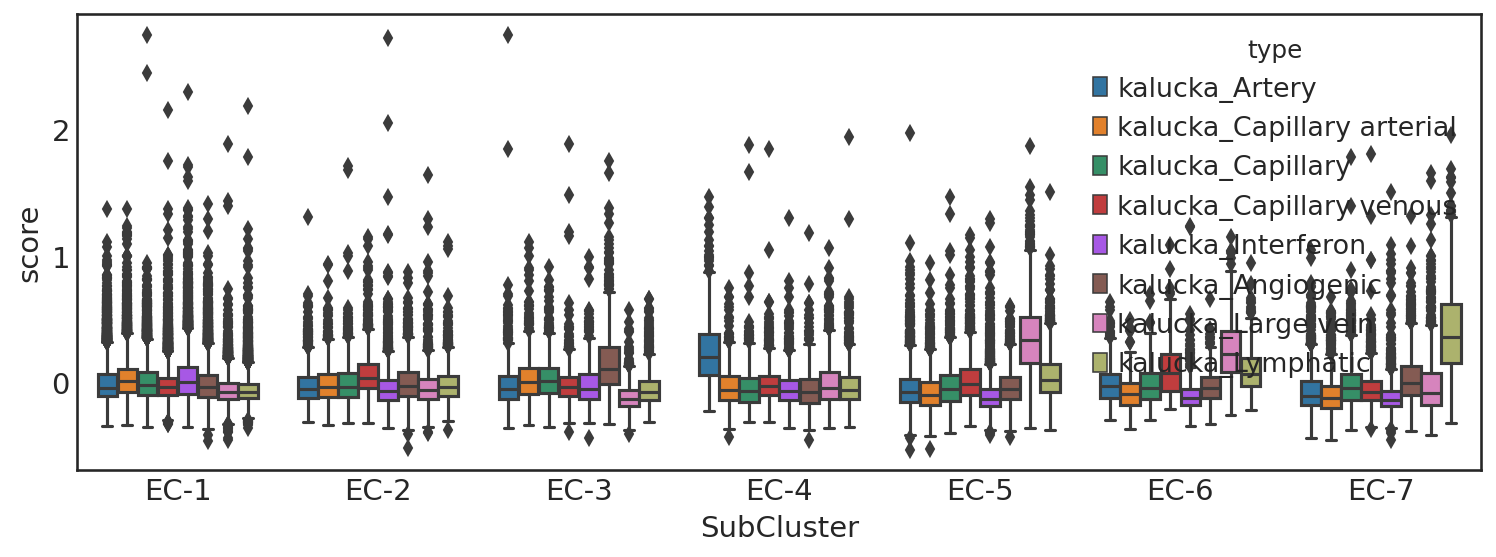

In [166]:
f = plt.figure(figsize=(12,4), dpi = 150)
sns.boxplot(x = 'SubCluster', y = 'score', hue = 'type', data = forplot[forplot['type'].isin([x for x in forplot['type'].unique() if re.search('kalucka',x)])],
           order = ['EC-'+str(y) for y in sorted([int(x.split('-')[1]) for x in forplot['SubCluster'].unique()])])

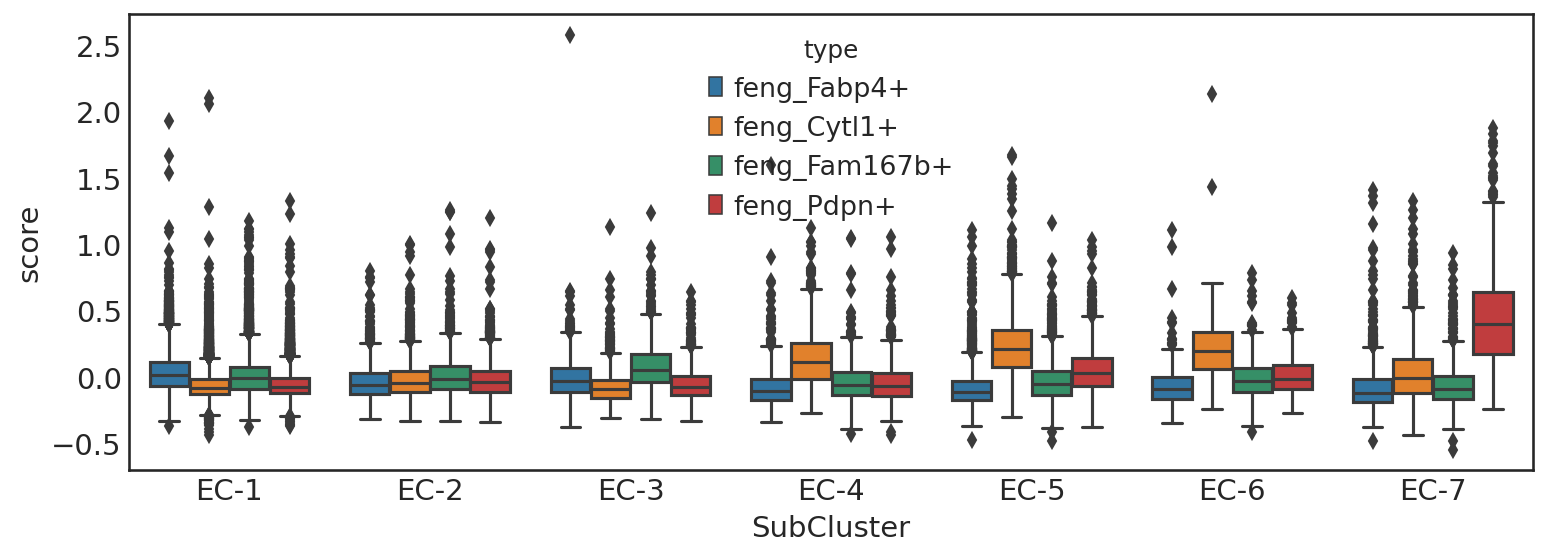

In [168]:
f = plt.figure(figsize=(12,4), dpi = 150)
sns.boxplot(x = 'SubCluster', y = 'score', hue = 'type', data = forplot[forplot['type'].isin([x for x in forplot['type'].unique() if re.search('feng',x)])],
            order = ['EC-'+str(y) for y in sorted([int(x.split('-')[1]) for x in forplot['SubCluster'].unique()])])

In [55]:
cell_type_map = {1:'EC-BTNL9',
                 2:'EC-KCNIP4',
                 3:'EC-Angiogenic',
                 4:'EC-Arterial',
                 5:'EC-Endocardial I',
                 6:'EC-Endocardial II',
                 7:'EC-Lymphatic'}

forplot = []
for i in [x for x in bdata.obs.columns if re.search('schupp',x)]:
    df = bdata.obs[['subcluster', i]].reset_index()
    df.columns = ['cell','subcluster','score']
    df['SubCluster'] = [cell_type_map[int(i)] for i in df['subcluster']]
    df['type'] = i
    forplot.append(df)
forplot = pd.concat(forplot)

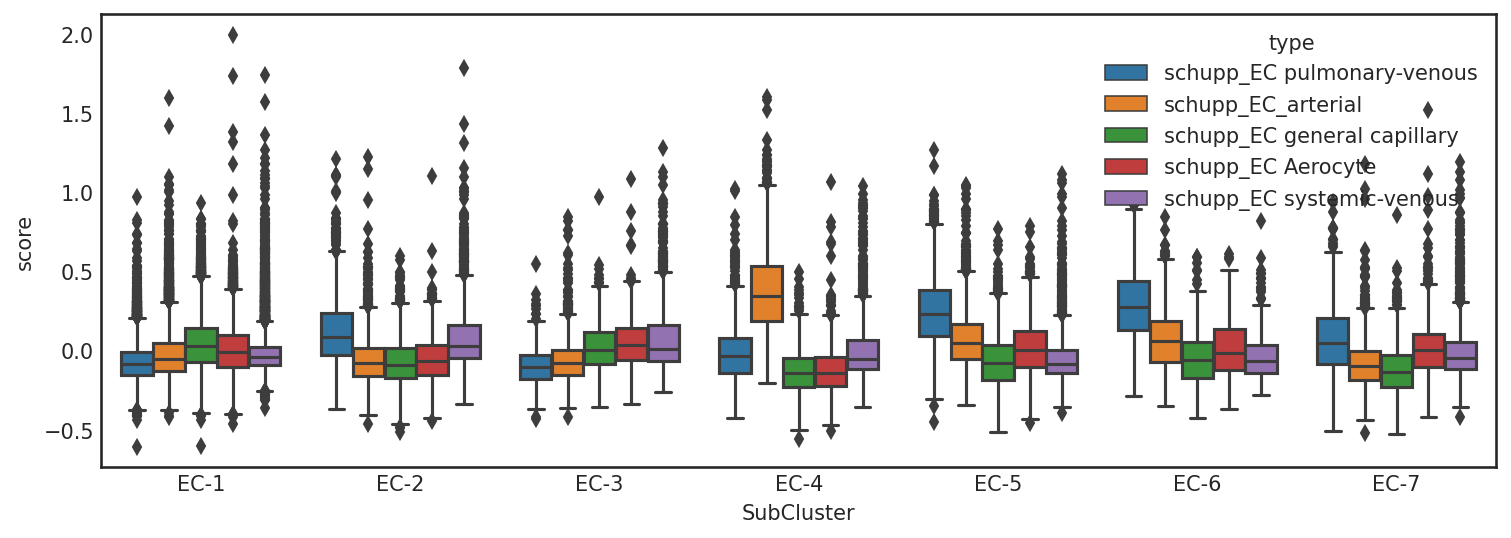

In [38]:
f = plt.figure(figsize=(12,4), dpi = 150)
sns.boxplot(x = 'SubCluster', y = 'score', hue = 'type', data = forplot[forplot['type'].isin([x for x in forplot['type'].unique() if re.search('schupp',x)])],
            order = ['EC-'+str(y) for y in sorted([int(x.split('-')[1]) for x in forplot['SubCluster'].unique()])])

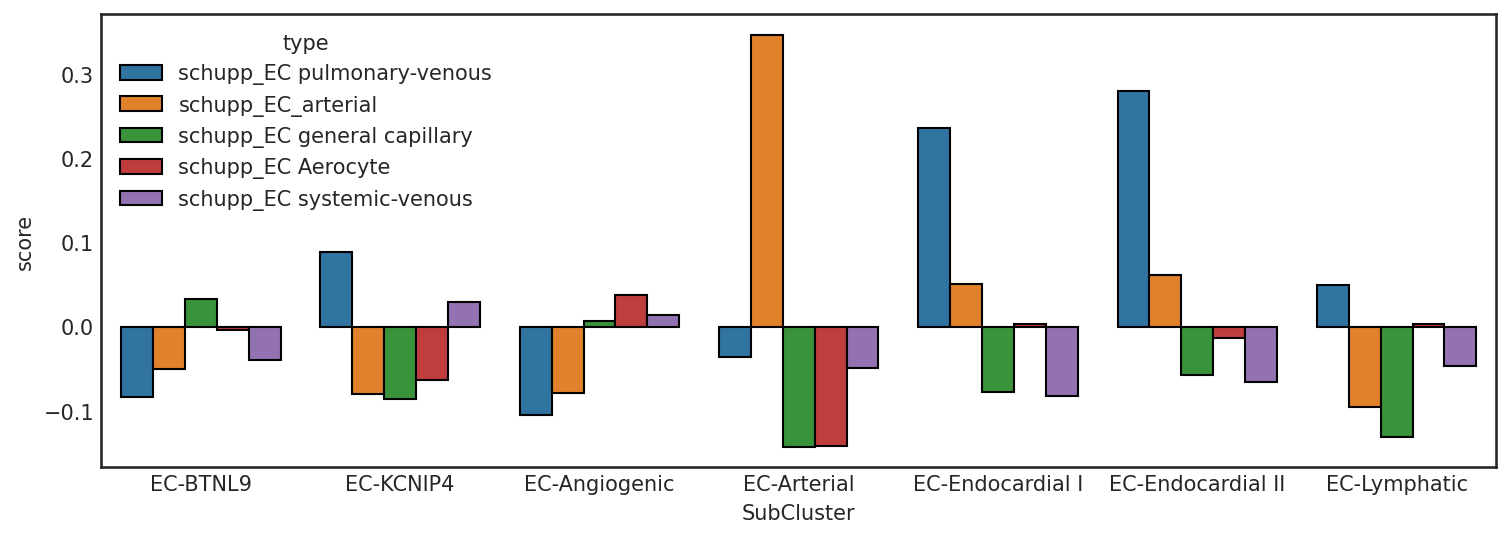

In [58]:
f = plt.figure(figsize=(12,4), dpi = 150)
sns.barplot(x = 'SubCluster', y = 'score', hue = 'type', data = forplot, estimator = np.median, ci = None,
            order = cell_type_map.values(), edgecolor='black')

In [57]:
cell_type_map.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7])

**UMAP**

In [170]:
adata = sc.read(os.path.join(results_path, celltype + '/subcluster_map_v3.h5ad'))

scores = pd.read_csv(os.path.join(results_path, celltype + '/EC_publication_scoring.txt'),sep='\t')
for i in scores.columns[2:]:
    mapper = {x:y for x,y in zip(scores['index'], scores[i])}
    adata.obs[i] = [mapper[x] for x in adata.obs.index]

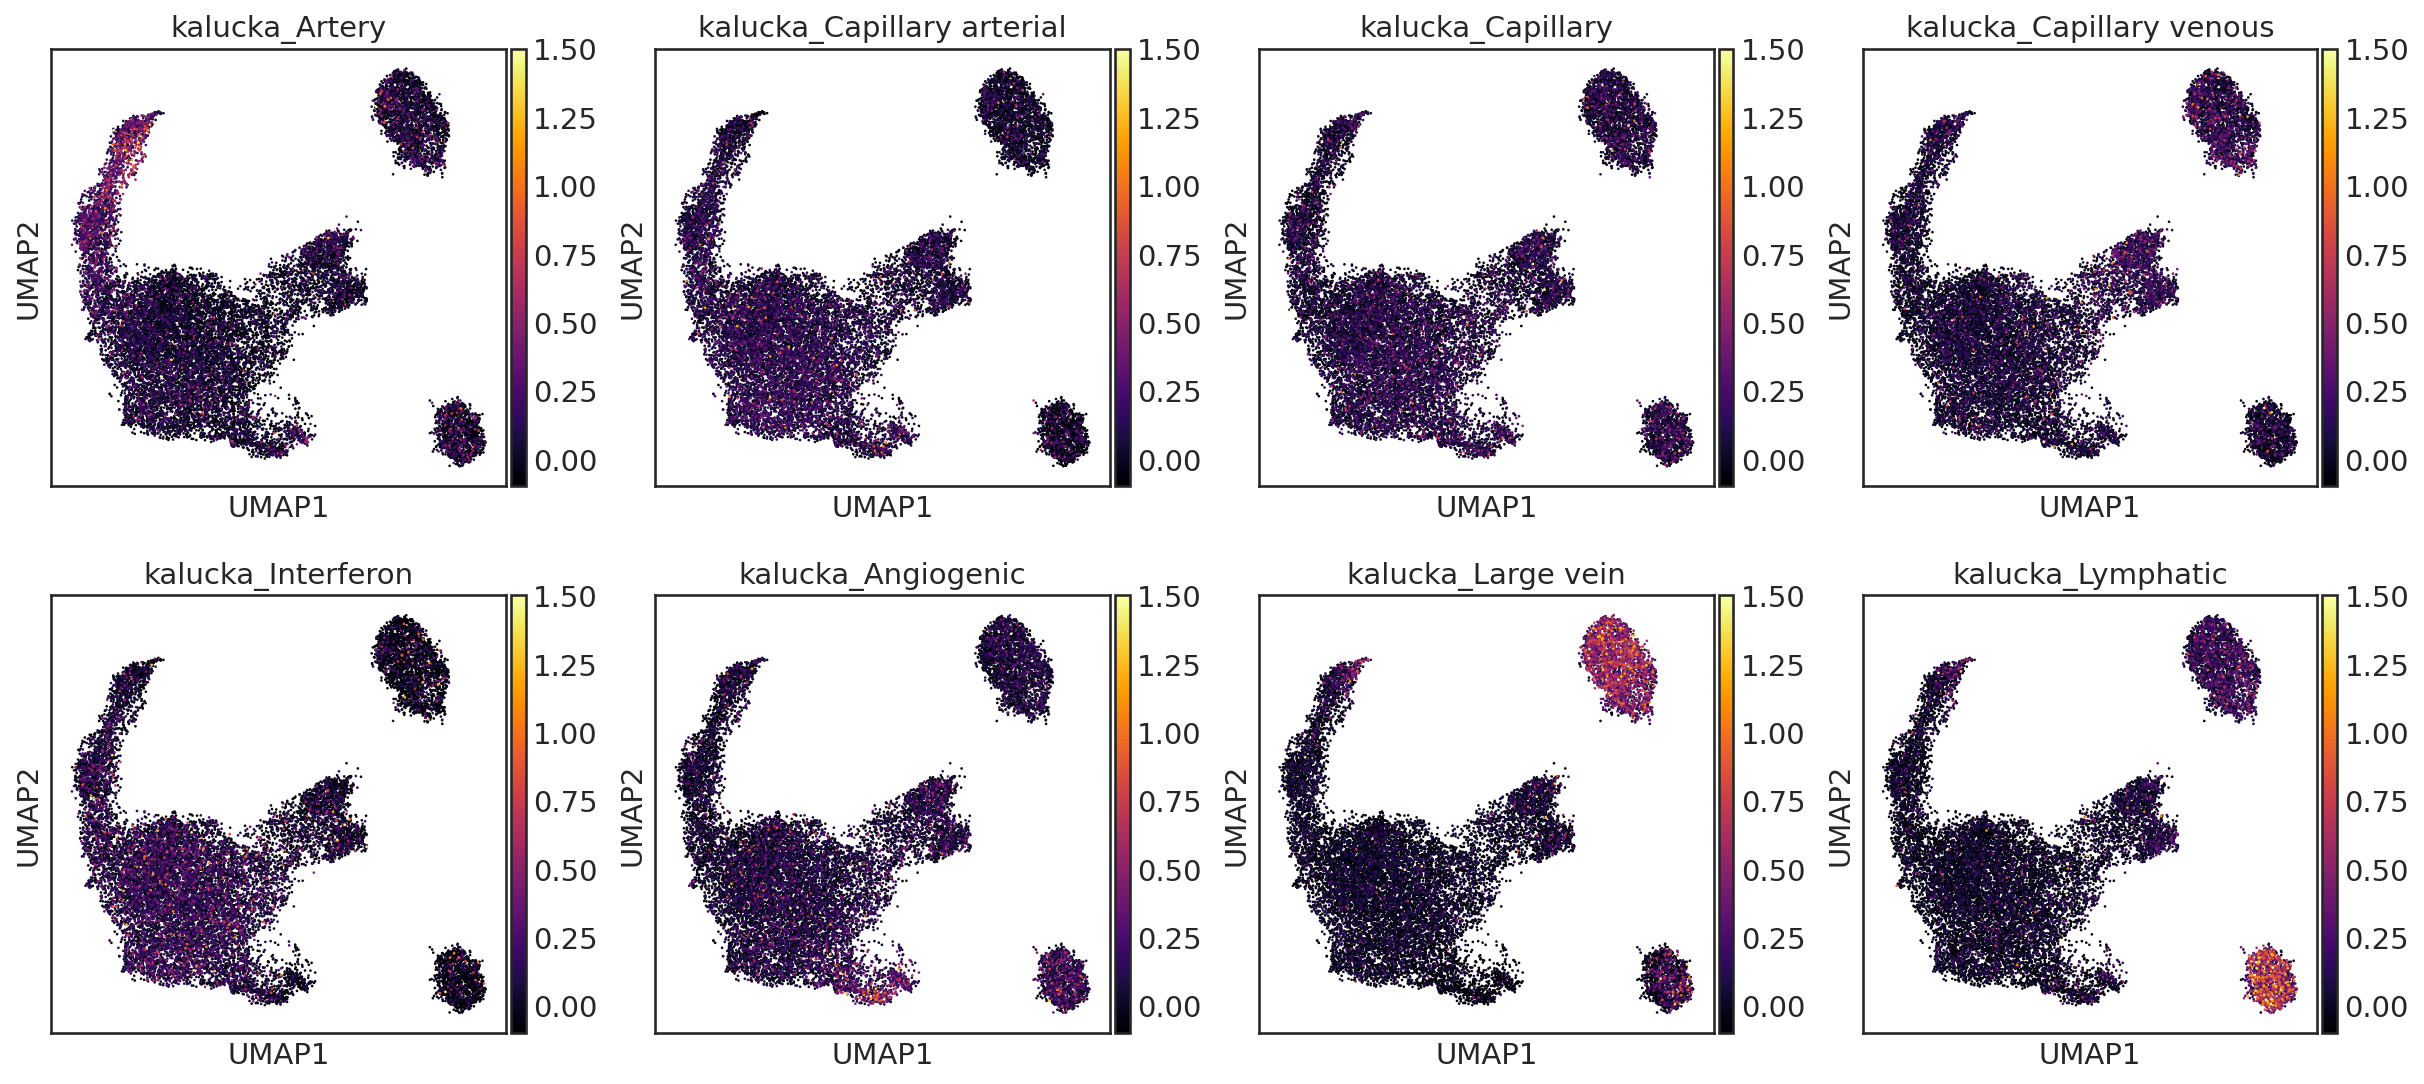

In [171]:
sc.pl.umap(adata, color = [x for x in forplot['type'].unique() if re.search('kalucka',x)], cmap = 'inferno', vmin = -.1, vmax = 1.5)

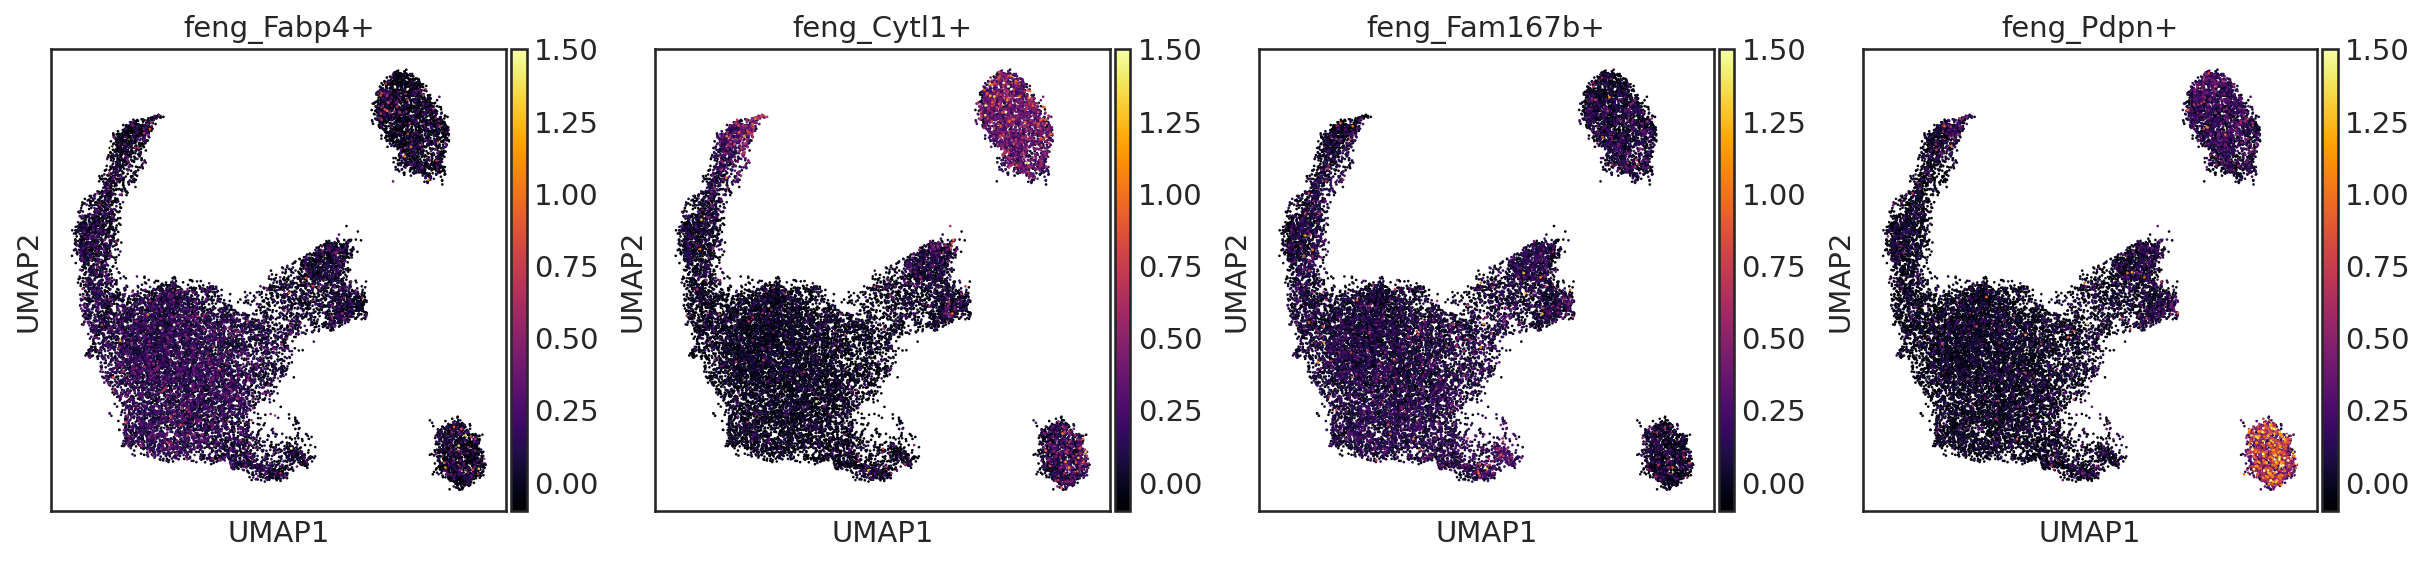

In [172]:
sc.pl.umap(adata, color = [x for x in forplot['type'].unique() if re.search('feng',x)], cmap = 'inferno', vmin = -.1, vmax = 1.5)

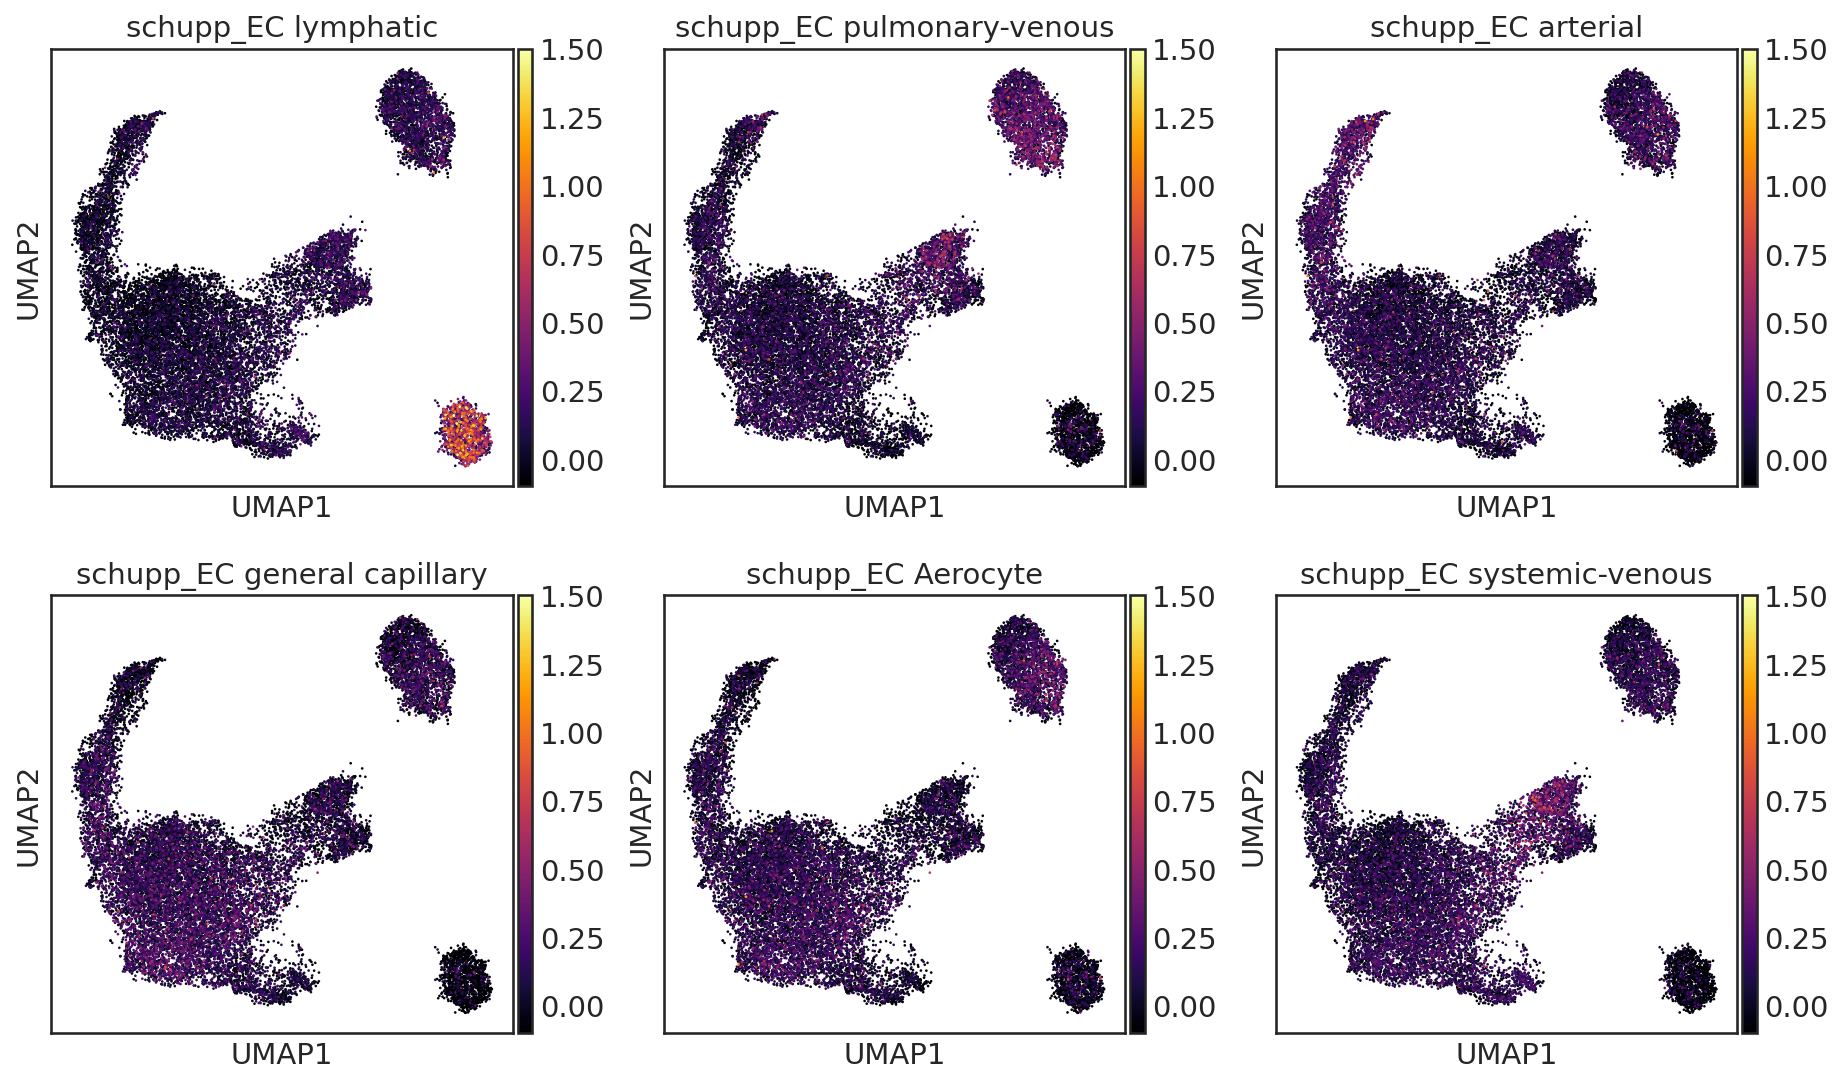

In [173]:
sc.pl.umap(adata, color = [x for x in forplot['type'].unique() if re.search('schupp',x)], cmap = 'inferno', vmin = -.1, vmax = 1.5, ncols = 3)

In [9]:
# Read Kalucka Markers
kalucka = pd.read_excel(os.path.join(scoring_data_path,'kalucka_et_al_2020_cell.xlsx'), sheet_name = 'heart', skiprows = 6)
kalucka_weights = {}
for i, name in zip([np.nan, 1, 2, 3, 4, 5, 6, 7],
                   ['Artery', 'Capillary arterial', 'Capillary',
                    'Capillary venous', 'Interferon', 'Angiogenic',
                    'Large vein', 'Lymphatic']):
    if pd.isnull(i):
        suffix = ''
    else:
        suffix = '.'+str(i)
    df = kalucka[['Gene'+suffix, 'Pvalue'+suffix, 'Adjusted pvalue'+suffix]]
    df.columns = ['gene','p_val','p_val_adj']
    kalucka_weights[name] = df

In [11]:
ang = kalucka_weights['Angiogenic']

In [18]:
markers = pd.read_csv('/medpop/bayercvd/pcl/ischemic_rat_human/V2/v2.0/results/subclustering_v2/endothelial/subcluster_merged_clusters_markers.txt',
                      sep='\t')
markers[(markers['gene'].isin([x.upper() for x in ang['gene']]))&(markers['cluster']==3)]['gene'].tolist()

['COL4A2', 'ITGA6', 'IGFBP7', 'COL15A1', 'PCDH17', 'NRP2', 'SPARCL1', 'PLXND1']

In [14]:
ang

gene         p_val     p_val_adj
0      Tmsb10  7.773042e-18  1.008941e-14
1      Ift122  8.247745e-17  5.352786e-14
2       Sparc  1.500133e-16  6.490576e-14
3       Cldn5  3.914994e-16  1.270415e-13
4      Col4a2  2.078491e-15  5.395763e-13
5        Apln  2.629524e-15  5.688538e-13
6         Vim  7.983691e-15  1.480404e-12
7      Igfbp7  2.541416e-14  4.123448e-12
8        Vwa1  3.579731e-14  5.162768e-12
9        Mest  8.559528e-14  1.111027e-11
10    Sparcl1  9.721487e-14  1.147135e-11
11        Adm  1.876534e-13  2.029784e-11
12      Aplnr  7.289157e-13  7.277943e-11
13      Meox1  8.992502e-13  8.337334e-11
14   Trp53i11  1.091186e-12  9.442398e-11
15       Prnp  3.738630e-12  3.032964e-10
16       Nrp2  7.245588e-12  5.532220e-10
17       Mycn  1.457124e-11  1.050749e-09
18  Tnfaip8l1  3.216662e-11  2.197488e-09
19      Ccnd1  4.696089e-11  3.047762e-09
20       Gnb4  6.489689e-11  4.011246e-09
21       Sox4  2.762058e-10  1.629614e-08
22      Dapk2  2.929342e-10  1.638223e-08
23      Bcl6b  3.029072e-10  1.638223e-08
24        Pgf  3.846944e-10  1.965013e-08
25      Kcna5  3.936081e-10  1.965013e-08
26    Col15a1  4.233223e-10  1.977660e-08
27       Bst2  4.266138e-10  1.977660e-08
28      Nudt4  4.516077e-10  2.021334e-08
29       Nid2  6.175093e-10  2.671757e-08
30       Actb  6.934063e-10  2.903359e-08
31       Ets2  9.085560e-10  3.607313e-08
32     Cyp4b1  9.171136e-10  3.607313e-08
33     Pcdh17  1.222349e-09  4.666497e-08
34     Akap13  2.383741e-09  8.840273e-08
35      Rgs16  3.859577e-09  1.366773e-07
36       Prcp  3.939973e-09  1.366773e-07
37      Stmn1  4.001339e-09  1.366773e-07
38      Knop1  4.670195e-09  1.554337e-07
39       Jam3  5.513875e-09  1.789252e-07
40     Lgals1  7.609915e-09  2.409188e-07
41      Itga6  1.039209e-08  3.211652e-07
42      Hmgb2  1.115669e-08  3.367764e-07
43      Tubb6  1.236302e-08  3.647090e-07
44     Plxnd1  1.377179e-08  3.972397e-07
45      Arl4c  1.787724e-08  5.044490e-07
46       Noct  1.954504e-08  5.397759e-07
47      Lamc1  5.071866e-08  1.371517e-06
48        Kit  7.879104e-08  2.087159e-06
49      Hcls1  9.125375e-08  2.368947e-06